#### Group members

- Owen Shen (Student ID: A14386302)
  - Contributions:
    - Initial background research
    - News scraping of NYT, Guardian, and Google Trends
    - Cleaning code and creating gifs
    - Discussion
    - Grooming final notebook for submission
- Maximilian Siemers (Student ID: U07608641)
  - Contributions:
    - Background and related work
    - Definition of death cause categories by ICD-10 blocks
    - Methods for CDC analysis & plots
    - Analysis Code
    - Discussion, incl. plots for terrorism/heart disease
    - Grooming final notebook for submission
- Hasan Al-Jamaly (Student ID: A13307127)
  - Contributions:
    - CDC data cleaning
    - Processing CDC data for analysis
    - Processing NYT data for analysis
    - Processing Guardian data for analysis
    - Processing Google Trends data for analysis
    - Analysis Code
- Nicole Stone (Student ID: A13534389)
  - Contributions:
    - Initial background research
    - Keyword research and generation
    - Analysis planning & data grooming
    - Analysis Code
    - Discussion, incl. Conclusion
    - Grooming final notebook for submission

********
# Introduction

On the data science and machine learning platform Kaggle, the competition with the highest monetary prize is currently a passenger screening algorithm, awarded by the US Department of Homeland Security. Judging from the attention that the threat of terrorism receives in the media, these efforts meet a considerable public interest in the danger arising from terrorism. At the same time, the amount of attention that media allocates on multiple other causes of death that are more relevant by orders of magnitude seems to fall behind disproportionately. 

According to [businessinsider.com](http://www.businessinsider.com/death-risk-statistics-terrorism-disease-accidents-2017-1), the lifetime odds of dying from foreign-born terrorism in the US are 1 in 45808. For comparison, it is approximately five times as likely to die in an airplane or spaceship incident, five and a half times as likely to die from police, almost five hundred times as likely to die from suicide, and respectively about 6500 times as likely to die from a heart disease or cancer, the two most common death causes in the US.

A fascinating paper by Combs and Slovic (1979) compared the frequency distribution of all death causes reported by two US newspapers during a time span of six months in 1975 with the actual mortality rates of that year and people's reported estimates of death cause frequencies. 

They found that "The frequency with which the two newspapers [...] reported various causes of death differed considerably from the statistical frequencies of those causes in the U.S. population. The finding that both newspapers, locate on opposite coasts of the U.S., allocated their coverage to causes of death in very similar ways suggests that the particular reporting biases observbed here may be widespread. Violent, often catastrophic causes of death such as homicides, natural disasters and accidents were overreported. Diseases were underreported. These biases in coverage corresponded closely to biases found in a previous study in which people were asked to judge the frequency of the same causes of death."

While we have absolutely no intention of discounting atrocious acts of terrorism, we think it is worthwhile to take a data-driven approach to see how causes of death stack up with people's expectations from the media. Attention is zero-sum in today's news environment. We want to see if exposure is well-calibrated to the actual scale of the deaths involved.

We derive the following working hypothesis:

We hypothesize that there is a discrepancy between media attention and the actual numbers of people who die from specific causes, i.e. that media coverage is *not* proportional to the number of people who die.

********
# Import Statements and Utility Code
To begin, we'll load in our imports and define a few functions that will make the later data parsing easier. 
(This is partially because our data loading functions take a little while to run, so while we show the original code we used to clean/scrape below, the CDC code here will load our already pre-cleaned CSV for analysis.)

In [1]:
# Imports:
import time
import datetime
import json
import math
import ast
import os
import csv
import sys
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import string
import warnings
import seaborn as sns
import copy
from functools import reduce

# Config
warnings.filterwarnings('ignore')
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15,8)

In [2]:
### Data imports and clean-up
# Importing data from CDC
# These three datasets contain cumulated official United States death information in increasing detail
# Source: http://wonder.cdc.gov
cdc_chapter  = pd.read_csv('data/cdc_by_year_and_icd10_chapter_1999_2016.txt', sep = '\t')
cdc_cause113 = pd.read_csv('data/cdc_by_year_and_icd10_113_cause_1999_2016.txt', sep = '\t')
cdc_cause    = pd.read_csv('data/cdc_by_year_and_icd10_cause_1999_2016.txt', sep = '\t', low_memory = False)


# Clean up CDC data
cdc_chapter.rename(columns={'ICD Chapter':'Cause'}, inplace=True)
cdc_chapter.drop(axis=1,labels=["Crude Rate", "Year Code", "ICD Chapter Code", "Notes"] , inplace=True)

cdc_cause113.rename(columns={"ICD-10 113 Cause List": "Cause"}, inplace=True)
cdc_cause113.drop(labels=["Notes", "Year Code", "ICD-10 113 Cause List Code", "Crude Rate"], axis=1, inplace=True)

cdc_cause.rename(columns={'Cause of death':'Cause', 'Cause of death Code' : 'Code'}, inplace=True)
cdc_cause.drop(labels=["Year Code", "Notes", "Crude Rate"], axis=1, inplace=True)


# Load our normalized news data
NYT_df = pd.read_csv('results/new_nyt_counts_normalized.csv')
Guardian_df = pd.read_csv('results/new_guardian_normalized_counts.csv')
Google_df = pd.read_csv('results/new_google_normalized_trends.csv')

In [3]:
### A bunch of functions to analyze CDC data

cdc_cause    = pd.read_csv('data/cdc_by_year_and_icd10_cause_1999_2016.txt', sep = '\t', low_memory = False)

# Clean up data
cdc_cause.rename(columns={'Cause of death':'Cause', 'Cause of death Code' : 'Code'}, inplace=True)
cdc_cause.drop(labels=["Year Code", "Notes", "Crude Rate"], axis=1, inplace=True)

def get_cdc_icd_blocks(icd_block_range_str):
    """
    Returns sorted array of ICD-10 block names (first three chars, e.g. "I05")
    based on occurrences in CDC_cause.
    
        icd_block_range_str:    String containing a description of ICD-10 block name ranges,
                                using a lower and an upper boundary, separated by colons ("-")
    
    Example: "I05-I09" will return ["I05", "I06", ..., "I09"]
    """
    
    def get_icd_block_range(start_block, end_block):
        """
        Returns hypothetical (need not exist in cdc_cause) ICD-10 block range
        """
        
        def get_char_code(char):
            """
            "a" -> "00"
            "b" -> "01"
            ...
            """

            if not len(char) == 1:
                raise ValueError("char must be single letter")

            char_pos = np.where(np.array(list(string.ascii_lowercase)) == char.lower())[0][0]
            char_pos = "{:02d}".format(char_pos)
            return(char_pos)

        def get_codenum(block):
            """
            'A00' -> 0
            'A01' -> 1
            ...
            'A99' -> 99
            'B00' -> 100
            ...
            """
            
            return(int(get_char_code(block[0]) + block[1:3]))

        def get_blocks(codenums):
            """
            E.g., [0, 1, 101] -> ['A00', 'A01', 'B01']
            """
            
            def get_block(codenum):
                char   = list(string.ascii_lowercase)[int(np.floor(codenum/100))].upper()
                digits = "{:02d}".format(int(str(codenum)[-2:]))
                block  = char+digits
                return(block)

            return(list(map(get_block, codenums)))

        start_codenum = get_codenum(start_block)
        end_codenum = get_codenum(end_block)

        codenum_range = np.arange(start_codenum, end_codenum+1)

        block_range = get_blocks(codenum_range)

        return(block_range)
    
    # List with sorted unique Blocks (e.g., "I10") in CDC_cause
    all_cdc_blocks = np.array(cdc_cause['Code'].str.slice(0, 3).unique())
    all_cdc_blocks.sort()

    boundaries = np.array(icd_block_range_str.split("-"))
    if len(boundaries) == 1:
        start_block  = boundaries[0]
        end_block    = start_block
    elif len(boundaries) == 2:
        start_block  = boundaries[0]
        end_block    = boundaries[1]
    
    if(len(start_block) > 3 | len(end_block) > 3):
        print("Length of boundary start or end > 3, warning: information might be truncated")
        start_block  = start_block[:3]
        end_block    = end_block[:3]
    elif(len(start_block) < 3 | len(end_block) < 3):
        raise ValueError("Length of boundary start or end < 3, you might be trying to use this function in a way that hasn't been implemented yet")
    
    hypothetical_icd_block_range = get_icd_block_range(start_block, end_block)
    return(all_cdc_blocks[np.isin(all_cdc_blocks, hypothetical_icd_block_range)])


def get_mortality_by_icd_block_range(icd_block_range_str, years = 'all'):
    """
    Returns number of deaths in cdc_cause
    First output is raw sum, second is sum of #death rel to population (only if only one year)

        icd_block_range_str:    String containing a description of ICD-10 block name ranges,
                                using a lower and an upper boundary, separated by colons ("-").
        year:                   Array of years to filter cdc_cause.

    """
    
    block_range = icd_block_range_str

    if isinstance(years, int):
        years = [years]
    elif years == 'all':
        years = list(cdc_cause['Year'].unique())

    block_list  = get_cdc_icd_blocks(block_range)
    
    cdc_block_and_year_match_idx = np.logical_and(np.isin(cdc_cause['Code'].str.slice(0, 3), block_list),
                                                  np.isin(cdc_cause['Year'], years))
    
    cdc_matches_death_pop = cdc_cause.loc[cdc_block_and_year_match_idx, ['Deaths']]
    return(int(cdc_matches_death_pop.sum(axis=0)))


def get_mortality_by_category(cat_codename_icd_dict, years = "all"):
    """
    Returns number of deaths per category as a df.
    First output is raw sum, second is sum of #death rel to population (only if only one year).

        cat_codename_icd_dict:      dict with category codenames as keys and ICD-10 block range descriptions as values.
        years:                      Array of years to filter cdc_cause.

    """

    categories = []
    mortality = []
    for codename, icd_block_range_str_arr in cat_codename_icd_dict.items():
        cat_sum = 0

        for icd_block_range_str in icd_block_range_str_arr:
            cat_sum += get_mortality_by_icd_block_range(icd_block_range_str, years)

        categories.append(codename)
        mortality.append(cat_sum)
    
    df = pd.DataFrame(np.matrix(mortality).T,
                      index = categories,
                      columns = ['mortality'])
    
    # Now normalize data by dividing by sum of mortality for years in consideration
    mortality_normalized = np.array(mortality)/sum(mortality)
    df['mortality_normalized'] = mortality_normalized
    
    return(df)


def get_raw_rel_mortality_by_cat_and_year_range(cat_dict, year_range):
    """
    Arguments
    ---------
        cat_dict: dict with category names as keys and ICD-10 block ranges as values
        
        year_range: e.g., [2001, 2002, 2003]

    Returns
    -------
    	first: df with raw mortality, second: df with rel mortality
    """
    
    raw_mortality_by_cat_and_year = pd.DataFrame()
    rel_mortality_by_cat_and_year = pd.DataFrame()

    for year in year_range:
        mortality = get_mortality_by_category(cat_dict, year)
        mortality_raw = mortality['raw_mortality']
        mortality_rel = mortality['rel_mortality']
        raw_mortality_by_cat_and_year[year] = mortality_raw
        rel_mortality_by_cat_and_year[year] = mortality_rel

    return(raw_mortality_by_cat_and_year, rel_mortality_by_cat_and_year)

********
# Methods

The following sections describe our analysis and scraping of the data we will compare in the end. We use four data sources:
- Centers for Disease Control and Prevention (CDC) 'Underlying Cause of Death'. Dataset contains information including the International Catalogue of Diseases (ICD) 10 diagnosis code for most deaths that occurred in the United States between 1999 and 2016.
- All _New York Times_ and _The Guardian_ headlines between 1999 and 2016, scraped from their archives and filtered by keywords matching a selection of death causes
- Google Trends search data for the time between 2004 and 2016 based on the same keywords

## Gathering Data

### Newspaper Mentions

We'd like to see how often our different causes of death are mentioned in the news. Both the New York Times and the Guardian provide helpful APIs that allow us to query their database for how often a word is mentioned. Using the code below, we can load up our API keys to allow us make the appropriate function calls.

In [2]:
# Importing API key
nytAPIPath = 'nytDevKey.txt'
fin=open(nytAPIPath,'r')
nyt_api_key = str(fin.readline()).rstrip()

guardianAPIPath = 'guardianAPI.txt'
fin=open(guardianAPIPath,'r')
guardian_api_key = str(fin.readline()).rstrip()

Now that we've got our API keys set, we'll write two functions which can search both the NYT and the Guardian's databases. We'll use Requests to make the HTTP request and parse the resulting JSON to grab the number of hits, which is either denoted as 'hits' or as 'total'.

In [3]:
# NYT API:
nyt_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json";

def searchNYT(string, startDate, endDate, page="0", justHits=False):
    searchString = (nyt_url + '?fq=' + '"' + string + '"' + '&page=' + page 
                    + '&begin_date=' + startDate + '&end_date=' + endDate + '&api-key=' + nyt_api_key)
    
    response = requests.get(searchString).json();

    if (justHits):
        
        # logic to handle different response types, standardizes them
        if 'response' not in response.keys():
            response = ast.literal_eval(response['message'])
    
        return response['response']['meta']['hits']
    
    else:
        return response
    
        
# The Guardian's API
guardian_url = "https://content.guardianapis.com/search"

def searchGuardian(string, startDate, page='1', justHits=False):
    searchString = (guardian_url + '?q=' + '"' + string + '"' + '&from-date=' + startDate + 
                    '&page=' + page + '&page-size=50' + '&order-by=oldest' + 
                    '&api-key=' + guardian_api_key)
    
    response = requests.get(searchString);
    
    response = response.json()
    
    if (justHits):
        return response['response']['total']
    else:
        return response

In order to do our search, we'll load in our CSV of all our keywords:

In [4]:
wordsList = pd.read_csv('./keywords.csv')

We sorted our search terms as shown in this table:

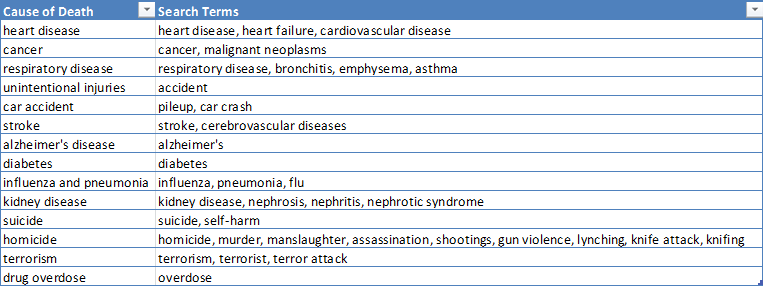

Now we'll go through our list of keywords and record their counts and save it as a CSV for both the NYT and the Guardian. 

(Note that because this takes quite a while, we've just shown some of the output and not all of it, but you can see that the code is indeed designed to iterate over all years. Later on, we'll load-in our pre-scraped data, but you can easily verify that the numbers are the same if you so wish. The output says that an exception occurred, but that's just us halting the scraping early.)

#### Scraping The New York Times

In [5]:
try:
    for year in range(1999, 2017):
        tempList = []

        for j in range(len(wordsList)):
            time.sleep(0.7)
            tempList.append(searchNYT(wordsList.iloc[j][0], str(year)+"-01-01", str(year+1)+"-01-01", justHits=True))
            print(tempList[j], end=' ')

        
        # Normally saves it as a csv, but we've already done that earlier
        # np.savetxt(str(year) + '.csv', tempList)

        print("Done!")
      
except KeyboardInterrupt:
    sys.exit(0)

242 162 33 2908 0 5 35 61 237 2 142 25 83 822 0 141 332 64 178 234 30 0 0 0 908 0 366 2344 172 388 686 671 3 693 103 1 16 53 35 Done!
234 102 33 3068 0 4 29 46 247 0 152 26 109 

SystemExit: 0

#### Scraping The Guardian

In [6]:
try:
    for year in range(1999, 2017):
        tempList = []

        for j in range(len(wordsList)):

            time.sleep(0.1)

            diff1 = (searchGuardian(wordsList.iloc[j][0], str(year)+"-01-01", justHits=True))

            time.sleep(0.1)

            diff2 = (searchGuardian(wordsList.iloc[j][0], str(year+1)+"-01-01", justHits=True))

            # The Guardian's hits number is the number from that the past to the time specified, so we must make two calls
            # and take the difference to get an accurate number.
          
            diff = diff1 - diff2
          
            tempList.append(diff)

            print(diff, end=' ')

        # Normally saves it as a csv, but we've already done that earlier
        # np.savetxt('./results/' + str(year) + '.csv', tempList)

        print('Done!')
      
except KeyboardInterrupt:
    sys.exit(0)

215 31 14 1223 0 5 38 32 158 0 49 0 136 536 0 63 121 42 95 255 11 0 1 0 875 14 79 2552 205 309 627 854 4 333 44 7 18 27 12 Done!
292 37 

SystemExit: 0

#### Google Trends

For Google Trends, there is an API called pytrends that makes queries to Google for us and returns data from 2004 onwards about the relative search frequencies of different terms.

In [25]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

It makes less sense, though, to aggregate search results for related words, especially as Google Trends data might not be necessarily additive. So instead we'll import our "main list" of the general categories we care about:

In [26]:
majorKeywords = pd.read_csv('./majorKeywords.csv')

In [27]:
majorKeywords

,Words
0,Heart Disease
1,Cancer
2,Lower Respiratory Diesease
3,Car Accidents
4,Stroke
5,Diabetes
6,Alzheimer's Disease
7,Pneumonia & Influenza
8,Kidney
9,Suicide


Now we'll run pytrends and get back a new dataframe that includes the counts, month-by-month, of our data. (Note that below, we've slightly modified the names of the majorKeywords to allow us better search coverage.)

In [28]:
googleTrendSum = pd.DataFrame();

majorWords = ['heart disease', 'cancer', 'respiratory disease', 'car accidents', 'stroke', 'diabetes', 
              'alzheimer\'s', 'pneumonia', 'kidney disease', 'suicide', 'homicide', 'terrorism', 'overdose']

for i in majorWords:
    kw_list = []
    kw_list.append(i)
    pytrends.build_payload(kw_list, cat=0, 
                       timeframe='all', geo='', gprop='')
    df = pytrends.interest_over_time()[i]
    googleTrendSum[i] = df

Here is a preview of our data:

In [29]:
googleTrendSum = googleTrendSum.transpose()

In [30]:
googleTrendSum.iloc[:, 0:5]

date,2004-01-01 00:00:00,2004-02-01 00:00:00,2004-03-01 00:00:00,2004-04-01 00:00:00,2004-05-01 00:00:00
heart disease,80,100,88,78,74
cancer,84,88,89,90,87
respiratory disease,71,84,100,87,81
car accidents,76,100,93,84,78
stroke,91,98,100,96,96
diabetes,91,96,100,100,92
alzheimer's,100,88,82,75,69
pneumonia,50,46,46,44,40
kidney disease,67,67,84,85,59
suicide,21,23,21,23,20


### Cleaning The News Data

#### NYT and Guardian

We need to modify our NYT and Guardian hit list to make sure it conforms to our majorKeywords list. Let's load up their CSVs first and see what they look like:

In [7]:
nyt_final = pd.read_csv('./results/NYT/nyt_counts.csv').drop(['Unnamed: 0'], axis=1)
guardian_final = pd.read_csv('./results/Guardian/guardian_counts.csv').drop(['Unnamed: 0'], axis=1)

In [8]:
nyt_final

,Words,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,heart disease,242.0,234.0,249.0,304.0,250.0,322.0,300.0,423.0,426.0,365.0,401.0,322.0,328.0,402.0,355.0,270.0,290.0,305.0
1,heart failure,162.0,102.0,145.0,139.0,120.0,177.0,233.0,265.0,252.0,285.0,280.0,239.0,243.0,205.0,188.0,159.0,186.0,196.0
2,cardiovascular disease,33.0,33.0,32.0,50.0,49.0,61.0,48.0,73.0,71.0,81.0,78.0,61.0,59.0,70.0,82.0,70.0,97.0,76.0
3,cancer,2908.0,3068.0,2775.0,2931.0,2572.0,2609.0,2661.0,3417.0,3999.0,4019.0,4609.0,4161.0,4239.0,3895.0,3137.0,3300.0,3184.0,3128.0
4,malignant neoplasms,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,respiratory disease,5.0,4.0,1.0,7.0,120.0,8.0,16.0,11.0,16.0,12.0,26.0,15.0,13.0,17.0,11.0,11.0,13.0,15.0
6,bronchitis,35.0,29.0,34.0,26.0,26.0,27.0,28.0,55.0,49.0,27.0,21.0,29.0,14.0,35.0,36.0,36.0,25.0,30.0
7,emphysema,61.0,46.0,44.0,39.0,53.0,70.0,64.0,60.0,58.0,55.0,58.0,46.0,51.0,38.0,42.0,41.0,29.0,24.0
8,asthma,237.0,247.0,290.0,184.0,221.0,215.0,180.0,243.0,332.0,209.0,274.0,291.0,245.0,243.0,191.0,210.0,142.0,202.0
9,unintentional injuries,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,4.0,3.0,2.0,4.0


In [9]:
guardian_final

,Words,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,heart disease,215.0,292.0,285.0,317.0,392.0,469.0,348.0,294.0,365.0,294.0,209.0,208.0,231.0,219.0,288.0,287.0,304.0,338.0
1,heart failure,31.0,37.0,61.0,56.0,66.0,82.0,80.0,69.0,89.0,109.0,49.0,62.0,83.0,71.0,99.0,97.0,66.0,101.0
2,cardiovascular disease,14.0,17.0,12.0,15.0,19.0,46.0,36.0,27.0,35.0,30.0,33.0,27.0,23.0,33.0,50.0,64.0,80.0,69.0
3,cancer,1223.0,1653.0,2091.0,2054.0,1996.0,2244.0,2328.0,2505.0,2483.0,2549.0,2267.0,2025.0,2478.0,2505.0,2878.0,2926.0,2990.0,3049.0
4,malignant neoplasms,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,respiratory disease,5.0,4.0,6.0,5.0,12.0,16.0,14.0,8.0,6.0,10.0,13.0,6.0,13.0,14.0,4.0,26.0,23.0,20.0
6,bronchitis,38.0,26.0,44.0,37.0,50.0,62.0,39.0,28.0,25.0,33.0,27.0,22.0,22.0,29.0,36.0,33.0,41.0,50.0
7,emphysema,32.0,25.0,49.0,38.0,26.0,50.0,33.0,28.0,36.0,41.0,9.0,34.0,23.0,22.0,20.0,30.0,24.0,28.0
8,asthma,158.0,180.0,169.0,186.0,205.0,268.0,207.0,214.0,223.0,214.0,166.0,152.0,150.0,157.0,197.0,211.0,245.0,285.0
9,unintentional injuries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,2.0


Okay, so there are a lot more categories here than we care about. So let's merge the related ones into our majorKeywords list so we can start to do some better comparisons.

In [10]:
nyt_total = pd.DataFrame()

nyt_total['Heart Disease'] = nyt_final.iloc[0:3, 1:].sum()
nyt_total['Cancer'] = nyt_final.iloc[3:5, 1:].sum()
nyt_total['Lower Respiratory Disease'] = nyt_final.iloc[5:9, 1:].sum()
nyt_total['Car Accidents'] = nyt_final.iloc[10:13, 1:].sum()
nyt_total['Stroke'] = nyt_final.iloc[13:15, 1:].sum()
nyt_total['Alzheimer\'s Disease'] = nyt_final.iloc[15:16, 1:].sum()
nyt_total['Diabetes'] = nyt_final.iloc[16:17, 1:].sum()
nyt_total['Pneumonia & Influenza'] = nyt_final.iloc[17:20, 1:].sum()
nyt_total['Kidney'] = nyt_final.iloc[20:24, 1:].sum()
nyt_total['Suicide'] = nyt_final.iloc[24:26, 1:].sum()
nyt_total['Homicide'] = nyt_final.iloc[26:30, 1:].sum()
nyt_total['Terrorism'] = nyt_final.iloc[30:33, 1:].sum() + nyt_final.iloc[33:35, 1:].sum() 
nyt_total['Overdose'] = nyt_final.iloc[38:39, 1:].sum()

nyt_total = nyt_total.transpose()

guardian_total = pd.DataFrame()

guardian_total['Heart Disease'] = guardian_final.iloc[0:3, 1:].sum()
guardian_total['Cancer'] = guardian_final.iloc[3:5, 1:].sum()
guardian_total['Lower Respiratory Disease'] = guardian_final.iloc[5:9, 1:].sum()
guardian_total['Car Accidents'] = guardian_final.iloc[10:13, 1:].sum()
guardian_total['Stroke'] = guardian_final.iloc[13:15, 1:].sum()
guardian_total['Alzheimer\'s Disease'] = guardian_final.iloc[15:16, 1:].sum()
guardian_total['Diabetes'] = guardian_final.iloc[16:17, 1:].sum()
guardian_total['Pneumonia & Influenza'] = guardian_final.iloc[17:20, 1:].sum()
guardian_total['Kidney'] = guardian_final.iloc[20:24, 1:].sum()
guardian_total['Suicide'] = guardian_final.iloc[24:26, 1:].sum()
guardian_total['Homicide'] = guardian_final.iloc[26:30, 1:].sum()
guardian_total['Terrorism'] = guardian_final.iloc[30:33, 1:].sum() + guardian_final.iloc[33:35, 1:].sum()
guardian_total['Overdose'] = guardian_final.iloc[38:39, 1:].sum()

guardian_total = guardian_total.transpose()

In [11]:
nyt_total

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Heart Disease,437.0,369.0,426.0,493.0,419.0,560.0,581.0,761.0,749.0,731.0,759.0,622.0,630.0,677.0,625.0,499.0,573.0,577.0
Cancer,2908.0,3068.0,2775.0,2931.0,2572.0,2609.0,2662.0,3417.0,3999.0,4019.0,4609.0,4161.0,4239.0,3895.0,3137.0,3300.0,3184.0,3128.0
Lower Respiratory Disease,338.0,326.0,369.0,256.0,420.0,320.0,288.0,369.0,455.0,303.0,379.0,381.0,323.0,333.0,280.0,298.0,209.0,271.0
Car Accidents,250.0,287.0,330.0,318.0,288.0,299.0,296.0,395.0,549.0,395.0,486.0,521.0,579.0,521.0,369.0,418.0,380.0,442.0
Stroke,822.0,803.0,719.0,732.0,712.0,740.0,728.0,1012.0,1028.0,1088.0,1079.0,1161.0,1211.0,1226.0,1012.0,827.0,838.0,1171.0
Alzheimer's Disease,141.0,145.0,159.0,167.0,143.0,198.0,163.0,170.0,230.0,236.0,325.0,260.0,271.0,247.0,239.0,250.0,226.0,234.0
Diabetes,332.0,358.0,456.0,441.0,473.0,482.0,472.0,724.0,798.0,709.0,802.0,764.0,617.0,732.0,618.0,529.0,519.0,555.0
Pneumonia & Influenza,476.0,461.0,434.0,394.0,680.0,817.0,989.0,1047.0,753.0,590.0,2278.0,634.0,569.0,623.0,689.0,591.0,527.0,671.0
Kidney,30.0,25.0,31.0,41.0,59.0,42.0,53.0,59.0,44.0,66.0,74.0,48.0,65.0,60.0,60.0,47.0,46.0,41.0
Suicide,908.0,910.0,1332.0,2011.0,1842.0,1599.0,1814.0,2118.0,2374.0,1874.0,2105.0,1945.0,1954.0,1839.0,1635.0,1714.0,1817.0,2497.0


In [12]:
guardian_total

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Heart Disease,260.0,346.0,358.0,388.0,477.0,597.0,464.0,390.0,489.0,433.0,291.0,297.0,337.0,323.0,437.0,448.0,450.0,508.0
Cancer,1223.0,1653.0,2091.0,2054.0,1996.0,2244.0,2328.0,2505.0,2483.0,2549.0,2268.0,2025.0,2478.0,2505.0,2879.0,2926.0,2990.0,3049.0
Lower Respiratory Disease,233.0,235.0,268.0,266.0,293.0,396.0,293.0,278.0,290.0,298.0,215.0,214.0,208.0,222.0,257.0,300.0,333.0,383.0
Car Accidents,185.0,256.0,294.0,401.0,402.0,383.0,351.0,396.0,654.0,538.0,534.0,424.0,447.0,404.0,595.0,503.0,642.0,677.0
Stroke,536.0,667.0,781.0,891.0,994.0,1043.0,1012.0,1215.0,1191.0,1290.0,1080.0,906.0,1088.0,1114.0,1215.0,1214.0,1231.0,1246.0
Alzheimer's Disease,63.0,92.0,94.0,74.0,79.0,99.0,81.0,94.0,115.0,111.0,77.0,77.0,85.0,92.0,88.0,56.0,10.0,1.0
Diabetes,121.0,214.0,201.0,262.0,352.0,413.0,385.0,334.0,465.0,404.0,261.0,310.0,370.0,392.0,501.0,574.0,556.0,541.0
Pneumonia & Influenza,392.0,488.0,427.0,399.0,616.0,500.0,947.0,951.0,792.0,610.0,1568.0,550.0,530.0,488.0,591.0,568.0,551.0,555.0
Kidney,12.0,21.0,14.0,13.0,27.0,22.0,18.0,13.0,33.0,16.0,14.0,27.0,23.0,16.0,29.0,23.0,37.0,34.0
Suicide,889.0,1008.0,1992.0,2305.0,2732.0,2644.0,2855.0,2545.0,2893.0,2818.0,2150.0,1814.0,1897.0,1781.0,1926.0,2294.0,2919.0,3370.0


Now the two dataframes are looking a lot cleaner! Our last step is to normalize them across each year, so we don't need to worry about problems with increased traffic over time, and this makes it easier to graph. To do that, we'll divide the values in each column by the total sum for that column (i.e. year).

In [13]:
nyt_sums = nyt_total.iloc[:, 0:].sum()
guardian_sums = guardian_total.iloc[:, 0:].sum()

In [14]:
nyt_total.divide(nyt_sums)

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Heart Disease,0.036107,0.031410,0.021672,0.024259,0.023749,0.032501,0.036529,0.036938,0.034594,0.040247,0.035977,0.034095,0.033748,0.037887,0.037030,0.030169,0.031252,0.024839
Cancer,0.240271,0.261151,0.141171,0.144228,0.145780,0.151422,0.167369,0.165858,0.184703,0.221274,0.218467,0.228087,0.227073,0.217975,0.185863,0.199516,0.173657,0.134653
Lower Respiratory Disease,0.027927,0.027749,0.018772,0.012597,0.023805,0.018572,0.018108,0.017911,0.021015,0.016682,0.017965,0.020885,0.017302,0.018636,0.016590,0.018017,0.011399,0.011666
Car Accidents,0.020656,0.024430,0.016788,0.015648,0.016324,0.017353,0.018610,0.019173,0.025357,0.021748,0.023036,0.028559,0.031016,0.029157,0.021863,0.025272,0.020725,0.019027
Stroke,0.067917,0.068352,0.036577,0.036020,0.040356,0.042948,0.045772,0.049121,0.047480,0.059902,0.051145,0.063641,0.064870,0.068610,0.059960,0.050000,0.045705,0.050409
Alzheimer's Disease,0.011650,0.012343,0.008089,0.008218,0.008105,0.011492,0.010248,0.008252,0.010623,0.012993,0.015405,0.014252,0.014517,0.013823,0.014160,0.015115,0.012326,0.010073
Diabetes,0.027431,0.030473,0.023198,0.021701,0.026809,0.027974,0.029676,0.035142,0.036857,0.039035,0.038015,0.041879,0.033051,0.040965,0.036616,0.031983,0.028307,0.023892
Pneumonia & Influenza,0.039329,0.039241,0.022079,0.019388,0.038542,0.047417,0.062182,0.050820,0.034779,0.032484,0.107977,0.034753,0.030480,0.034865,0.040822,0.035732,0.028743,0.028885
Kidney,0.002479,0.002128,0.001577,0.002018,0.003344,0.002438,0.003332,0.002864,0.002032,0.003634,0.003508,0.002631,0.003482,0.003358,0.003555,0.002842,0.002509,0.001765
Suicide,0.075023,0.077460,0.067762,0.098957,0.104404,0.092803,0.114052,0.102806,0.109649,0.103177,0.099777,0.106616,0.104671,0.102916,0.096872,0.103628,0.099100,0.107490


In [15]:
guardian_total.divide(guardian_sums)

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Heart Disease,0.029106,0.034210,0.019180,0.021976,0.025768,0.031335,0.023509,0.020256,0.023469,0.021062,0.016995,0.020299,0.021675,0.020883,0.023745,0.023030,0.018919,0.021153
Cancer,0.136908,0.163437,0.112028,0.116334,0.107828,0.117783,0.117951,0.130103,0.119169,0.123991,0.132453,0.138405,0.159377,0.161958,0.156433,0.150414,0.125709,0.126957
Lower Respiratory Disease,0.026083,0.023235,0.014358,0.015066,0.015828,0.020785,0.014845,0.014439,0.013918,0.014496,0.012556,0.014626,0.013378,0.014353,0.013964,0.015422,0.014000,0.015948
Car Accidents,0.020710,0.025311,0.015751,0.022712,0.021717,0.020103,0.017784,0.020567,0.031388,0.026170,0.031186,0.028980,0.028750,0.026120,0.032330,0.025857,0.026992,0.028190
Stroke,0.060002,0.065948,0.041843,0.050464,0.053698,0.054745,0.051274,0.063104,0.057161,0.062749,0.063073,0.061923,0.069977,0.072024,0.066018,0.062407,0.051755,0.051882
Alzheimer's Disease,0.007053,0.009096,0.005036,0.004191,0.004268,0.005196,0.004104,0.004882,0.005519,0.005399,0.004497,0.005263,0.005467,0.005948,0.004782,0.002879,0.000420,0.000042
Diabetes,0.013545,0.021159,0.010769,0.014839,0.019016,0.021678,0.019507,0.017347,0.022317,0.019652,0.015243,0.021188,0.023797,0.025344,0.027222,0.029507,0.023376,0.022527
Pneumonia & Influenza,0.043882,0.048250,0.022877,0.022599,0.033278,0.026244,0.047981,0.049392,0.038011,0.029672,0.091573,0.037591,0.034088,0.031551,0.032113,0.029199,0.023166,0.023110
Kidney,0.001343,0.002076,0.000750,0.000736,0.001459,0.001155,0.000912,0.000675,0.001584,0.000778,0.000818,0.001845,0.001479,0.001034,0.001576,0.001182,0.001556,0.001416
Suicide,0.099519,0.099664,0.106724,0.130551,0.147588,0.138778,0.144652,0.132180,0.138846,0.137076,0.125562,0.123983,0.122009,0.115148,0.104651,0.117925,0.122724,0.140323


#### Google Trends

First off, we need to group up our data by years, as the raw Google trends data is month by month.

In [41]:
newGoogle = pd.DataFrame()
for i in range(0,13):
    newGoogle[str(i+2004)] = googleTrendSum.iloc[:, (i*12):(i+1)*12].sum(axis=1)

Now our data looks like this:

In [42]:
newGoogle

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
heart disease,876,777,625,540,484,484,453,429,443,429,419,421,425
cancer,1056,1036,934,854,830,821,792,792,797,797,811,832,847
respiratory disease,826,740,554,504,508,466,437,418,414,412,490,479,498
car accidents,984,915,789,661,597,595,572,497,469,446,414,423,420
stroke,1110,1077,984,870,856,838,863,957,963,957,960,973,1033
diabetes,1104,1044,939,851,792,777,761,744,742,746,765,782,784
alzheimer's,974,834,788,631,623,565,378,395,316,255,270,304,340
pneumonia,505,536,483,462,496,542,507,582,605,611,634,687,725
kidney disease,847,865,812,757,715,747,755,716,782,821,833,904,963
suicide,241,244,211,184,181,168,167,162,168,163,172,211,388


Looking good! Once more, we just normalize, and then we are done:

In [43]:
google_totals = newGoogle.iloc[:, :].sum()

In [44]:
newGoogle.divide(google_totals)

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
heart disease,0.083381,0.078564,0.072598,0.070221,0.065282,0.065868,0.064928,0.061312,0.063659,0.061558,0.057108,0.056306,0.053486
cancer,0.100514,0.104752,0.108491,0.111053,0.111950,0.111731,0.113516,0.113191,0.114528,0.114364,0.110536,0.111275,0.106595
respiratory disease,0.078622,0.074823,0.064351,0.065540,0.068519,0.063419,0.062634,0.059740,0.059491,0.059119,0.066785,0.064063,0.062673
car accidents,0.093661,0.092518,0.091648,0.085956,0.080523,0.080974,0.081984,0.071030,0.067395,0.063998,0.056426,0.056573,0.052857
stroke,0.105654,0.108898,0.114299,0.113134,0.115457,0.114045,0.123692,0.136773,0.138382,0.137322,0.130844,0.130132,0.130003
diabetes,0.105083,0.105561,0.109072,0.110663,0.106825,0.105743,0.109073,0.106331,0.106625,0.107045,0.104266,0.104587,0.098666
alzheimer's,0.092709,0.084328,0.091532,0.082055,0.084030,0.076892,0.054178,0.056453,0.045409,0.036591,0.036800,0.040658,0.042789
pneumonia,0.048068,0.054196,0.056104,0.060078,0.066900,0.073762,0.072667,0.083179,0.086938,0.087674,0.086411,0.091882,0.091241
kidney disease,0.080621,0.087462,0.094320,0.098440,0.096439,0.101660,0.108213,0.102330,0.112372,0.117807,0.113534,0.120904,0.121193
suicide,0.022939,0.024671,0.024509,0.023927,0.024413,0.022863,0.023936,0.023153,0.024141,0.023389,0.023443,0.028220,0.048830


### Actual Death Data: CDC

We will compare news and Google Trends data with the actual numbers of how many people die from specific causes of death. A dataset encompassing every death that occurred in the US since 1999 is available at https://wonder.cdc.gov/. A dataset that summarizes the number of people who died from causes as specified in the International Catalogue of Diseases (ICD-10) is saved in data/cdc_by_year_and_icd10_cause_1999_2016.txt.

#### Define death cause categories

We will now define death cause categories of interest and gather the numbers for these categories from the CDC dataset. The categories are defined by a name (dictionary keys) and ranges of ICD-10 blocks. The information that was used to define these categories comes mostly from looking up ICD-10 diagnoses on Wikipedia and other online resources.

In [45]:
cat_codename_icd_dict = {'heart':           ['I05-I09',
                                             'I11',
                                             'I20-I25',
                                             'I26-I28',
                                             'I30-I52'],
                        'cancer_all':       ['C00-D48'],
                        'cancer_lung':      ['C34'],
                        'cancer_anal':      ['C13-C21'],
                        'cancer_breast':    ['C50'],
                        'loresp':           ['J40-J47'],
                        'accident':         ['V01-X59'],
                        'stroke':           ['I61-I64'],
                        'alzheimer':        ['F00',
                                             'G30'],
                        'diabetes':         ['E10-E14'],
                        'influpneu':        ['J09-J18'],
                        'kidney':           ['N00-N29'],
                        'suicide':          ['X60-X84'],
                        'homicide_all':     ['X85-Y09'],
                        'homicide_firearm': ['X93-X95'],
                        'homicide_legmil':  ['Y35-Y36'],
                        'overdose':         ['X40-X49'],
                        'terrorism':        ['U01']}

#### Build a function that returns death numbers per category

Next, we define a function that understands these ICD-10 block ranges. The function takes a ICD-10 block range string (such as 'I05-I09') and returns a list of all ICD-10 blocks that are within the specified range and also occur at least once in the CDC dataset. For better readability, the function is outsourced to cdc_analysis_methods.py. Let's see what it does:

In [46]:
get_cdc_icd_blocks('I05-I09')

array(['I05', 'I06', 'I07', 'I08', 'I09'], dtype=object)

In [47]:
get_cdc_icd_blocks('V90-W09')

array(['V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98',
       'V99', 'W00', 'W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07',
       'W08', 'W09'], dtype=object)

The next step is to define a method that returns the number of people who died from a cause that falls within a specified ICD-10 block range. The method also takes years to consider (the default is 'all', which scrapes data from all available years 1999-2016). The first number that is returned is the absolute number of people, the second number is the first number divided by the population of the US in that year (which is specified in the CDC dataset, as well)

In [48]:
get_mortality_by_icd_block_range('I05-I10', years=2002)

15184

Based on this method, we can now build another method that takes in the dictionary of death cause categories that we defined above and that returns the number of people who died from a cause that falls within any of these categories. Again, the function is in the cdc_analysis_methods package, it optionally takes years, returns the normalized mortality, and it looks like this:

In [49]:
get_mortality_by_category(cat_codename_icd_dict, years='all')

,mortality,mortality_normalized
heart,11512237,0.288245
cancer_all,10504850,0.263022
cancer_lung,2817213,0.070538
cancer_anal,1483182,0.037136
cancer_breast,747919,0.018726
loresp,2434726,0.060961
accident,2146673,0.053749
stroke,1988802,0.049796
alzheimer,1373412,0.034388
diabetes,1316379,0.032960


Next, we want to collect mortality data year by year:

In [50]:
cdc_years_raw = pd.read_csv('./data/cdc_years_raw.csv', index_col=0)
cdc_years_norm = pd.read_csv('./data/cdc_years_norm.csv', index_col=0)

#### Validate results

We have now defined our categories and are able to gather the related data from CDC. Time to see if our data processing pipeline is valid. We check that by comparing our results with summarized data available on the Internet:

In [51]:
def compare_top_causes_2016(our_data_df):
    # Comparison data
    comp_top10 = pd.read_csv('./data/medicalnewstoday_statista_top_deaths_2016.csv')
    comp_top10 = comp_top10.set_index('cause')
    comp_top10[comp_top10 == 0] = None

    # Data for normalization, extracted from cdc:
    pop_2016      = 318810586
    n_deaths_2016 = 2744248

    # Normalize data by number of deaths in 2016
    comp_top10['mnt_ratio'] = comp_top10['mnt_deaths']/n_deaths_2016
    comp_top10['statista_ratio'] = comp_top10['statista_deaths']/n_deaths_2016
    comp_top10['cdc_ratio'] = our_data_df['mortality']/n_deaths_2016

    comp_top10.loc[:, ['cdc_ratio', 'mnt_ratio', 'statista_ratio']].plot.bar()


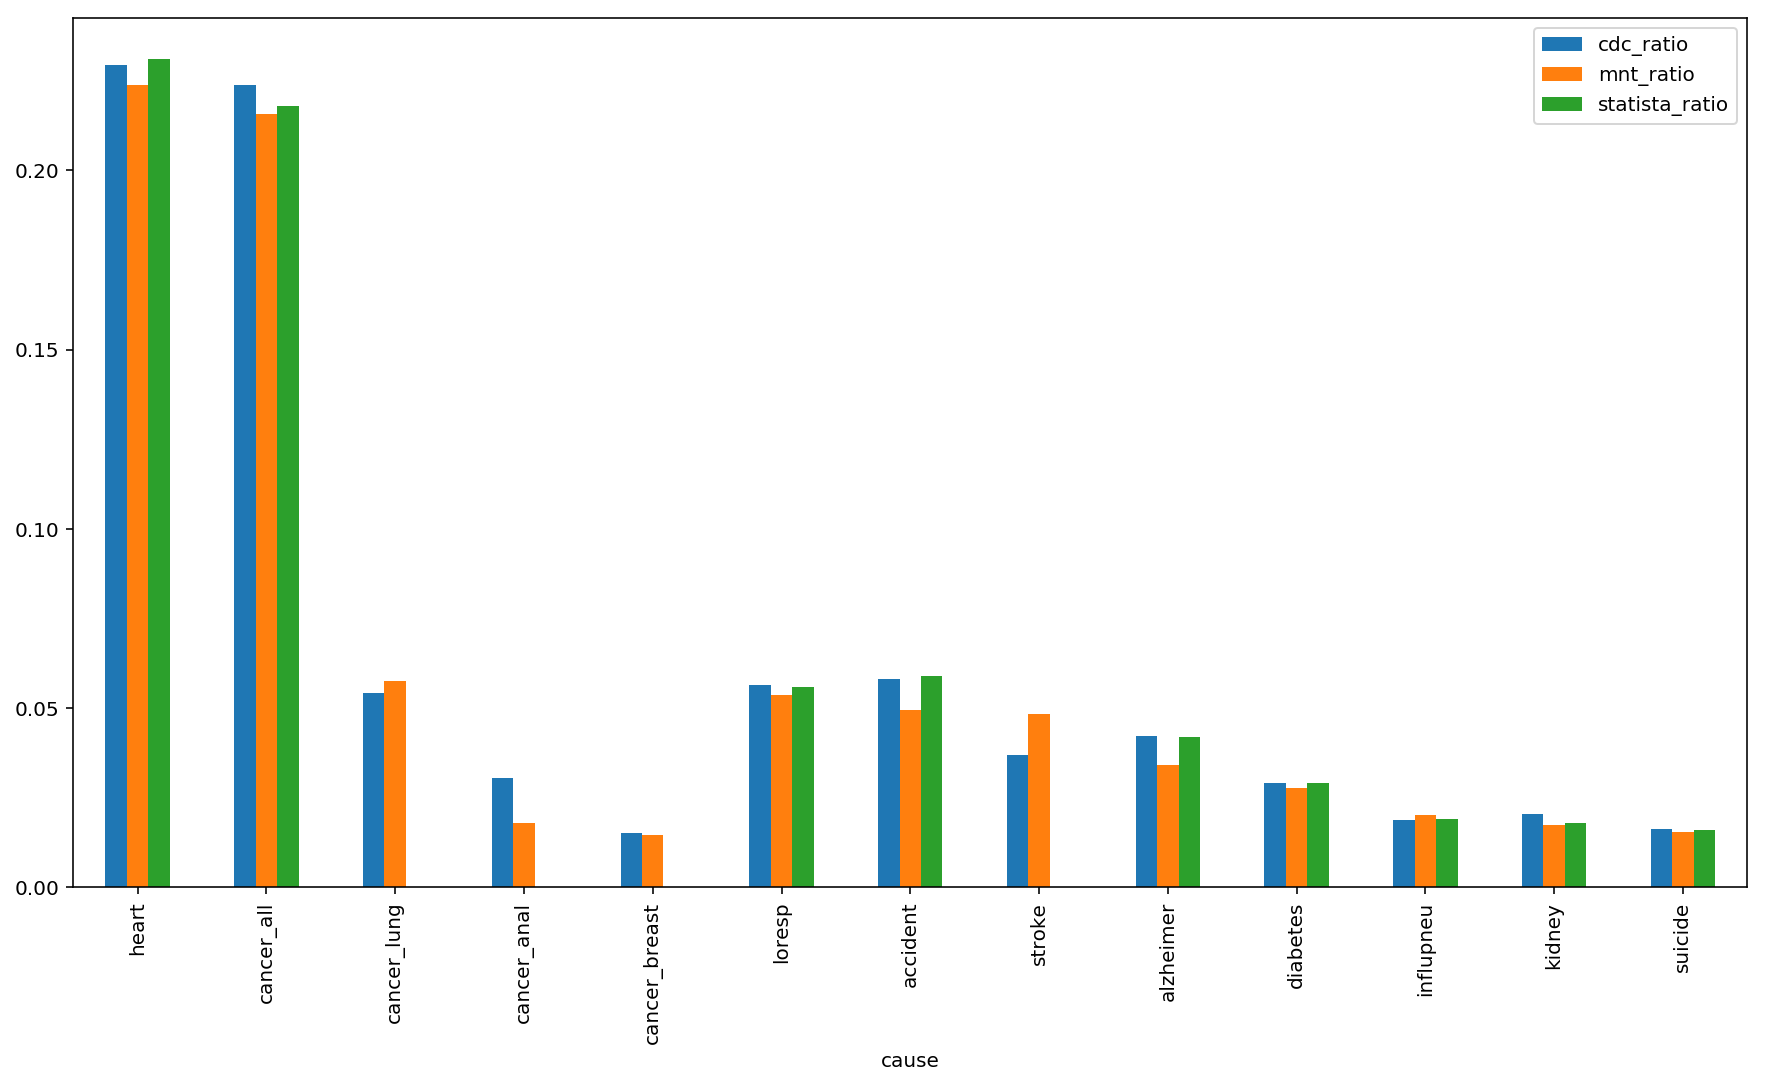

In [52]:
# Our data
cdc_data_2016 = get_mortality_by_category(cat_codename_icd_dict, years=2016)

compare_top_causes_2016(cdc_data_2016)

That looks overall very decent. The small fluctuations in the numbers by information source are within a reasonable range. We can go on!

### Putting together CDC and Media data

First, we will map the row names in the CDC df to the corresponding row names in the scraped media data

In [53]:
cdc_to_news = {'heart':       'Heart Disease',
               'cancer_all':  'Cancer',
               'loresp':      'Lower Respiratory Disease',
               'accident':    'Car Accidents',
               'stroke':      'Stroke',
               'alzheimer':   'Alzheimer\'s Disease',
               'diabetes':    'Diabetes',
               'influpneu':   'Pneumonia & Influenza',
               'kidney':      'Kidney',
               'suicide':     'Suicide',
               'homicide_all':'Homicide',
               'overdose':    'Overdose',
               'terrorism':   'Terrorism'}

cdc_years_raw_renamed  = copy.deepcopy(cdc_years_raw)
cdc_years_norm_renamed = copy.deepcopy(cdc_years_norm)

cdc_years_raw_renamed.index  = pd.Series(list(cdc_years_raw_renamed.index)).map(cdc_to_news).tolist()
cdc_years_norm_renamed.index = pd.Series(list(cdc_years_norm_renamed.index)).map(cdc_to_news).tolist()

cdc_years_raw_renamed['cause']  = cdc_years_raw_renamed.index
cdc_years_norm_renamed['cause'] = cdc_years_norm_renamed.index

### Remove rows where cause of death is NaN (here we have CDC data but no news data)
cdc_years_raw_renamed  = cdc_years_raw_renamed.dropna()
cdc_years_norm_renamed = cdc_years_norm_renamed.dropna()

In [54]:
### Now put together all the normalized data from CDC, Guardian, NYT, and Google, year by year

all_data_by_years_dict = {}
for year in np.arange(1999, 2017): # actually only goes up to 2016:
    Guardian_df_renamed = copy.deepcopy(Guardian_df)
    Guardian_df_renamed.rename(columns={'Unnamed: 0': 'cause'}, inplace=True)

    NYT_df_renamed = copy.deepcopy(NYT_df)
    NYT_df_renamed.rename(columns={'Cause of Death': 'cause'}, inplace=True)

    Google_df_renamed = copy.deepcopy(Google_df)
    Google_df_renamed.rename(columns={'Unnamed: 0': 'cause'}, inplace=True)
    google_to_news = {'heart disease':'heart',
                    'cancer':               'cancer_all',
                    'respiratory disease':               'loresp',
                    'car accidents':               'accident',
                    'stroke':               'stroke',
                    'alzheimer\'s':               'alzheimer',
                    'diabetes':               'diabetes',
                    'pneumonia':               'influpneu',
                    'kidney disease':               'kidney',
                    'suicide':               'suicide',
                    'homicide':               'homicide_all',
                    'overdose':               'overdose',
                    'terrorism':               'terrorism'}
    Google_df_renamed.cause = (Google_df_renamed.cause.map(google_to_news).map(cdc_to_news))
    
    dfs = [pd.DataFrame(cdc_years_norm_renamed.loc[:, ['cause', str(year)]]),
           pd.DataFrame(Guardian_df_renamed.loc[:, ['cause', str(year)]]),
           pd.DataFrame(NYT_df_renamed.loc[:, ['cause', str(year)]]),
           pd.DataFrame(Google_df_renamed.loc[:, ['cause', str(year)]])]
    
    dfs_merged = reduce(lambda left, right: pd.merge(left, right, on='cause'), dfs)
    
    dfs_merged.columns = ['Cause of Death', 'CDC', 'Guardian', 'NYT', 'Google']
    
    all_data_by_years_dict[year] = dfs_merged

In [55]:
### Let's also have a df that includes all data from all data sources summed over all years
Guardian_df_renamed2 = copy.deepcopy(Guardian_df_renamed)
NYT_df_renamed2      = copy.deepcopy(NYT_df_renamed)
Google_df_renamed2   = copy.deepcopy(Google_df_renamed)

Guardian_df_renamed2.index = Guardian_df_renamed2.cause
NYT_df_renamed2.index = NYT_df_renamed2.cause
Google_df_renamed2.index = Google_df_renamed2.cause

cdc_years_norm_renamed_sums = pd.DataFrame(cdc_years_norm_renamed.sum(axis=1))
Guardian_df_renamed2_sums = pd.DataFrame(Guardian_df_renamed2.sum(axis=1))
NYT_df_renamed2_sums = pd.DataFrame(NYT_df_renamed2.sum(axis=1))
Google_df_renamed2_sums = pd.DataFrame(Google_df_renamed2.sum(axis=1))

sums_dfs = [cdc_years_norm_renamed_sums,
            Guardian_df_renamed2_sums,
            NYT_df_renamed2_sums,
            Google_df_renamed2_sums]

all_years_all_data = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), sums_dfs)
all_years_all_data.columns = ['CDC', 'Guardian', 'NYT', 'Google']

We have narrowed in on 13 causes of death as explained above. This process involved researching the 10 most common causes of death in the United States of America to compile a set of causes to consider. To this list we added terrorism, since it was the cause of death that prompted our research. We were also curious if there was a discrepency between unintentional accidents and reporting, especially with regards to car accidents, so we split that category into those two distinct causes. Lastly, we wanted to consider homicide as well, as individual cases seem to often make headline news. Thus, we have a total of 13 causes of death that we will analyze below.

Because this is categorical data, we will compute a chi-squared test for homogeneity after we gather our data to test for statistical significance. We will set a critical value of 0.01, which corresponds to a chi-value of 26.217 for the 12 degrees of freedom in this example.

********
# Results

## Plots: Comparing distributions year by year

Text(0,0.5,'Normalized frequency')

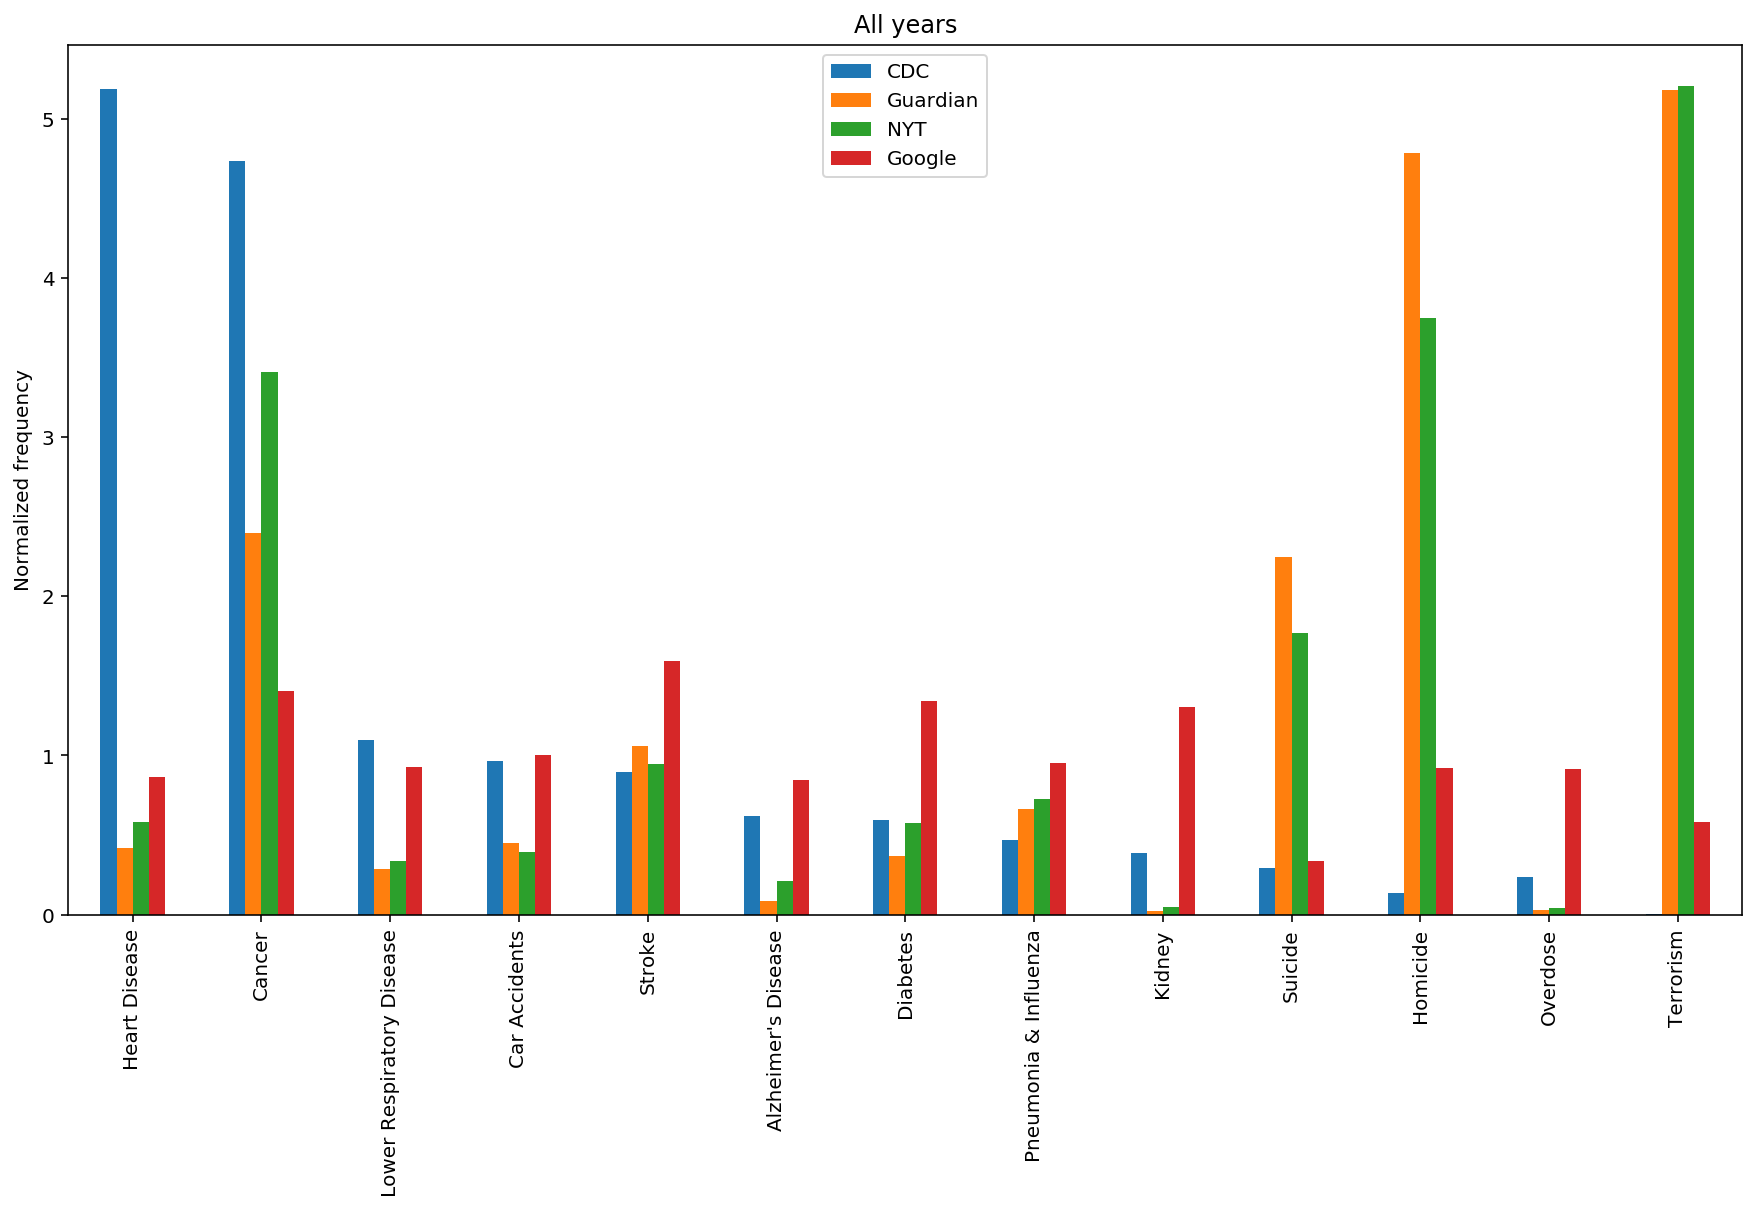

In [56]:
### All years
all_years_all_data.plot(kind = 'bar')
plt.title('All years')
plt.ylabel('Normalized frequency')

In this graph, and each graph to follow, we have normalized the counts of each category for each source. This means that each color above sums to 1 across all causes of death represented. This allows us to consider the relative nature of this categorical data coming from different sources with different total counts.

Above, it appears that when averaged across all years (1999-2016), heart disease accounts for over half of the deaths in this subset of the CDC dataset, while only accounting for approximately 5% of death reporting in New York Times and approximately 6% of death reporting in the Guardian as gathered via our scraping methods described above. Similarly, though less severely, cancer death rates disproportionately appear to outpace news coverage of cancer.  

Conversely, New York Times and the Guardian’s coverage of terrorism, suicide, and homicide all seem disproportionately high compared to the relative number of deaths reported by the CDC in each of these categories. 

The Google trend bars appear disproportionately high for overdose and kidney disease, though perhaps not outside of statistical reason. We will analyze this later. For now, let’s take a closer look at each year’s data:

Text(0.5,1,'1999')

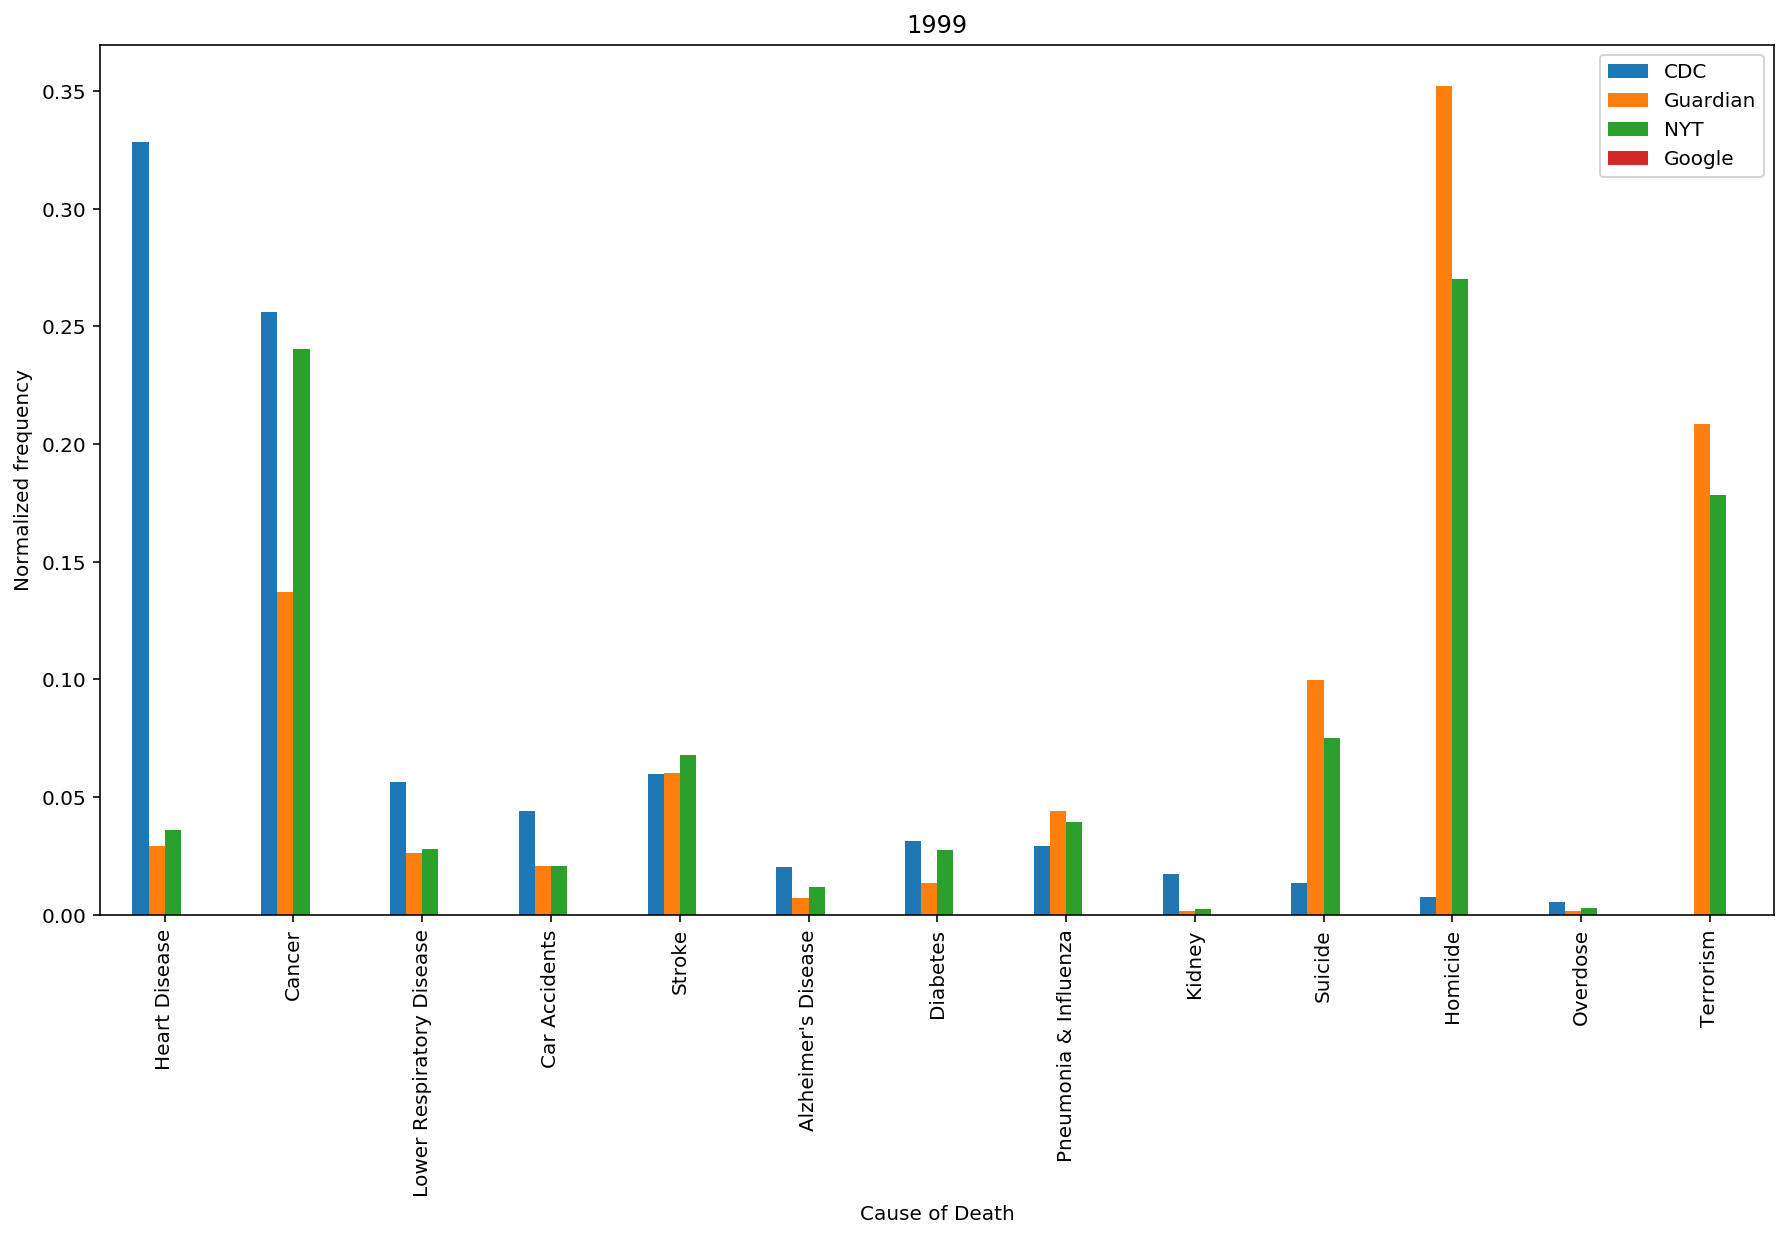

In [58]:
year = 1999
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Note the change on the “Normalized Frequency” scale. It appears 1999 trends loosely follow the macro trends, but to a smaller degree. We see the same with 2000:

Text(0.5,1,'2000')

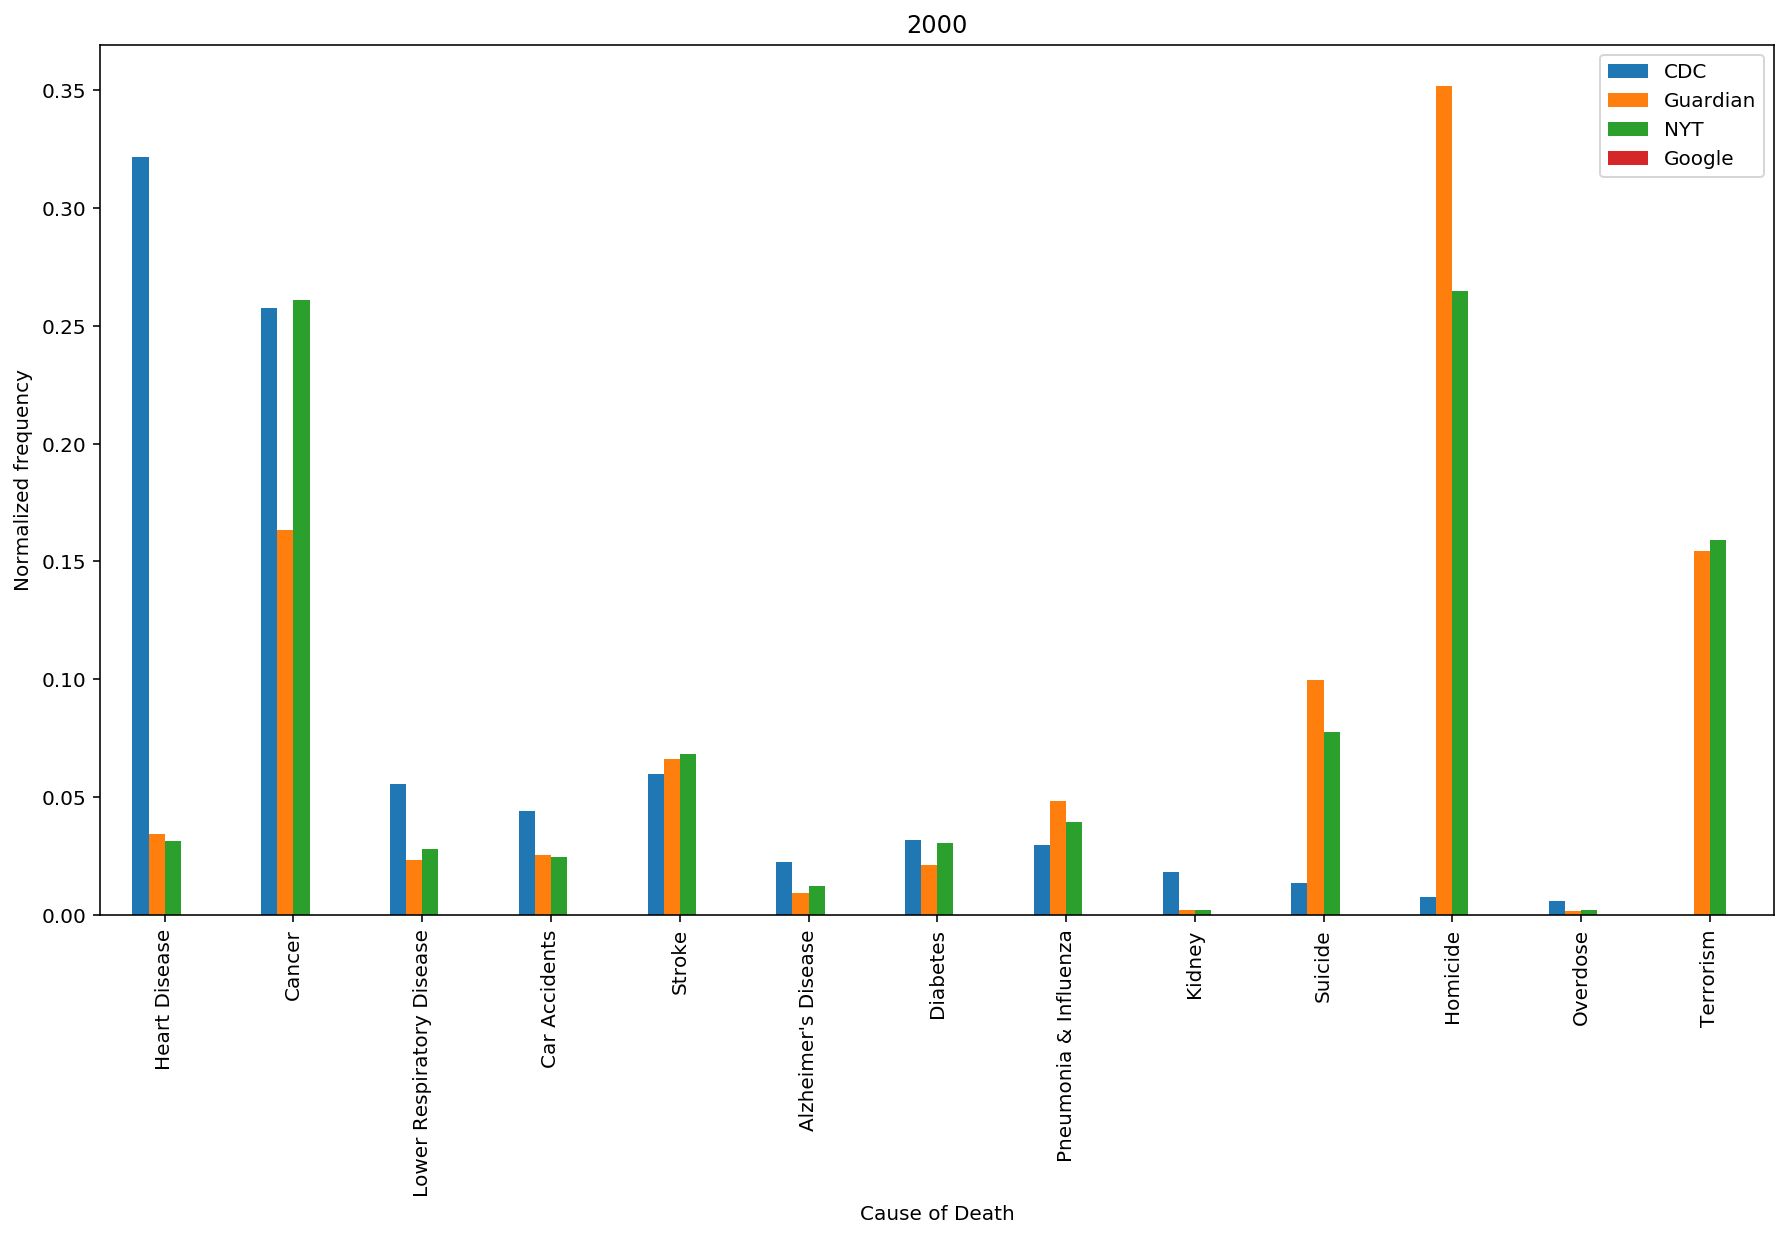

In [59]:
year = 2000
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2001')

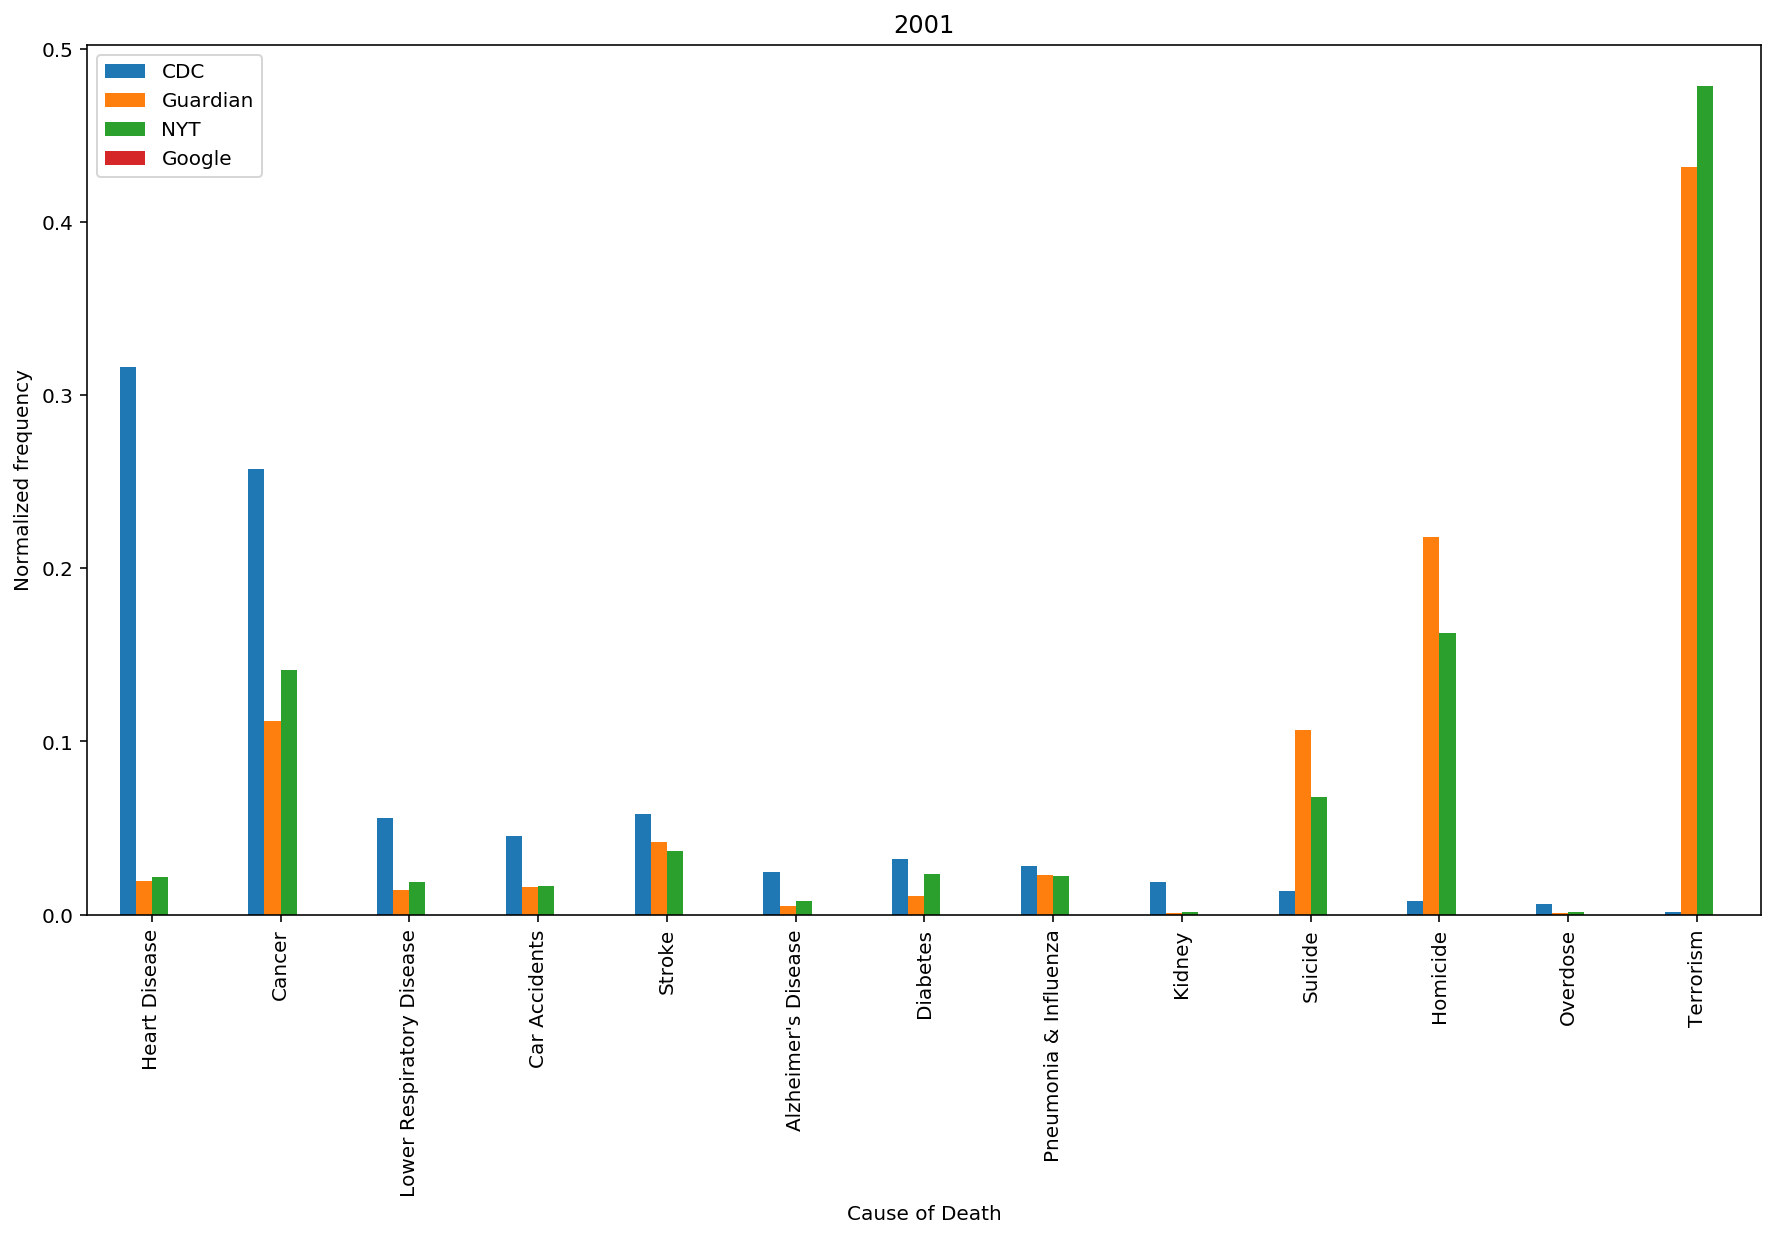

In [60]:
year = 2001
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

In 2001 the "Normalized frequency" scale has changed back to the same as the generalized macro trends to accommodate the increase in reporting on terrorism. We can see the same trend continues below:

Text(0.5,1,'2002')

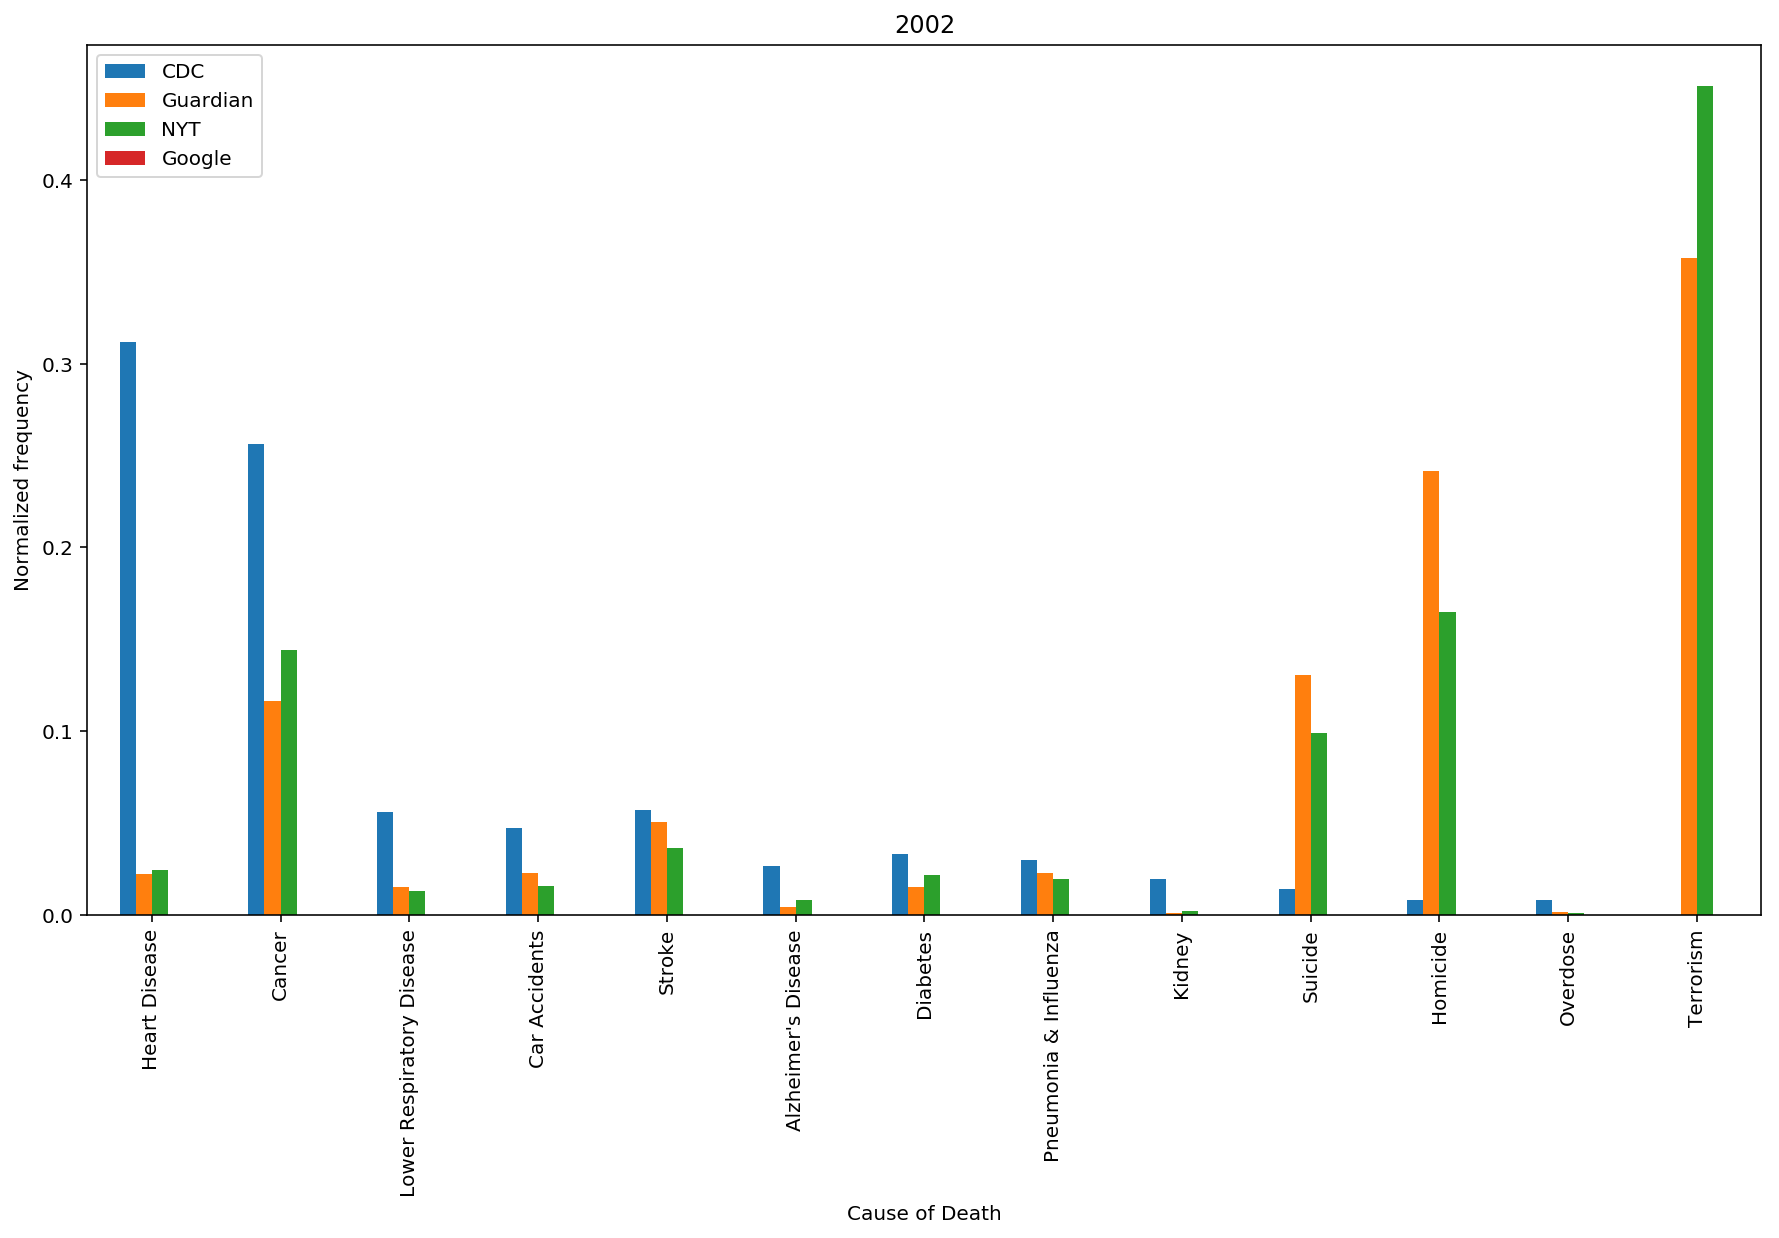

In [61]:
year = 2002
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2003')

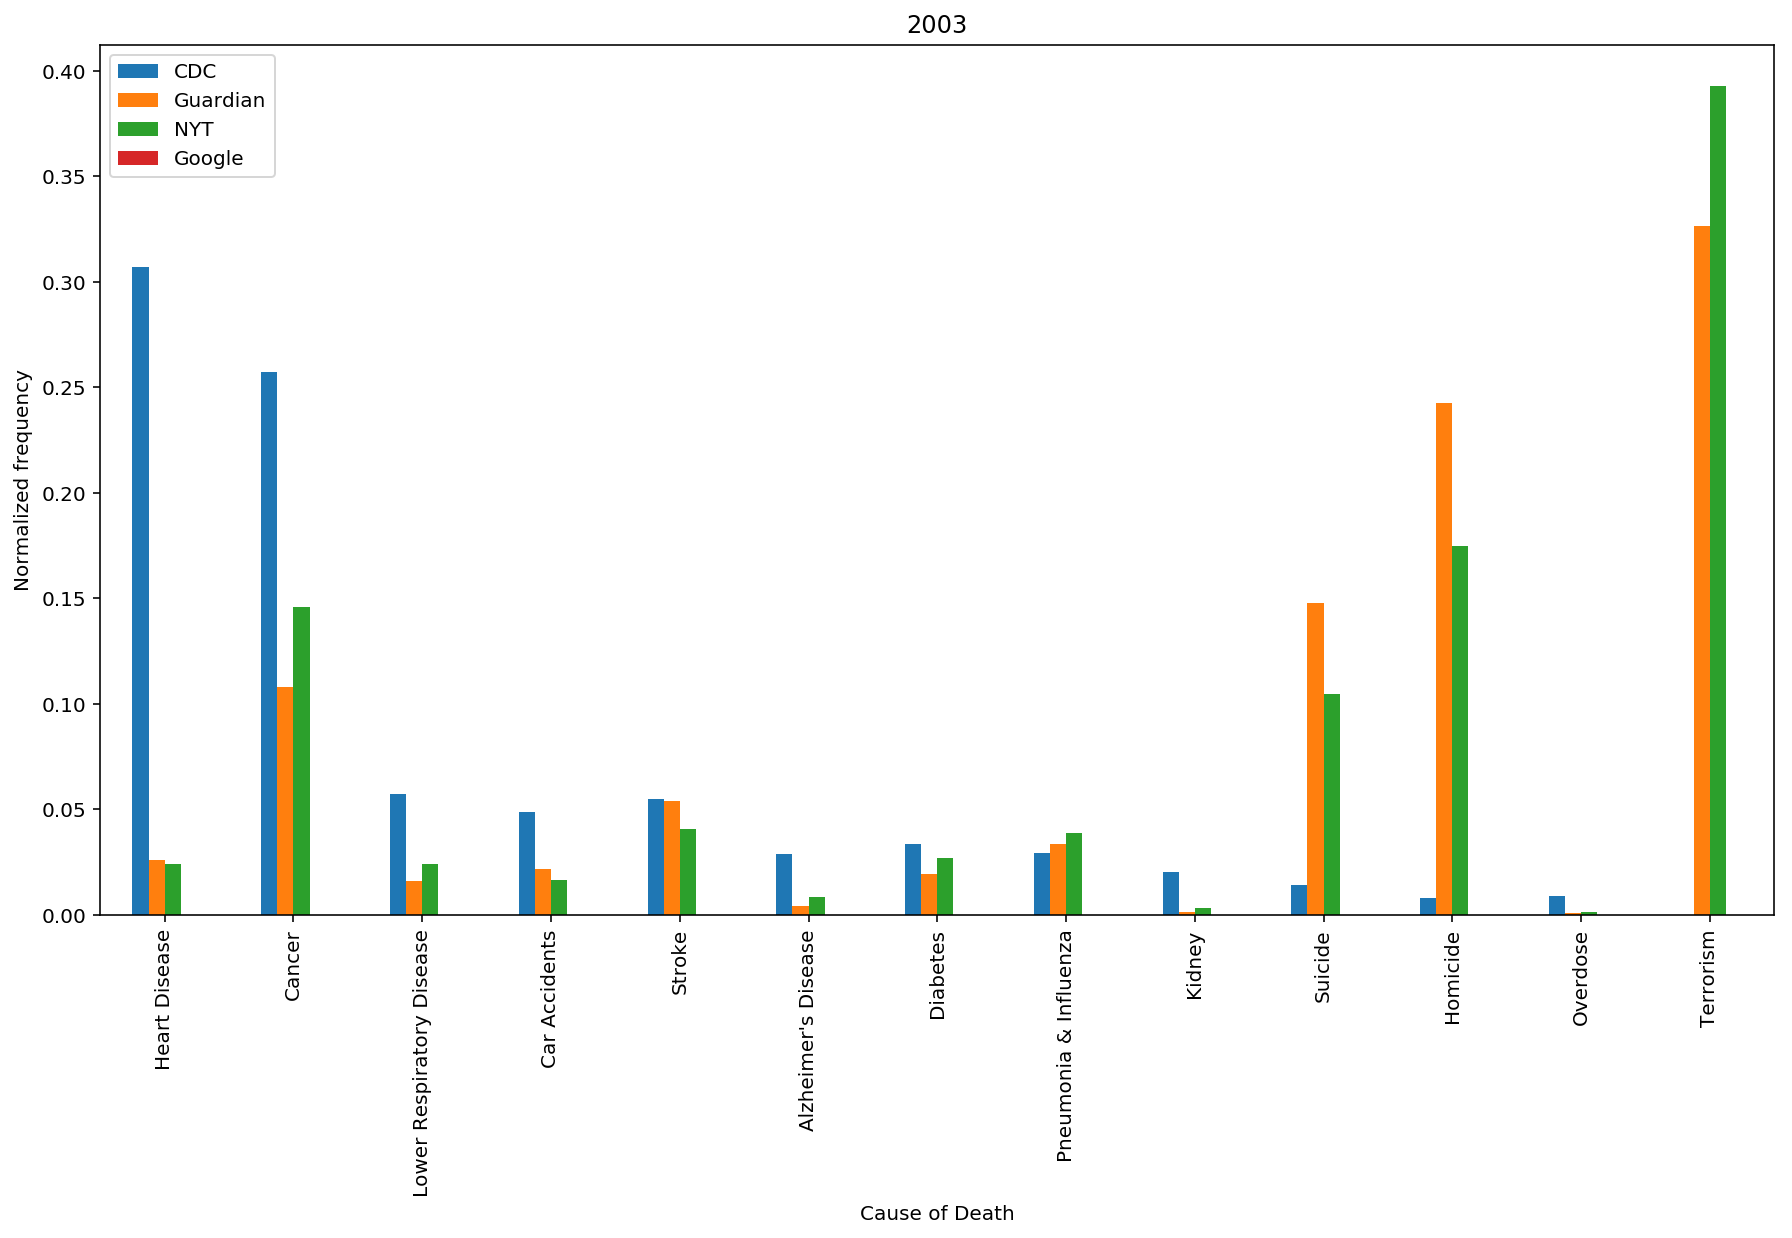

In [62]:
year = 2003
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2004')

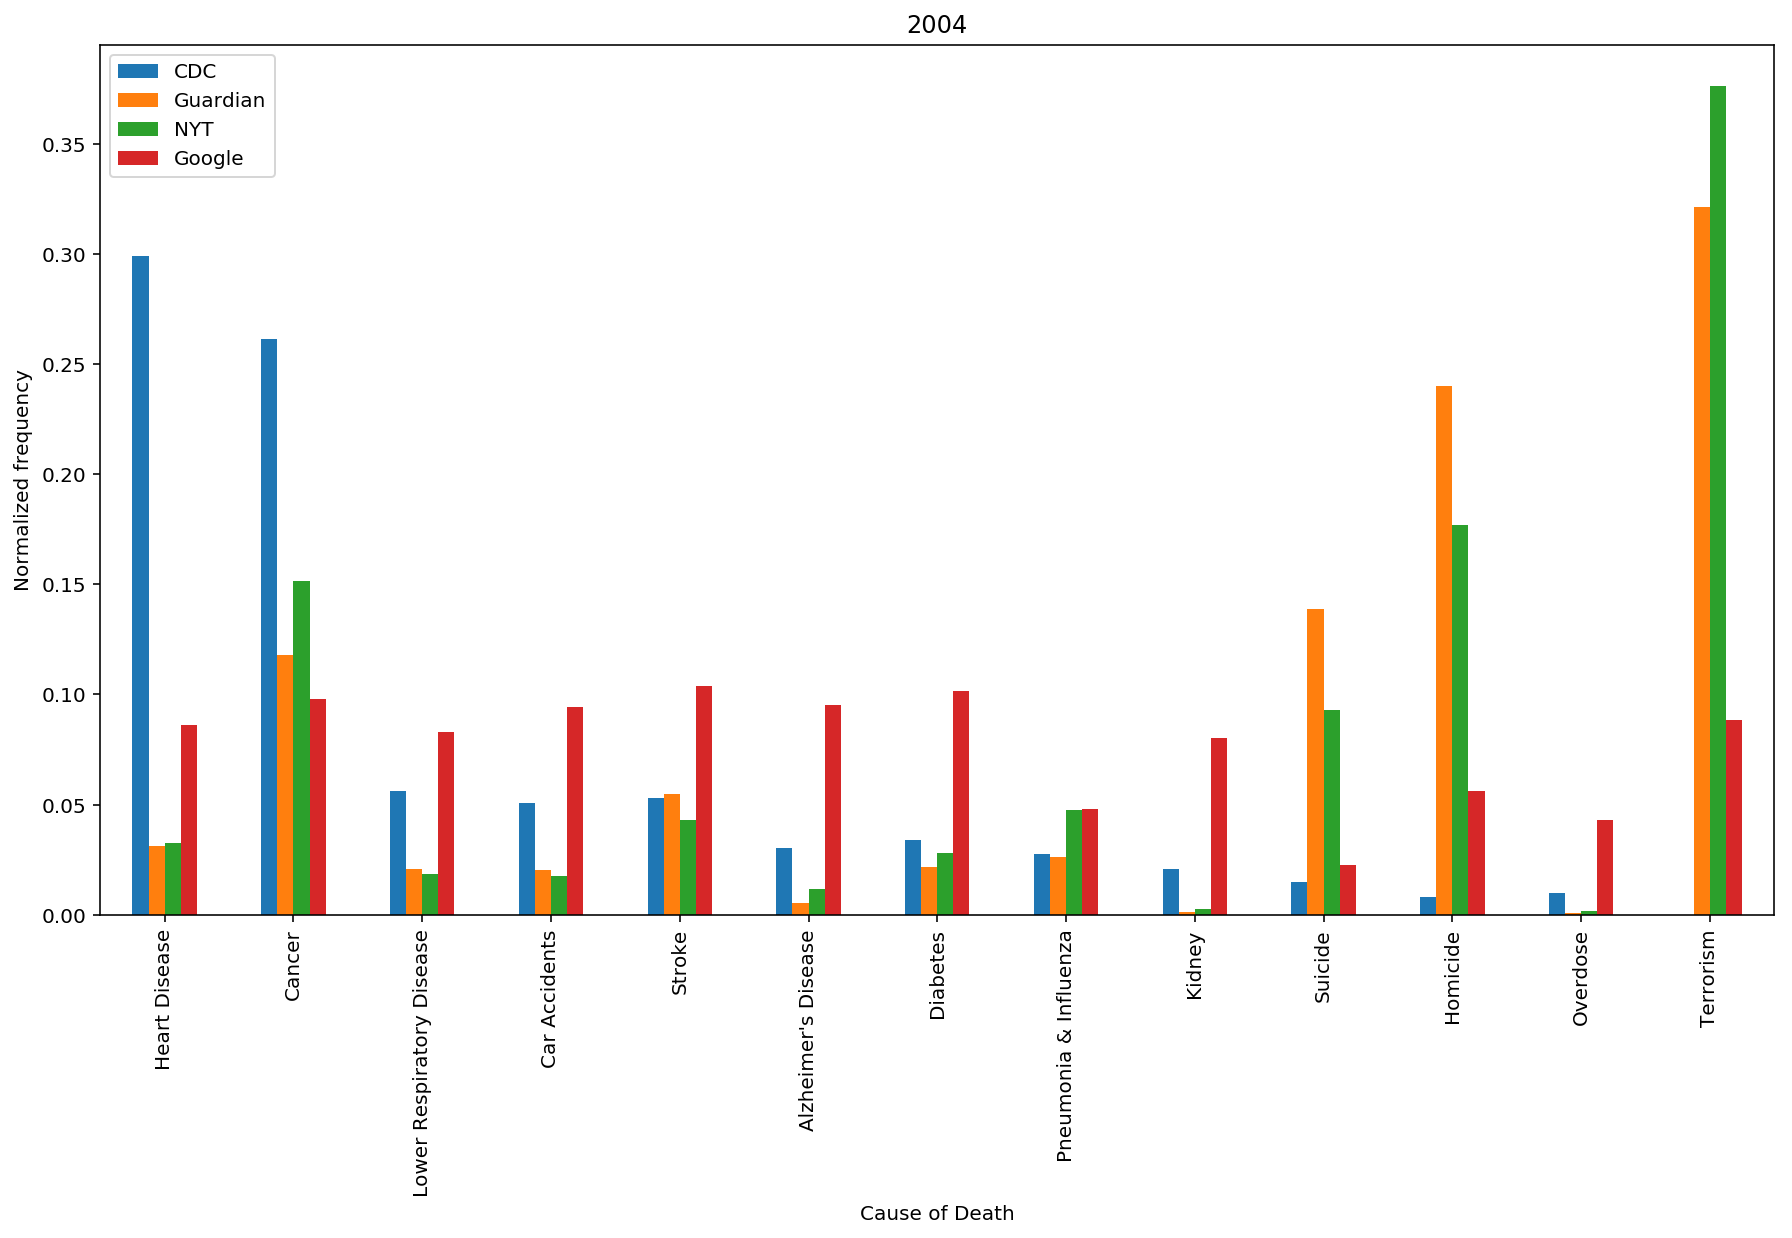

In [63]:
year = 2004
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

2004 is the first year Google Trends data is available and it appears to follow different patterns than our traditional news sources. Also note that the scale for "Normalized frequency" is again dropping.

Text(0.5,1,'2005')

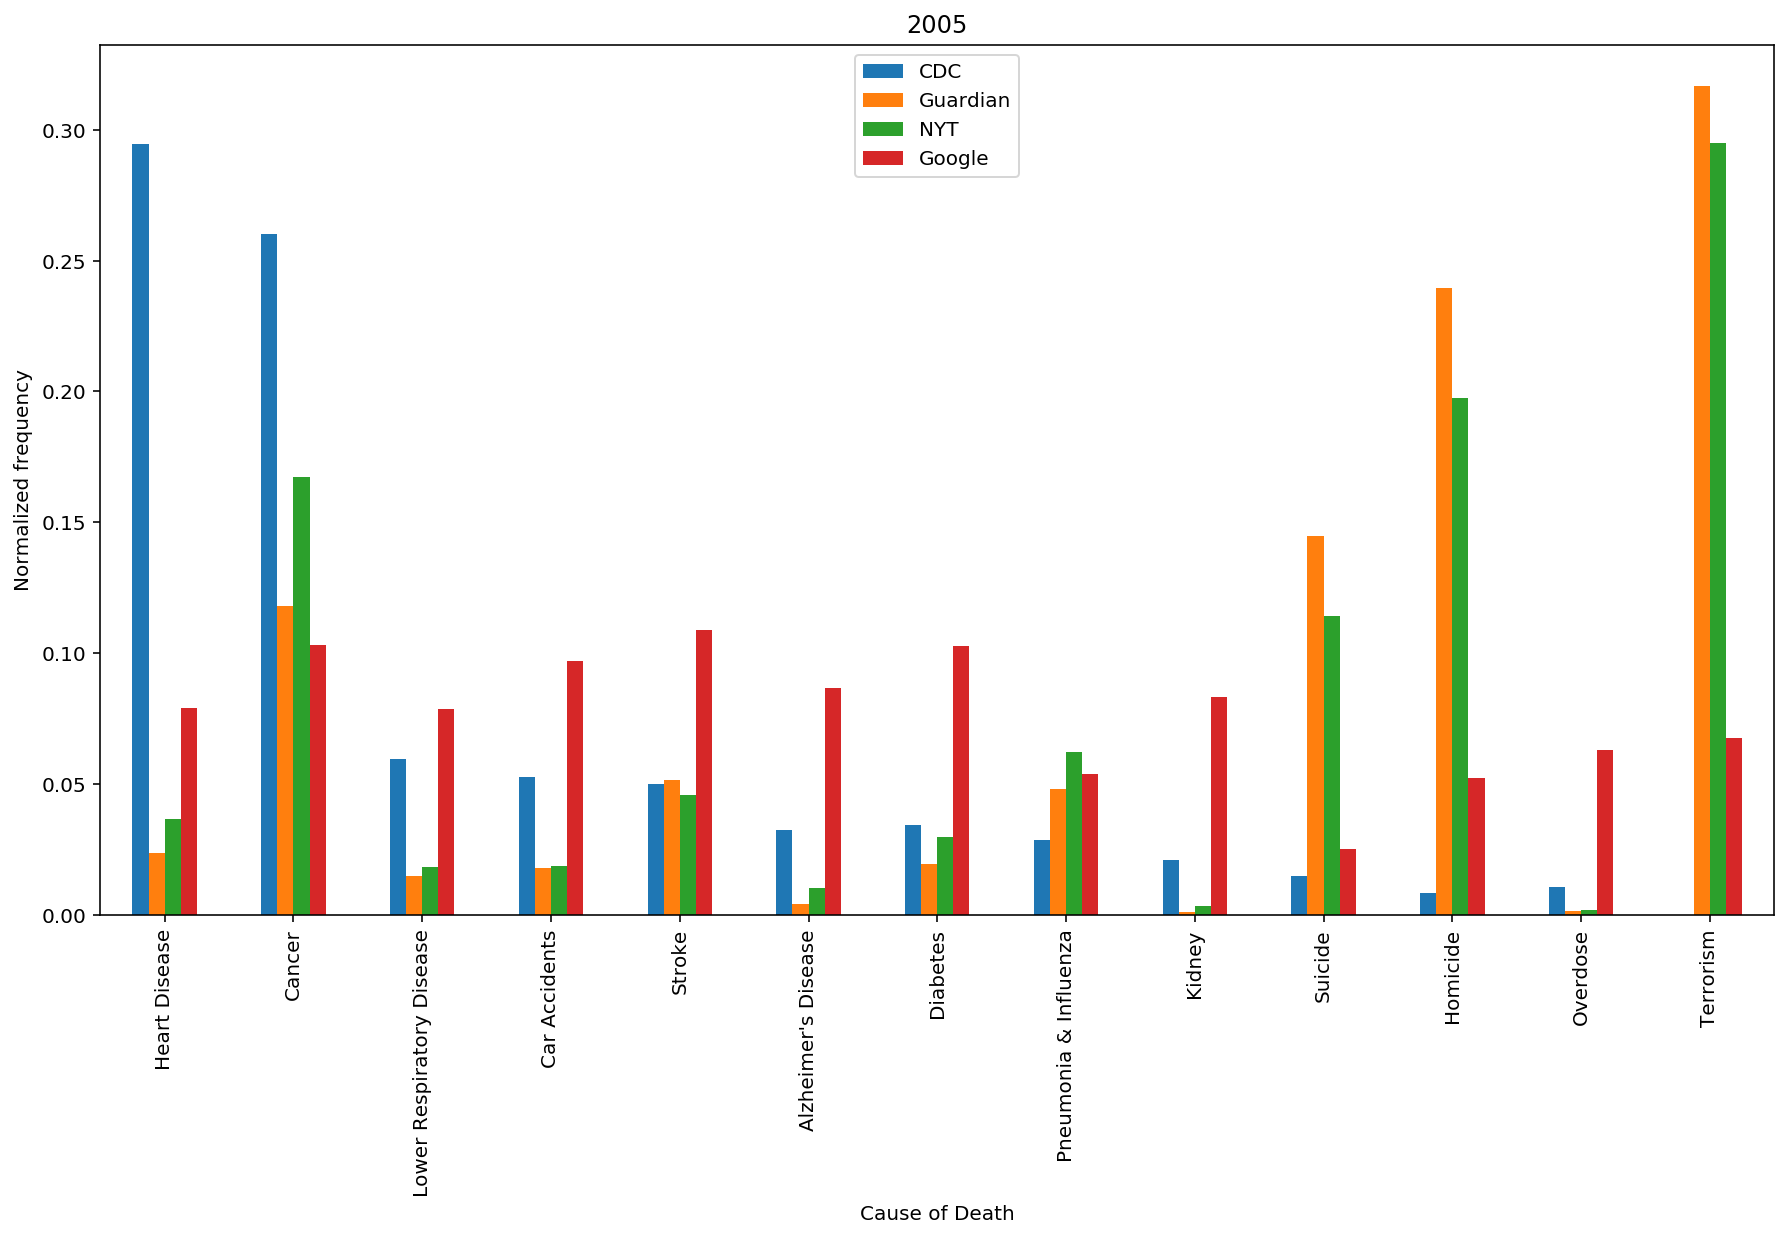

In [64]:
year = 2005
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2006')

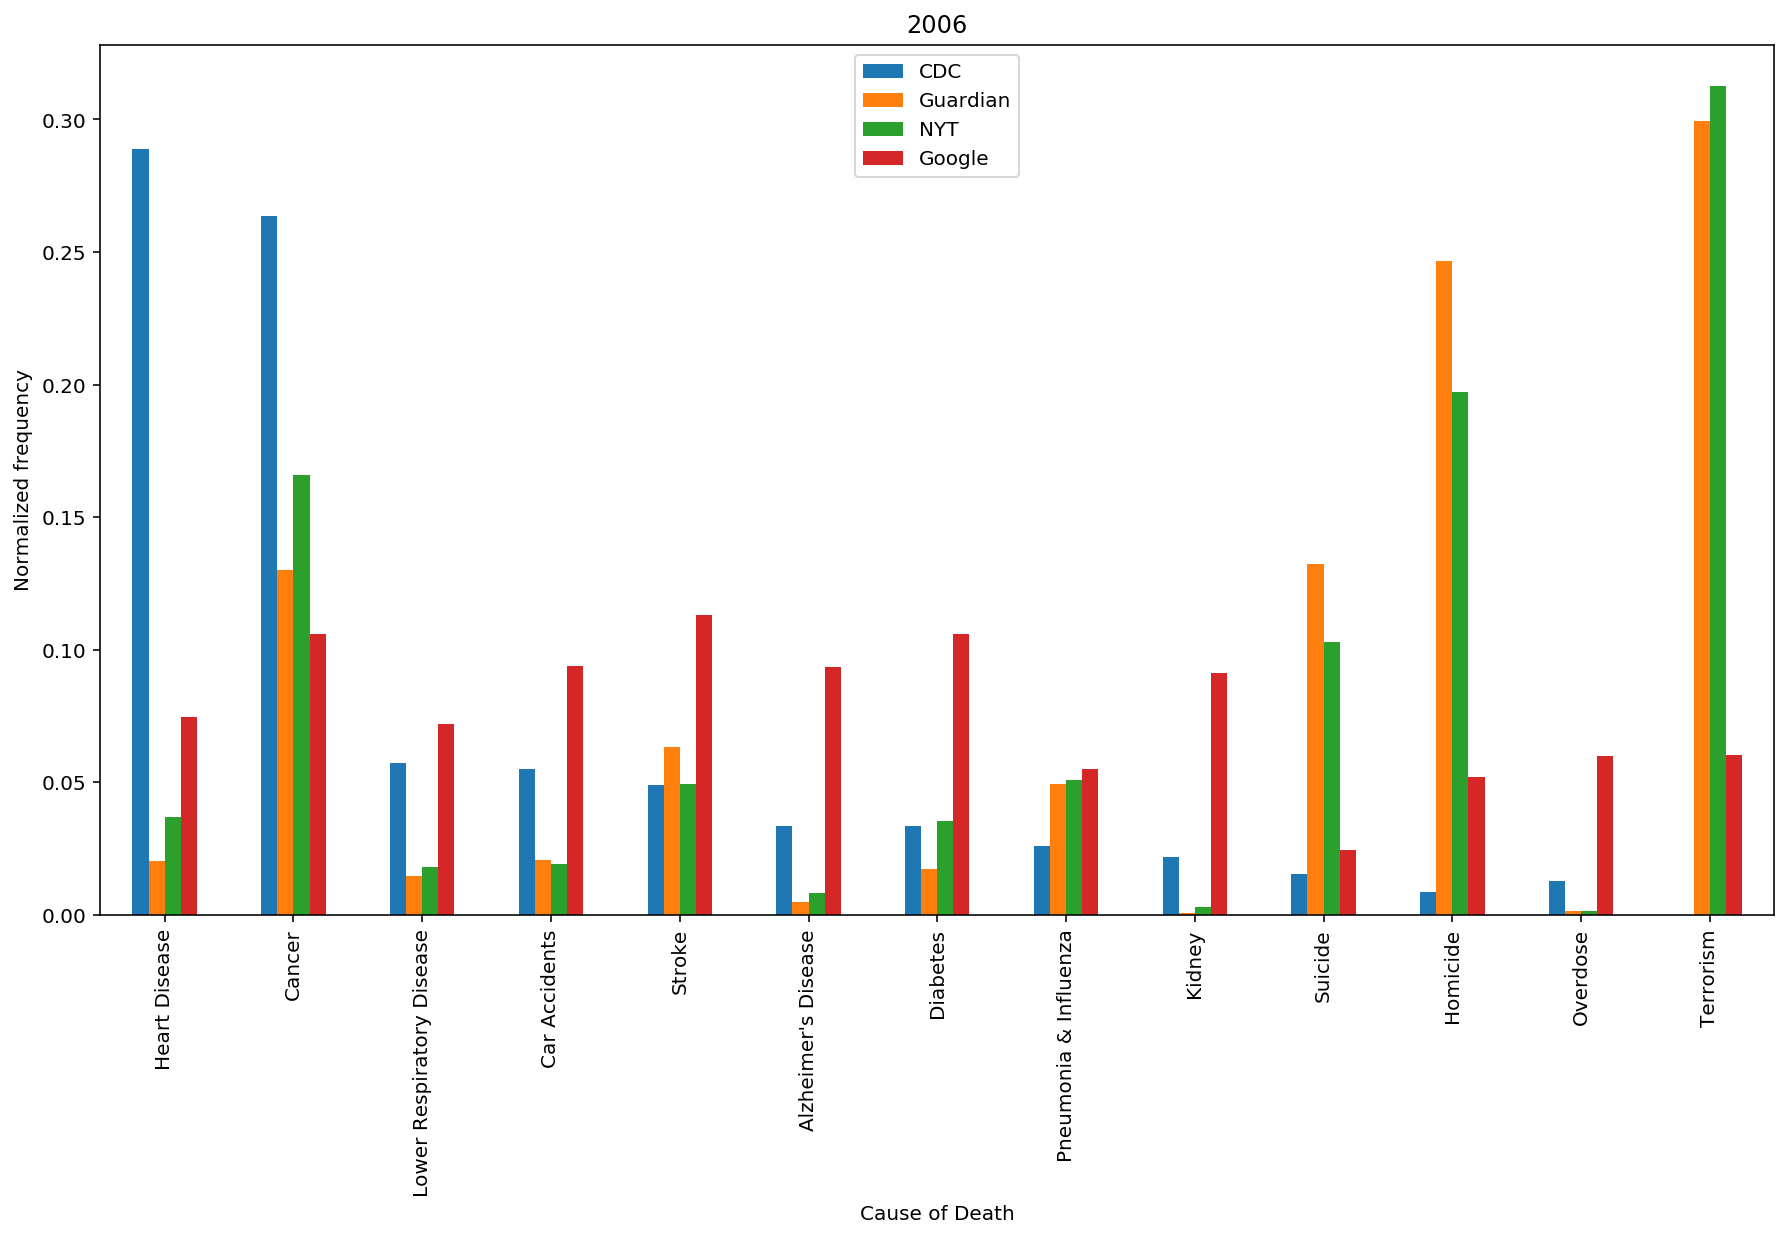

In [65]:
year = 2006
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2007')

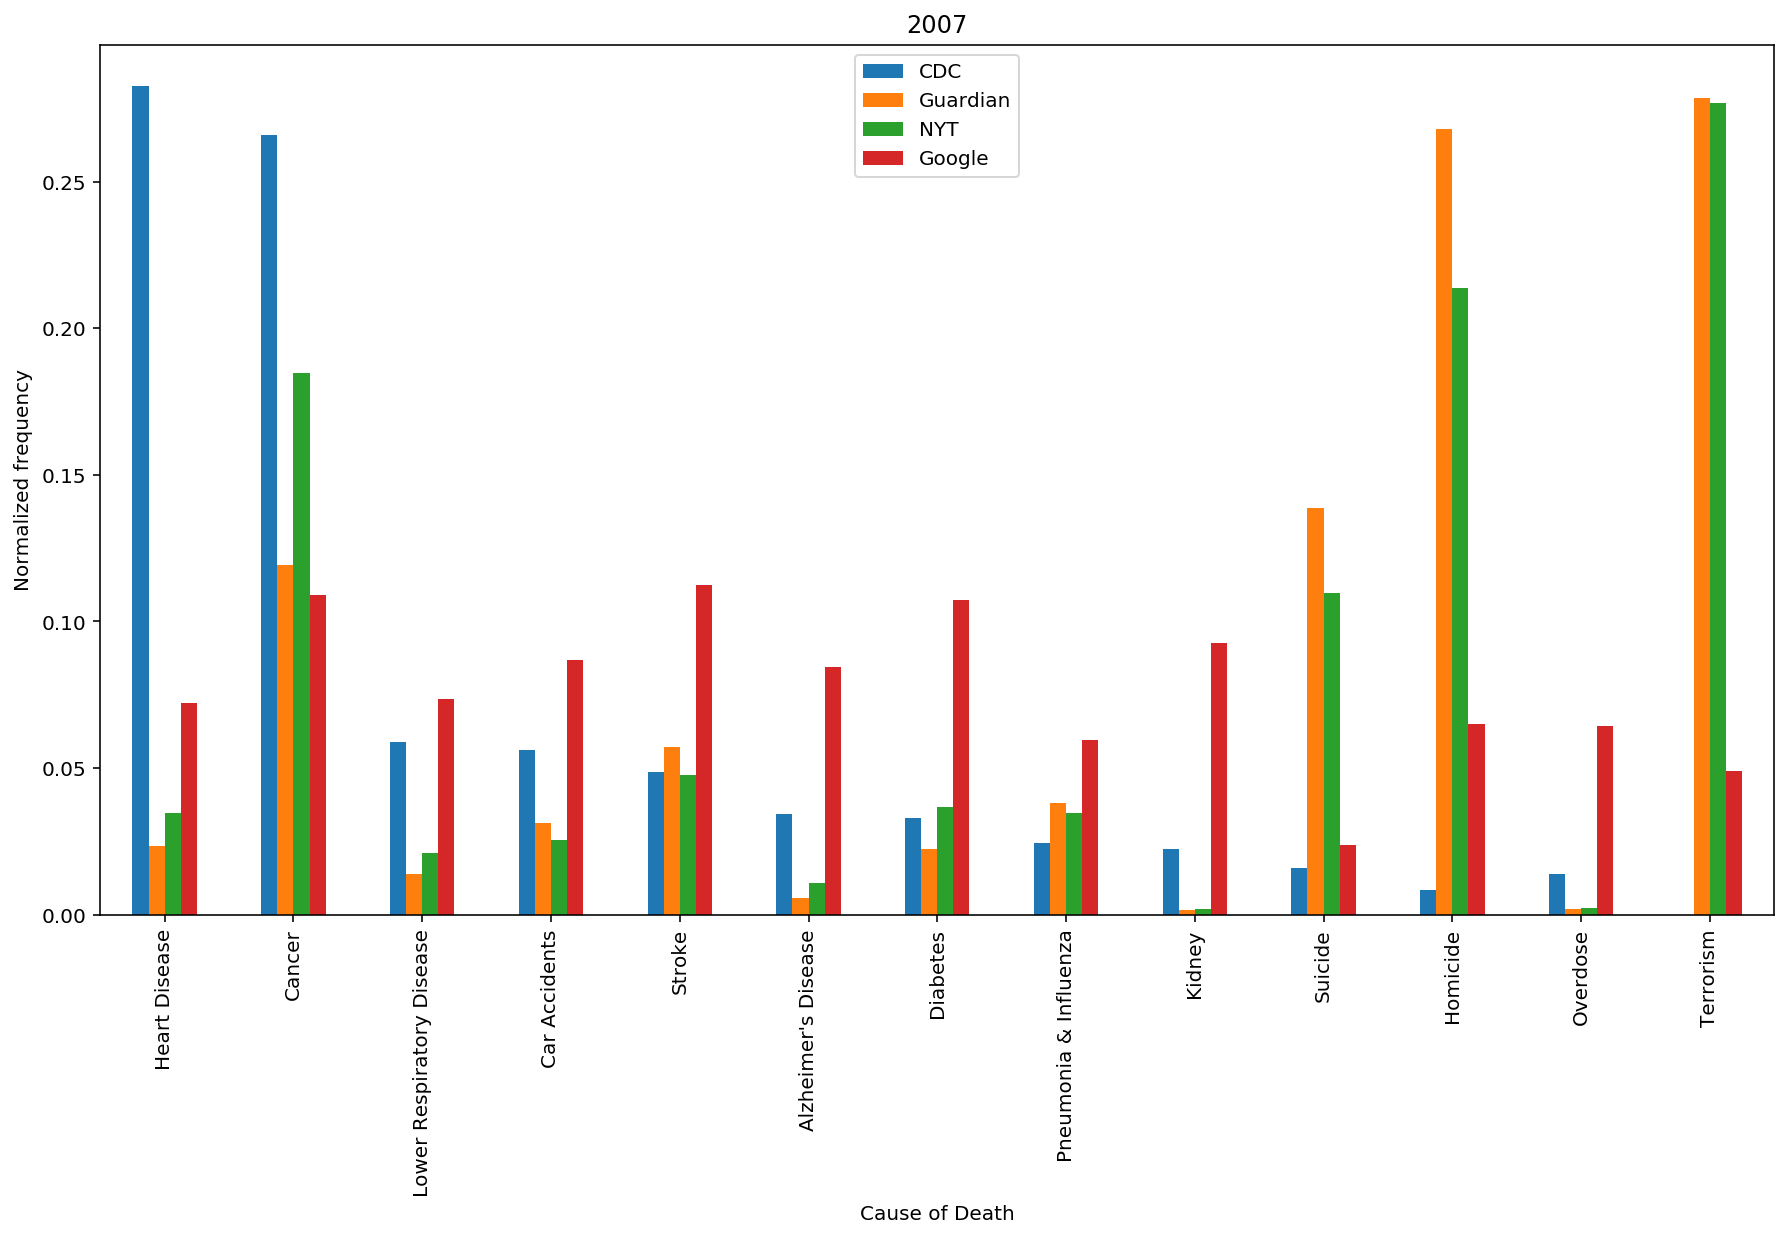

In [66]:
year = 2007
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2008')

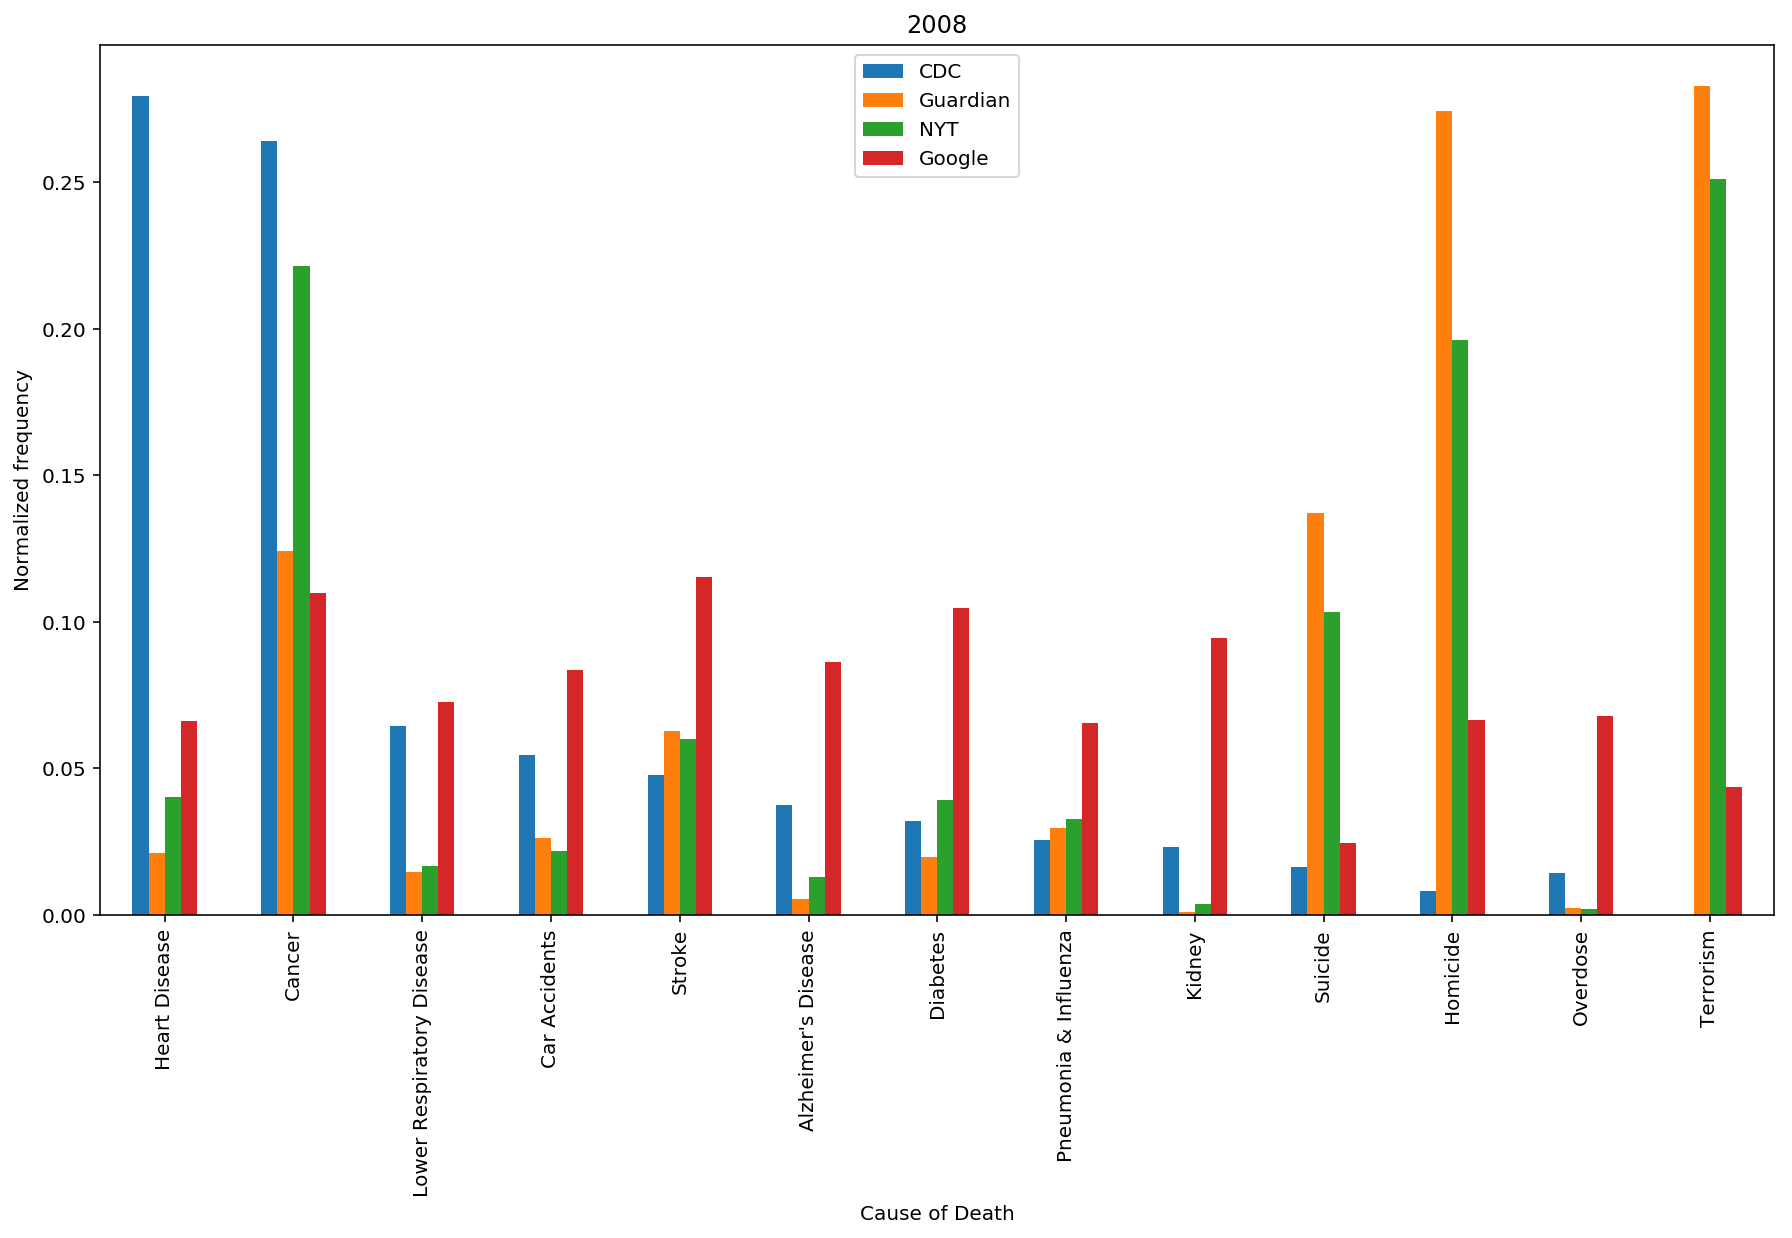

In [67]:
year = 2008
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2009')

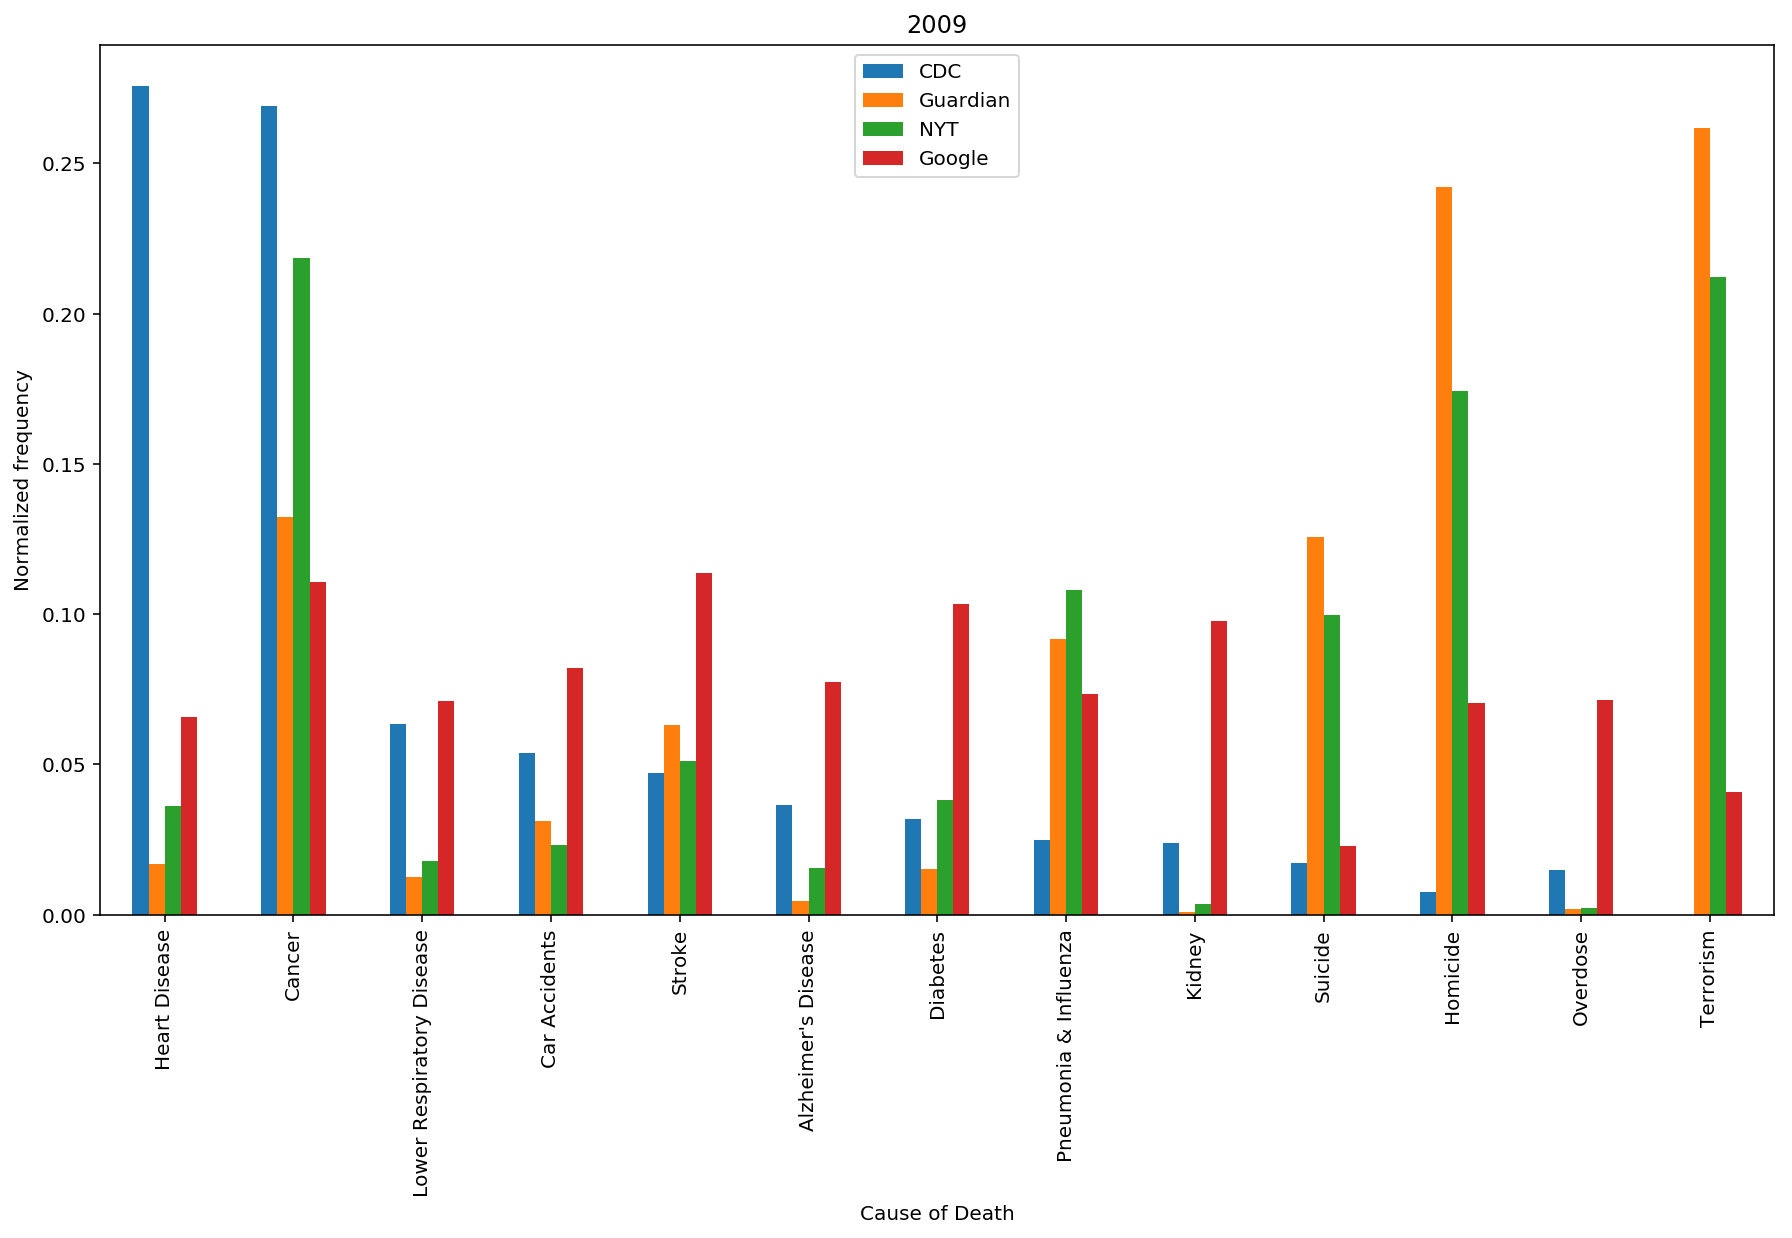

In [68]:
year = 2009
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2010')

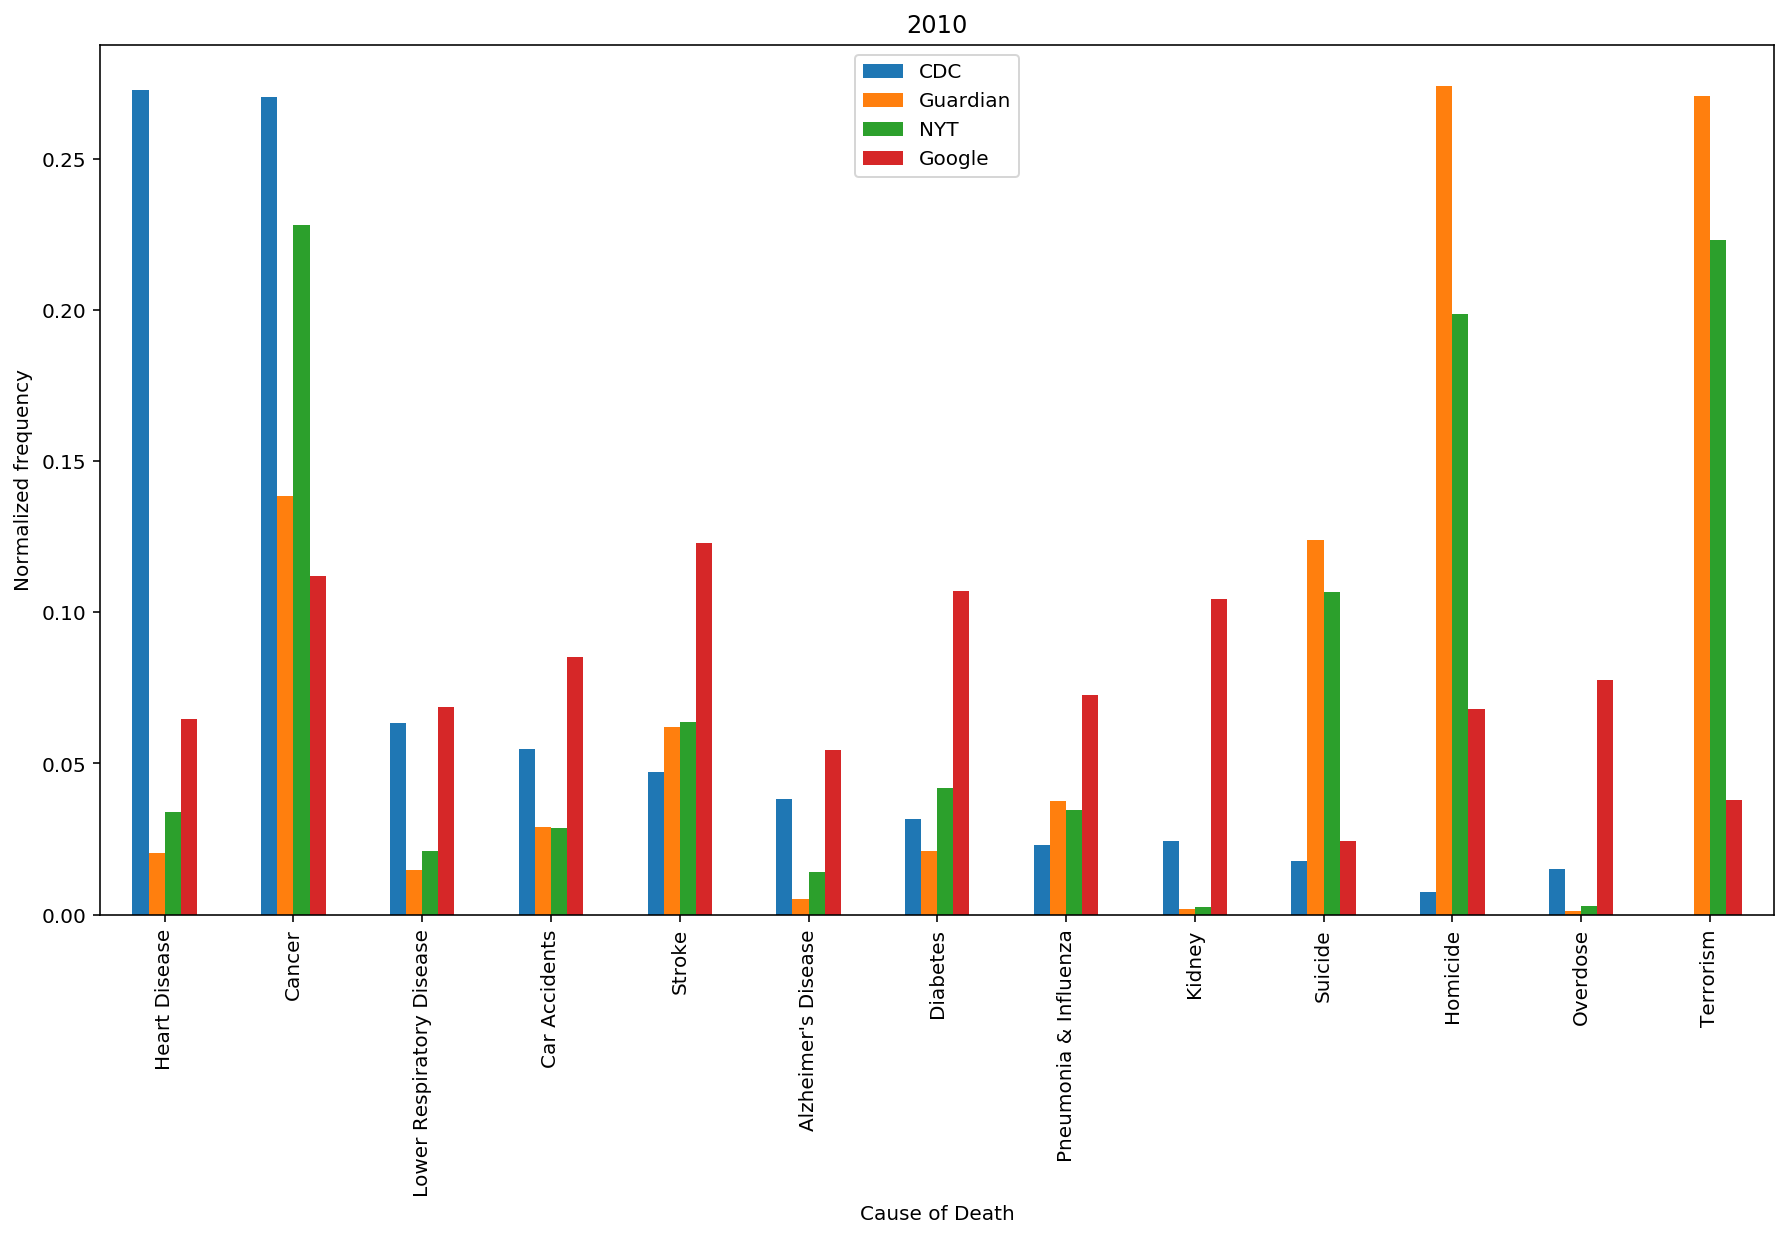

In [69]:
year = 2010
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2011')

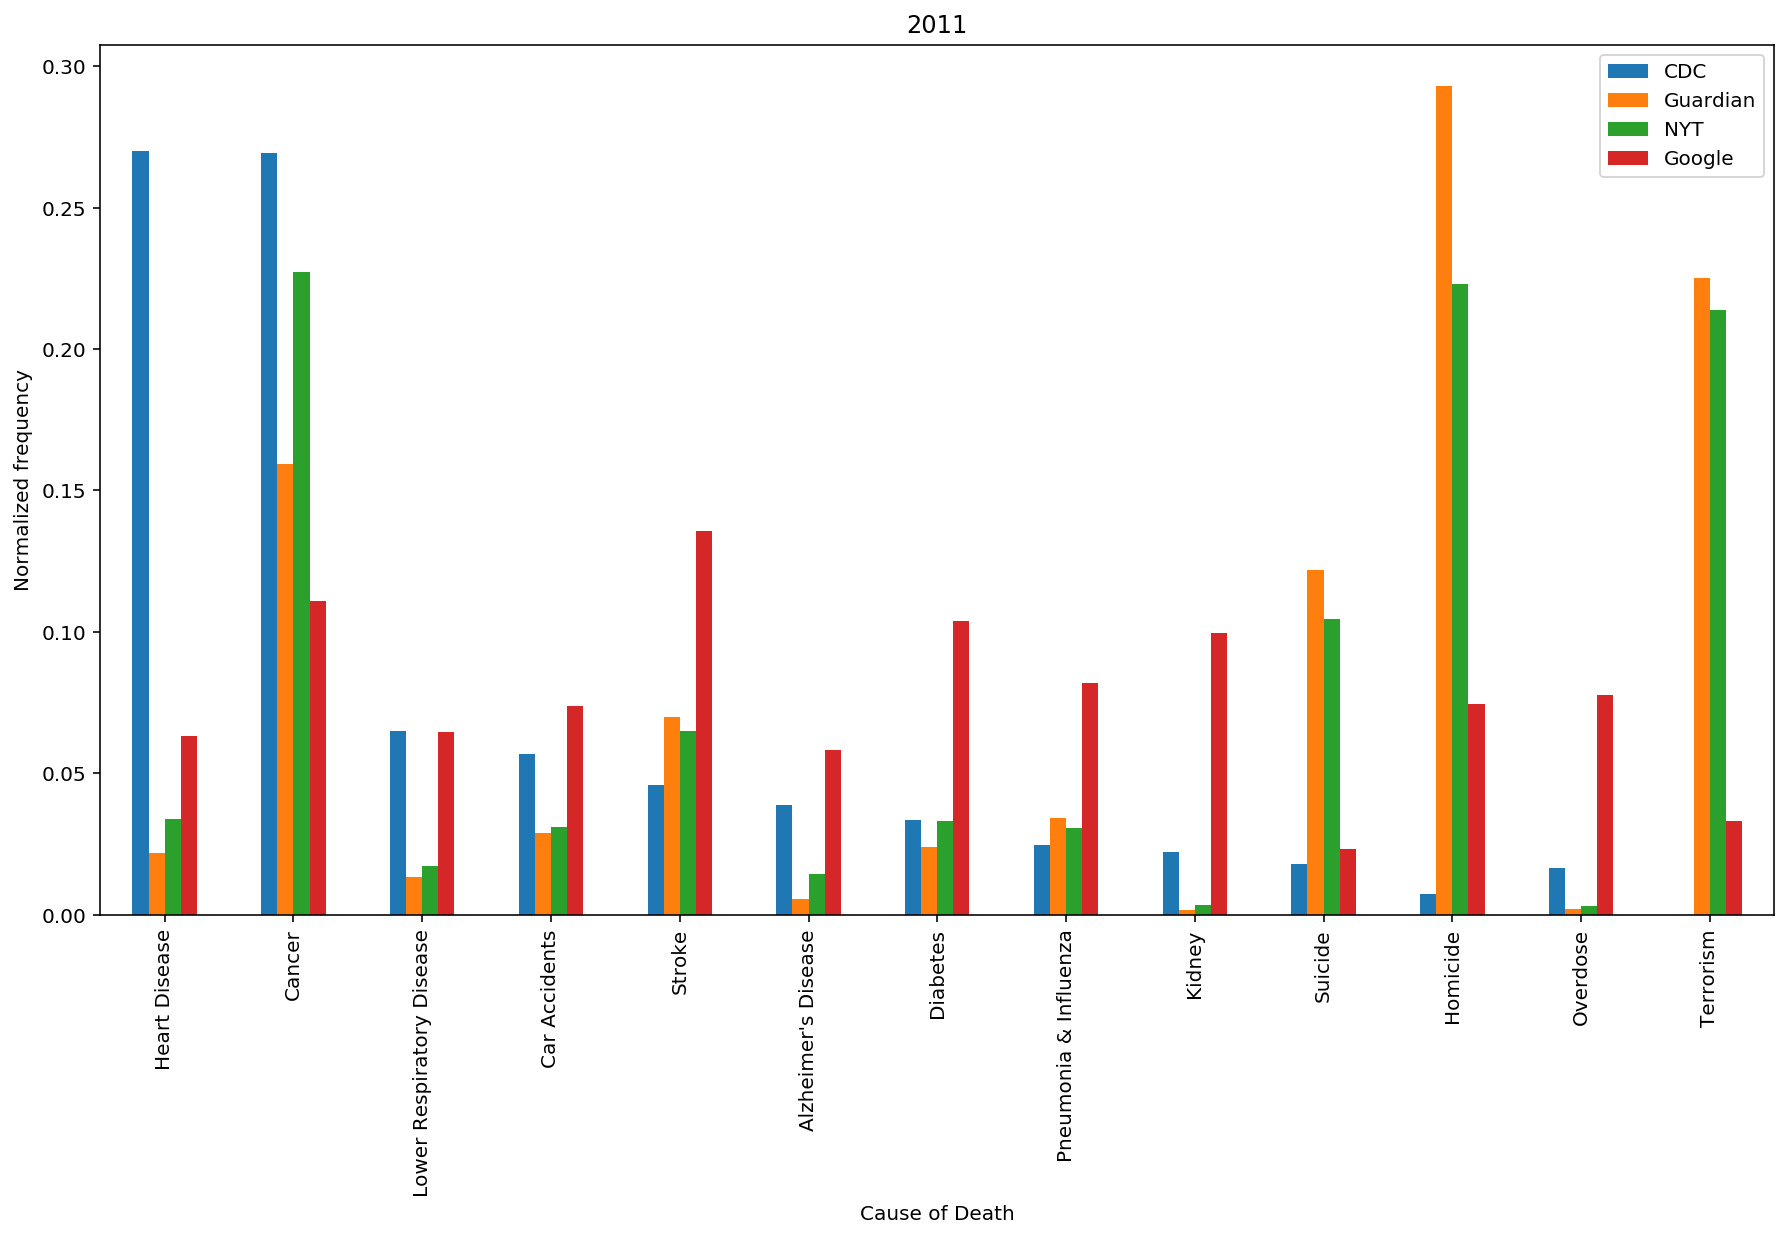

In [70]:
year = 2011
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2012')

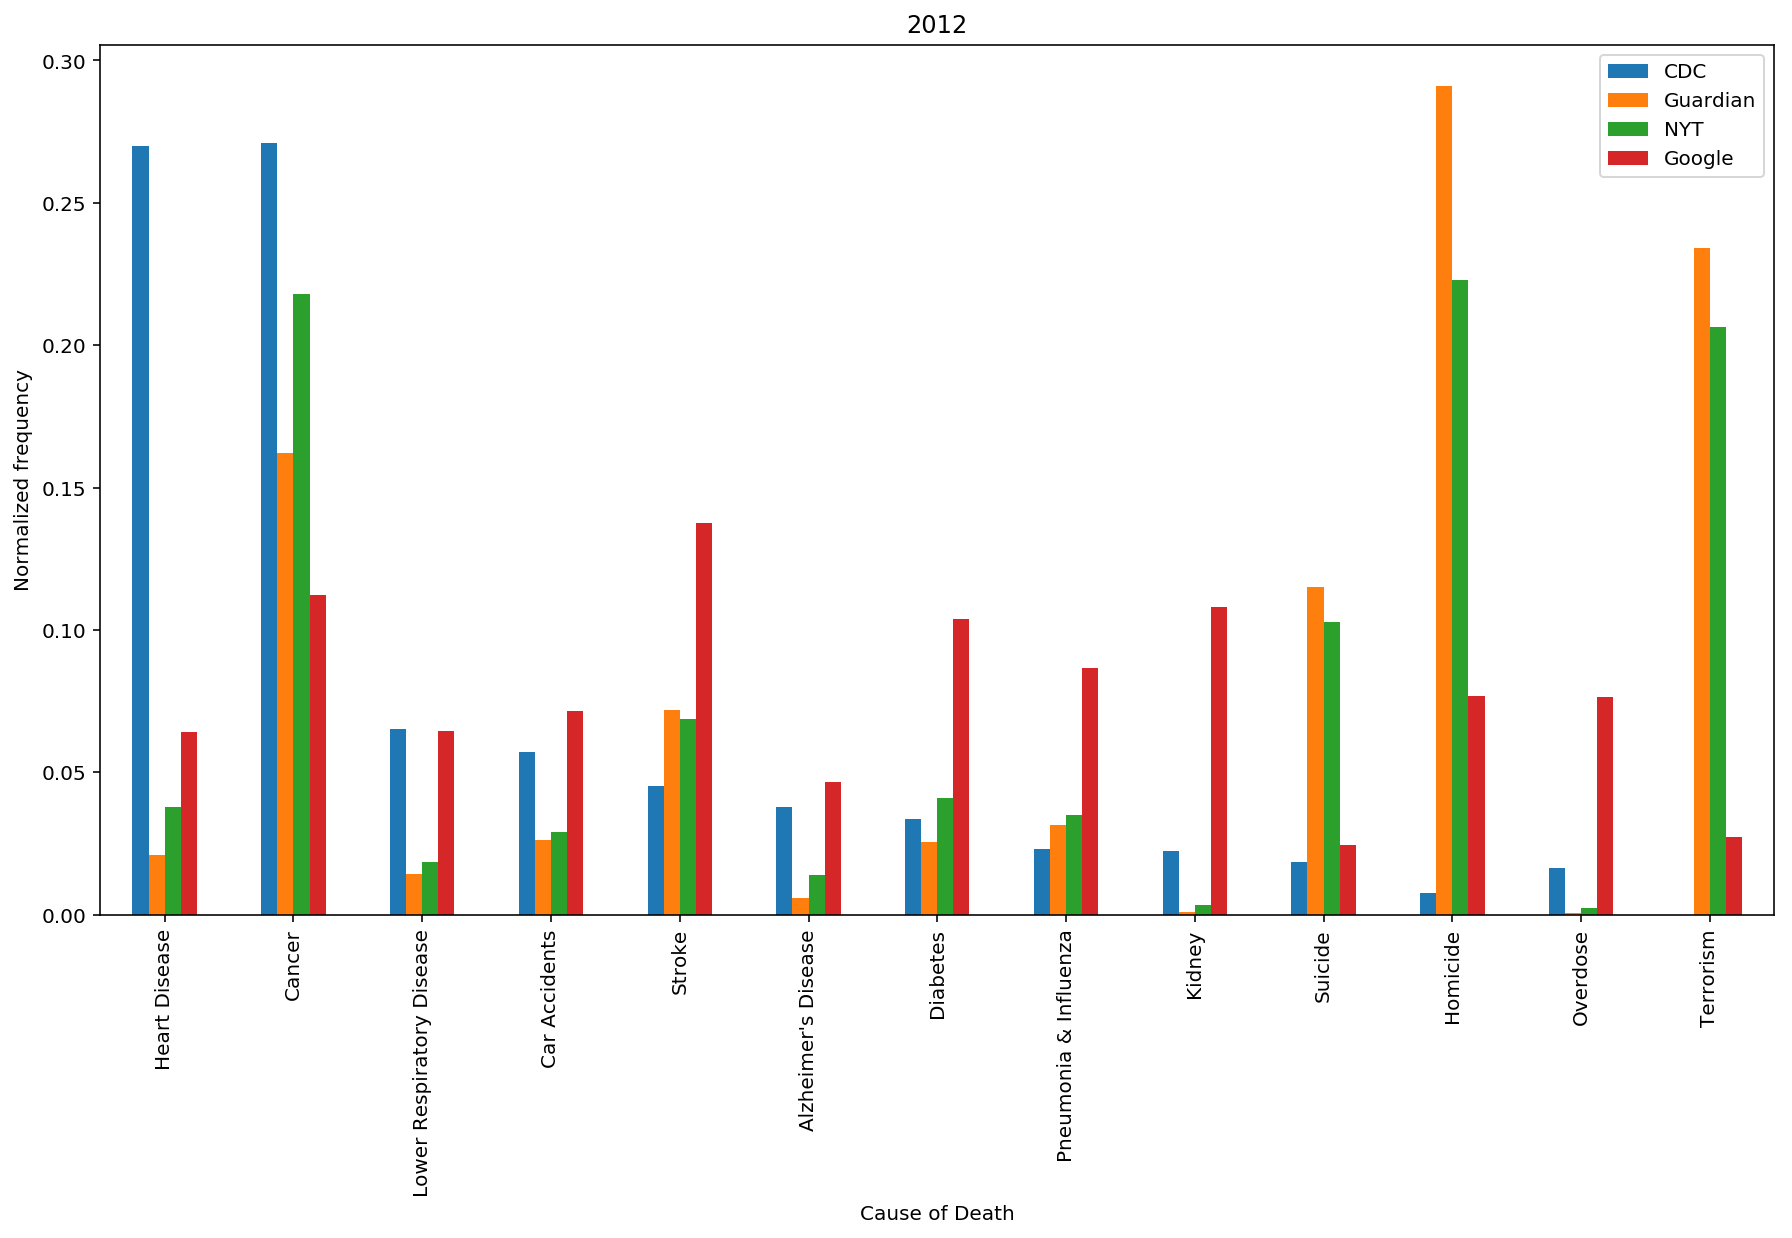

In [71]:
year = 2012
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2013')

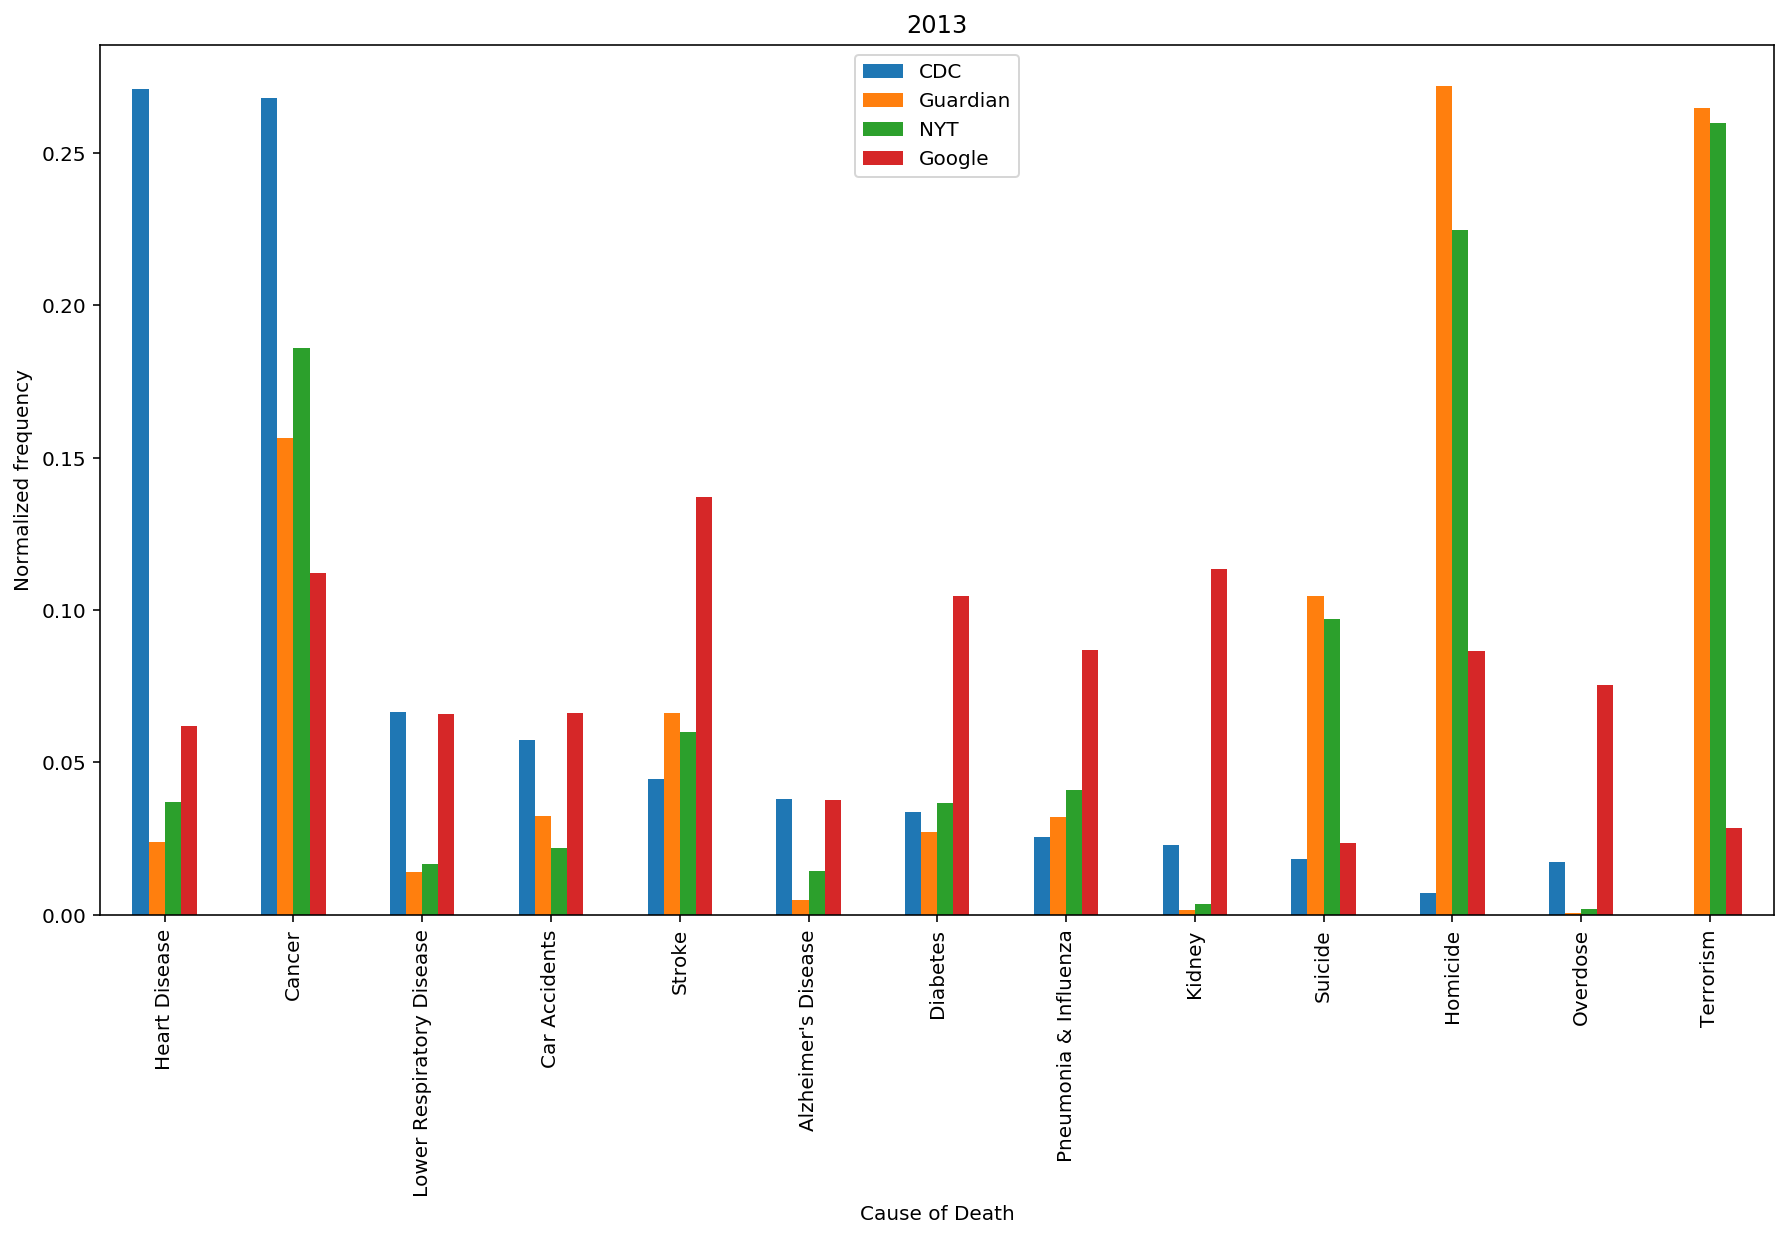

In [72]:
year = 2013
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2014')

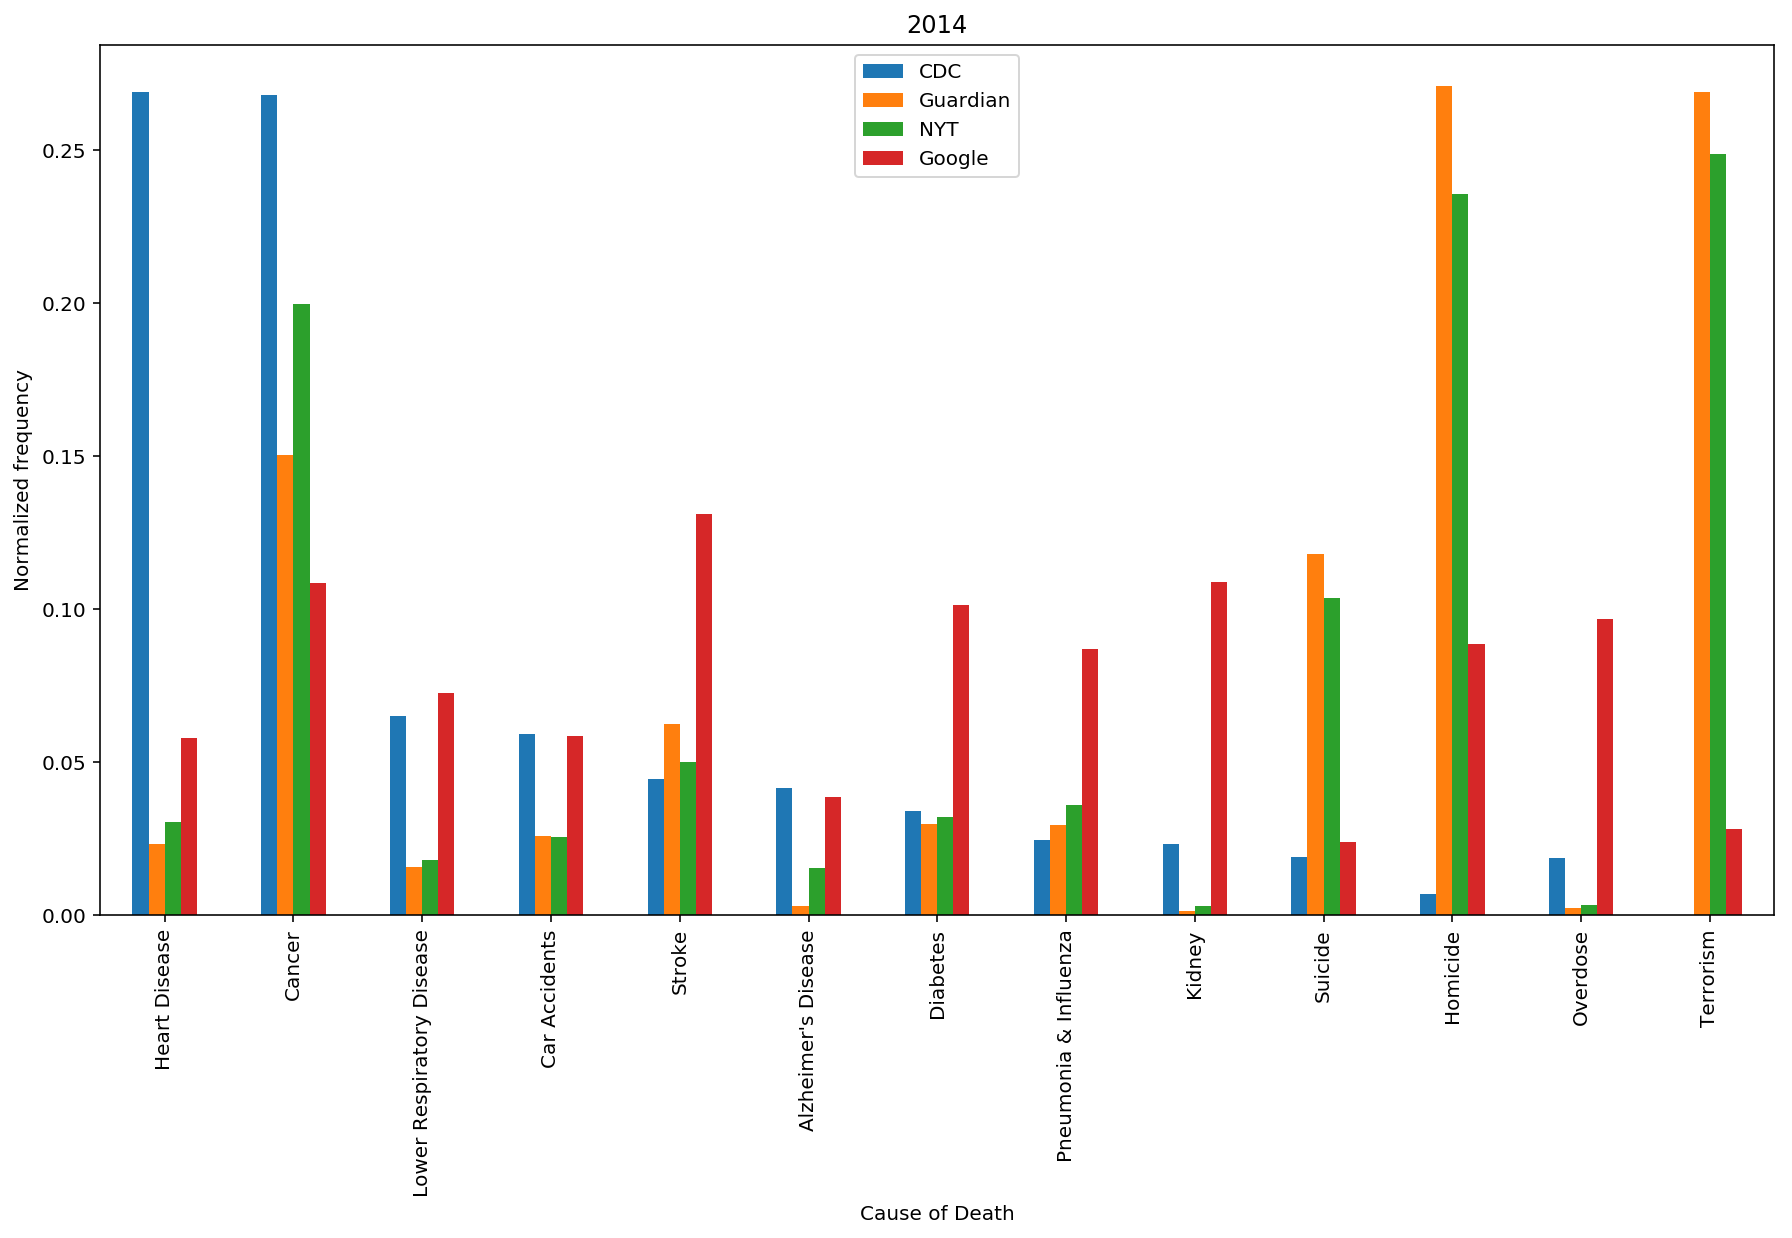

In [73]:
year = 2014
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2015')

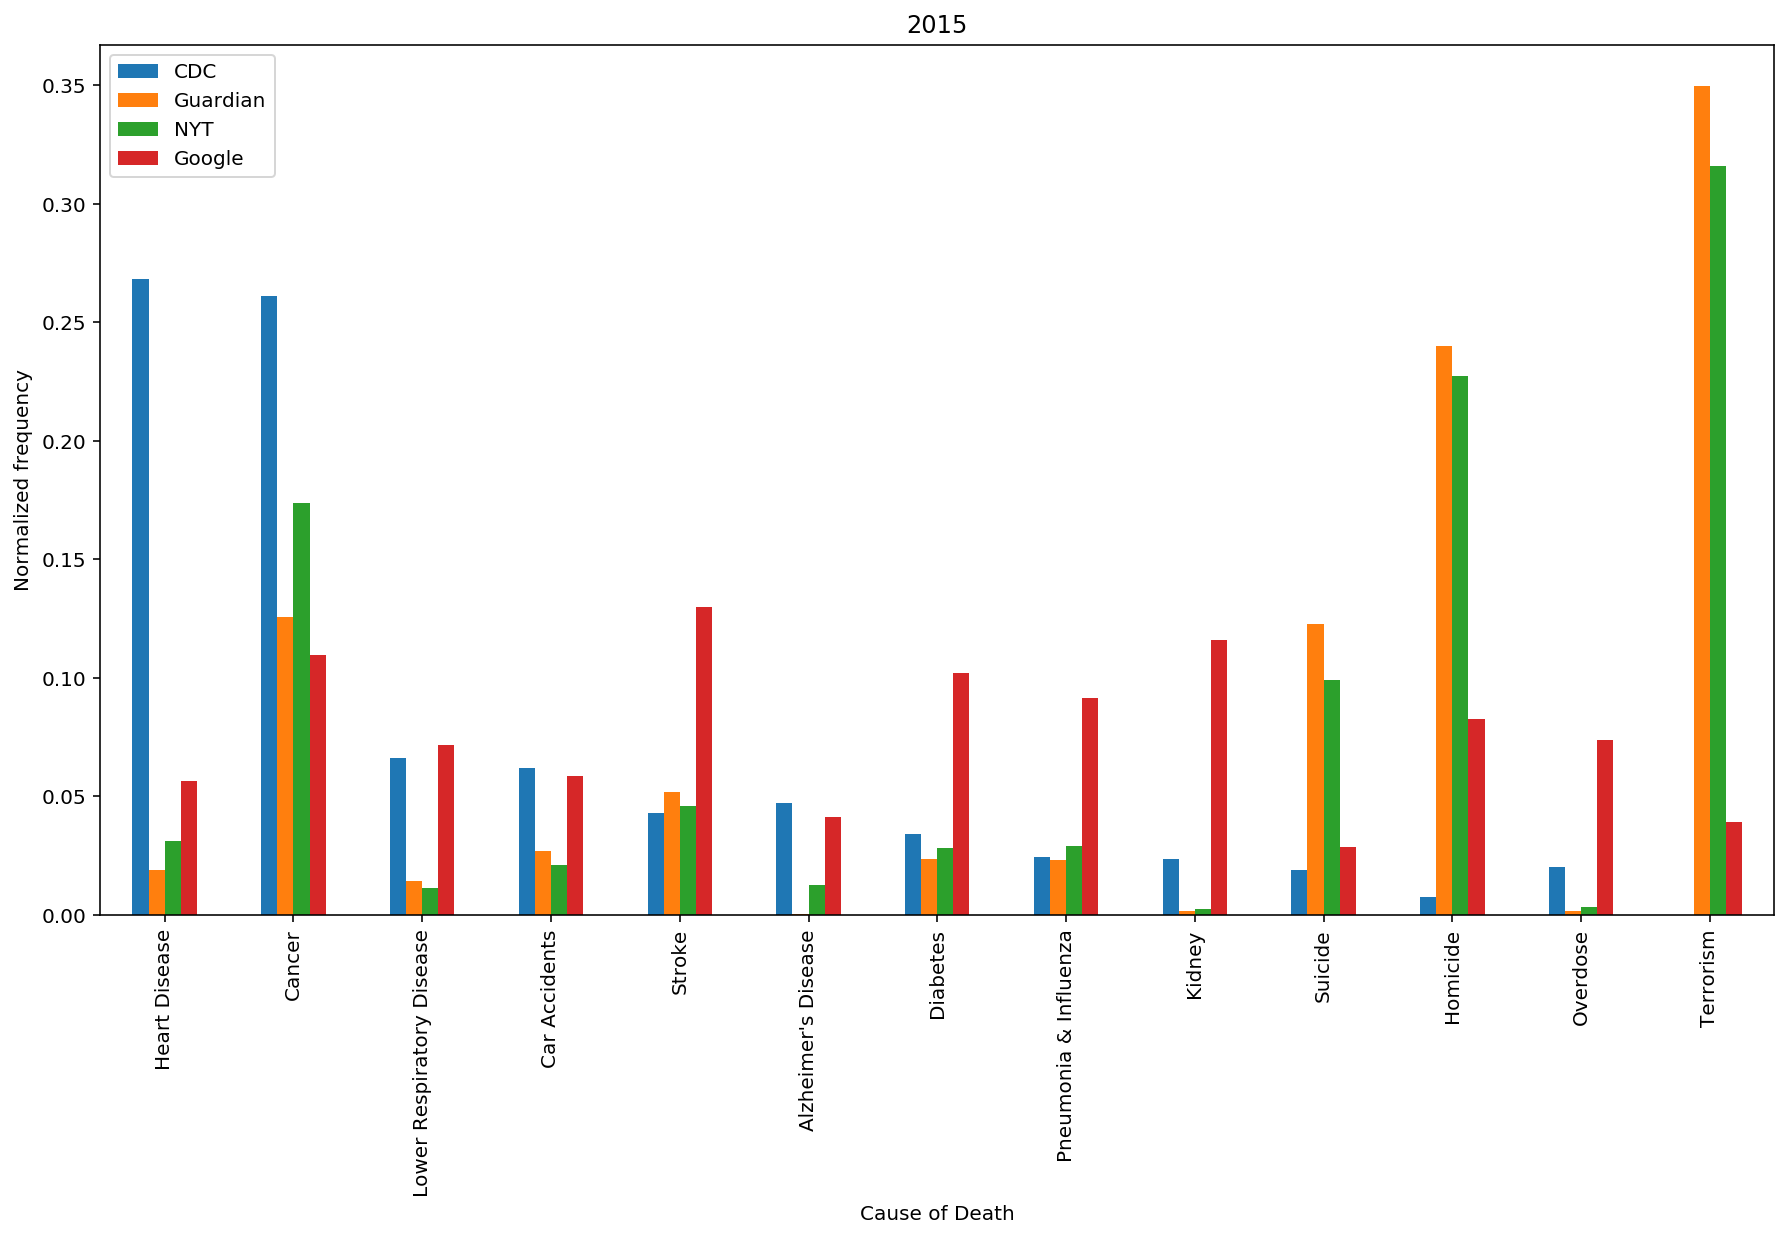

In [74]:
year = 2015
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

Text(0.5,1,'2016')

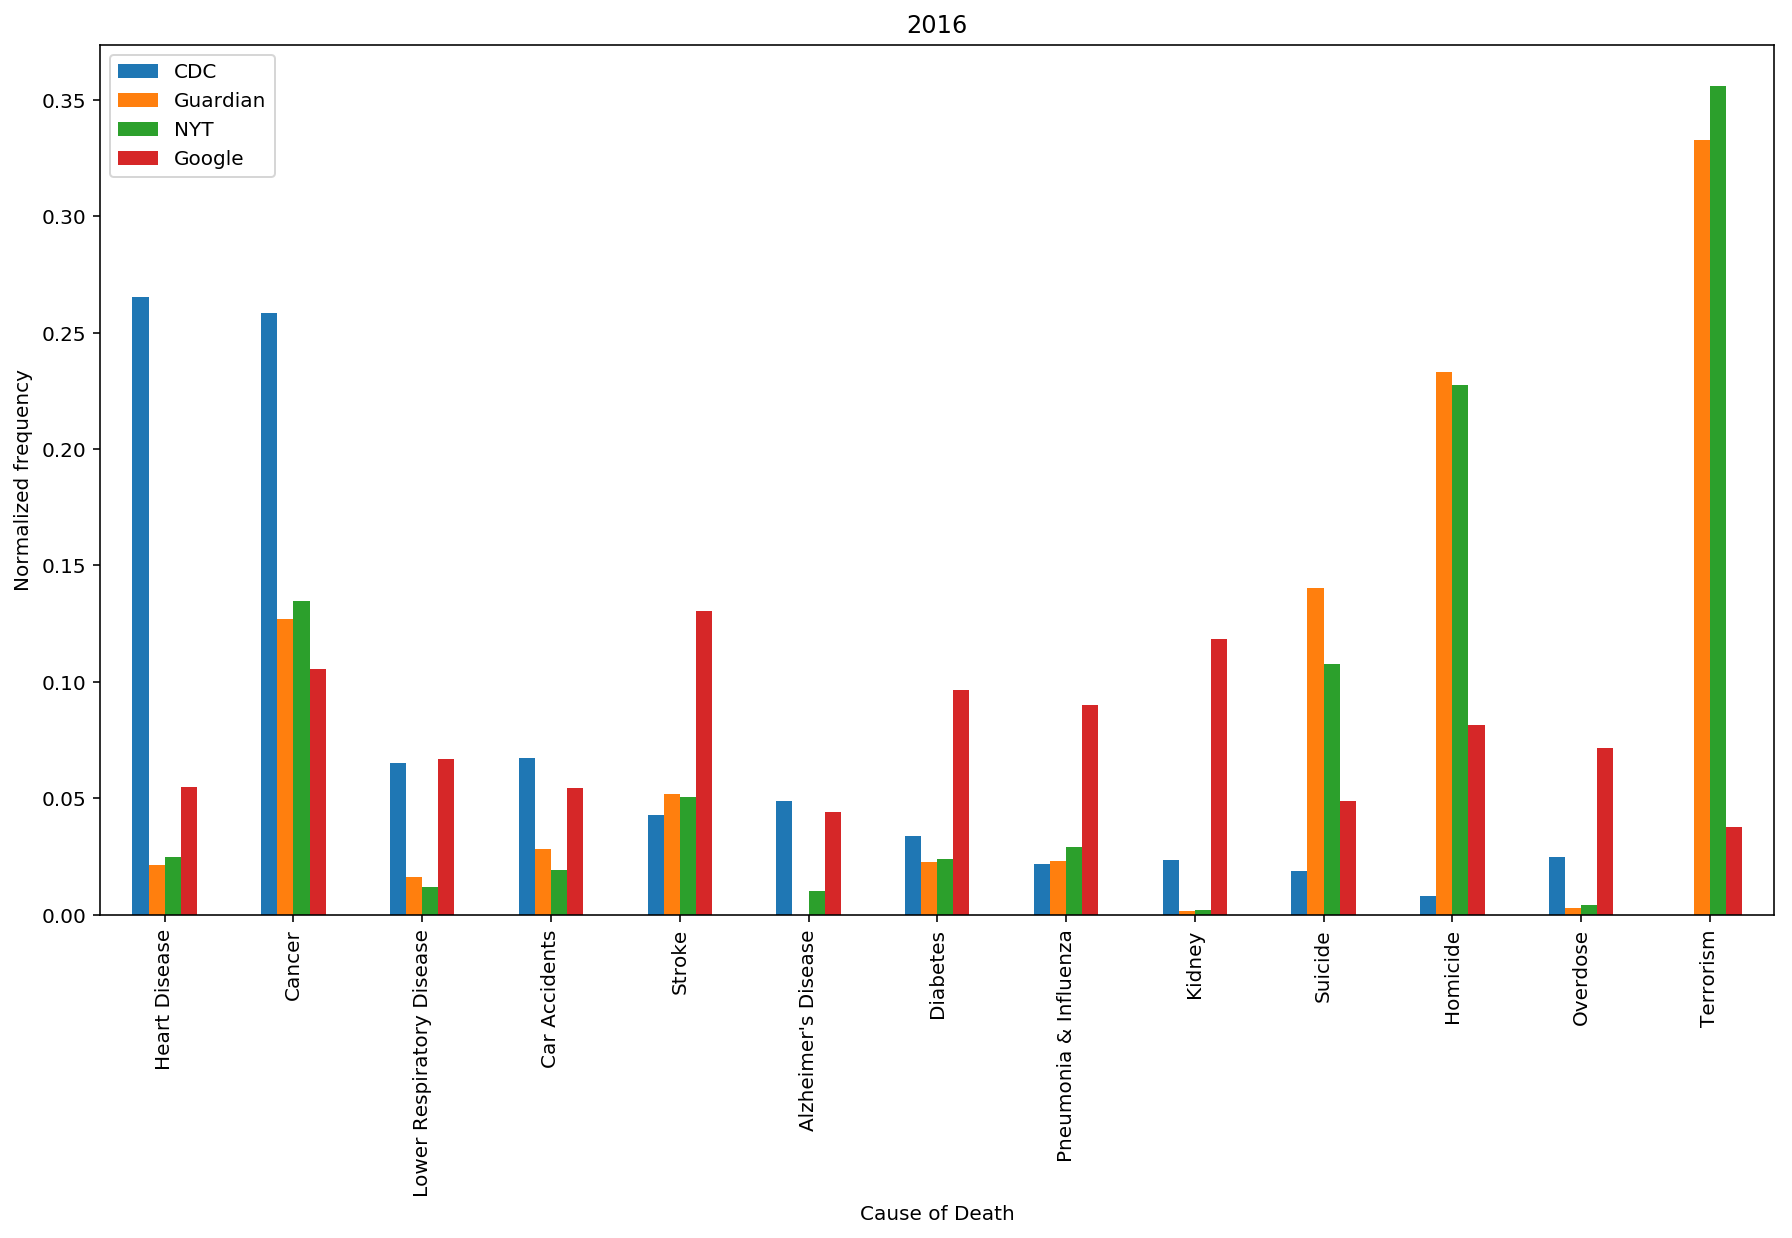

In [75]:
year = 2016
all_data_by_years_dict[year].plot(kind='bar', x='Cause of Death')
plt.ylabel('Normalized frequency')
plt.title(year)

The graphs above all seem to indicate a potential bias toward reporting on Terrorism, so let’s explore those data more below.  

### Examining Terrorism

Text(0.5,0,'year')

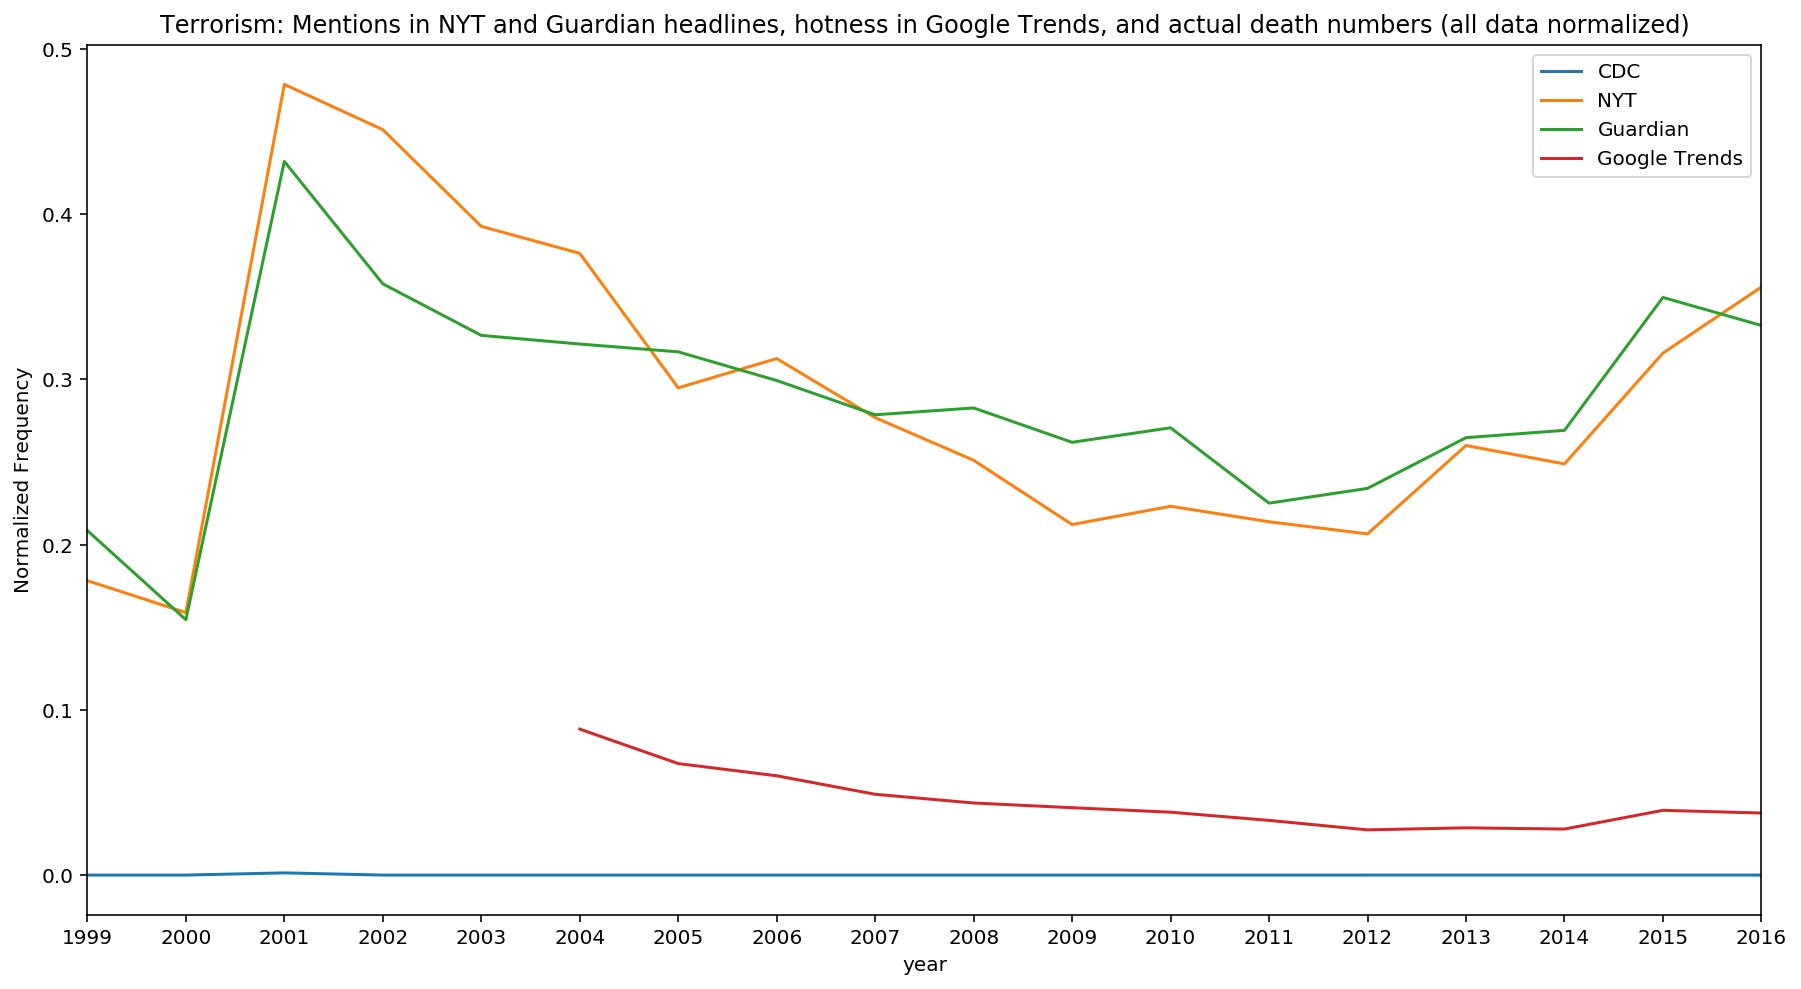

In [76]:
# Terrorism data
terrorism_data = pd.DataFrame(\
    [cdc_years_norm.loc['terrorism', :].tolist(),
     NYT_df.loc[NYT_df['Cause of Death'] == 'Terrorism', :].drop('Cause of Death', axis=1).get_values().tolist()[0],
     Guardian_df_renamed2.loc['Terrorism', :].tolist()[1:],
     pd.Series(np.repeat(np.nan, 5)).append(Google_df_renamed2.loc['Terrorism', :][1:]).tolist()]).transpose()

terrorism_data.columns = ['CDC', 'NYT', 'Guardian', 'Google Trends']
terrorism_data.index = np.arange(1999, 2016+1)
terrorism_data.plot(xticks=np.arange(1999, 2016+1))
plt.title('Terrorism: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)')
plt.ylabel('Normalized Frequency')
plt.xlabel('year')

It appears there is a major spike in terrorism reporting in 2001 and then reporting steadily decreases for the next decade. Then, in 2011 reporting on Terrorism begins to pick up again. Unfortunately, we only have access to Google Trends since 2004, so we cannot compare this trend line fairly here. The data we do have very roughly suggests a sort of balance between the reporting trend and CDC trend. Because all of our data is normalized, it is a bit difficult to detect, but the only real “bump” we see in the CDC death count happens in 2001. However, the overall proportion of reporting on terrorism by New York Times and the Guardian seem to be heavily skewed.

## Statistical Significance Tests

Of course, now we would like to more formally define what we mean by representation and "a difference". One method we can do this is with a chi-squared tests, which looks to see if the underlying distribution of two things is the same. We care about whether or not the news matches the CDC's mortality data, so we can take that to be our "true" distribution" and see if each of our other distributions are homogeneous with the CDC's distribution.

Similarly, we can compare that of the NYT and the Guardian to see if they differ, or if our news sources largely agree with one another.

Note that one potentially staistically unsavory thing we are doing is performing this comparison on the averaged normalized frequency counts across all years. This was mainly to avoid potentialy false positives from otherwise needing to run 17 chi-squared tests (one for each year) and the assumption that year-to-year distributions will not differ by that much. (Which is not exactly true, but hopefully approximately so as to validate the bigger picture of what our analysis represents.)

In [77]:
print("Guardian vs. CDC: chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['Guardian'], all_years_all_data['CDC']))))
print("NYT vs. CDC:      chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['NYT'], all_years_all_data['CDC']))))
print("Google vs. CDC:   chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['Google'], all_years_all_data['CDC']))))
print("Guardian vs. NYT: chi squared = {:.2f}, p = {:.3f}".format(*tuple(sp.stats.chisquare(all_years_all_data['Guardian'], all_years_all_data['NYT']))))

Guardian vs. CDC: chi squared = 20378.90, p = 0.000
NYT vs. CDC:      chi squared = 20476.48, p = 0.000
Google vs. CDC:   chi squared = 268.98, p = 0.000
Guardian vs. NYT: chi squared = 0.97, p = 1.000


Look at those values! Guardian vs. CDC, NYT vs. CDC, and Google vs. CDC all differ highly significantly ($p < .001$). Guardian vs. NYT is highly non-significant, which is what we suspected by inspection above!

Based on these findings, we will reject the null hypothesis in this case. Given our chi-squared values are >> 26.217, it appears to be incredibly unlikely that news coverage in New York Times and the Guardian are accurately representing the proportion of causes of death in the United States of America.

# Discussion

The most surprising result that can be drawn from our analysis is probably conveyed by the plot of terrorism data, which is copied here once more for better readability:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5ffca24c18>,
 Text(0.5,1,'Terrorism: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)'),
 Text(0,0.5,'Normalized Frequency'),
 Text(0.5,0,'year'))

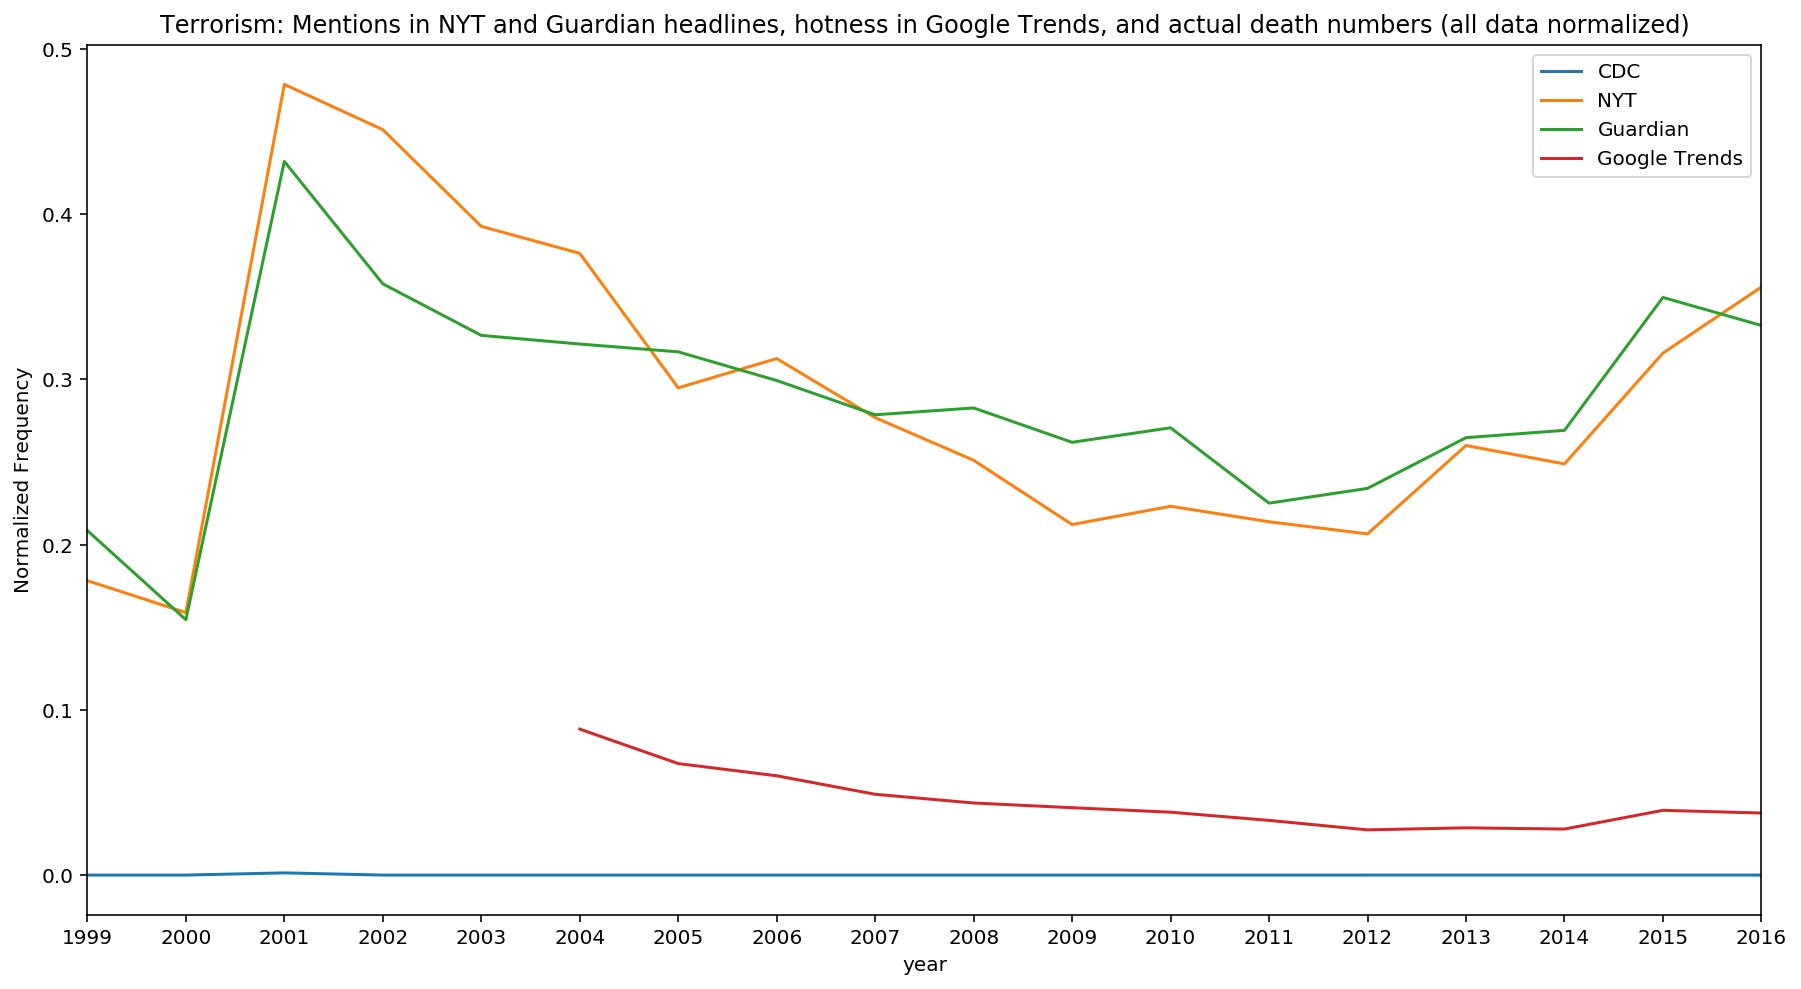

In [78]:
terrorism_data.plot(xticks=np.arange(1999, 2016+1)), plt.title('Terrorism: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)'), plt.ylabel('Normalized Frequency'), plt.xlabel('year')

One oft-mentioned meme is that of terrorism being overrepresented in the public eye. Here, we are able to quantify that amount of overrepresentation:

At least two things become apparent by looking at this plot: First, the temporal correlation of attention towards terrorism is very high for the NYT and the Guardian. This is what we expected, but still a good sign for the validity of the data yielded by our news-scraper.

Second, while there is a huge jump in media attention after 9/11, the jump of the _normalized_ morbidity rate for terrorism is barely visible (as a reminder: We normalized CDC data by dividing the frequencies associated with each death cause category by the sum of frequencies over all categories we were looking at for a given year. The news data was normalized in a similar fashion by dividing the number of hits for a category and year by the sum of hits for all categories of interest for the same year). This is already good cause to suspect that media does _not_ cover different causes of death with a distribution of attention that is proportionate to the actual distribution of death cause frequencies.

(Google Trends data is only available for 2004 and after.)

Now let's look at a different cause of death, namely heart diseases:

Text(0.5,0,'year')

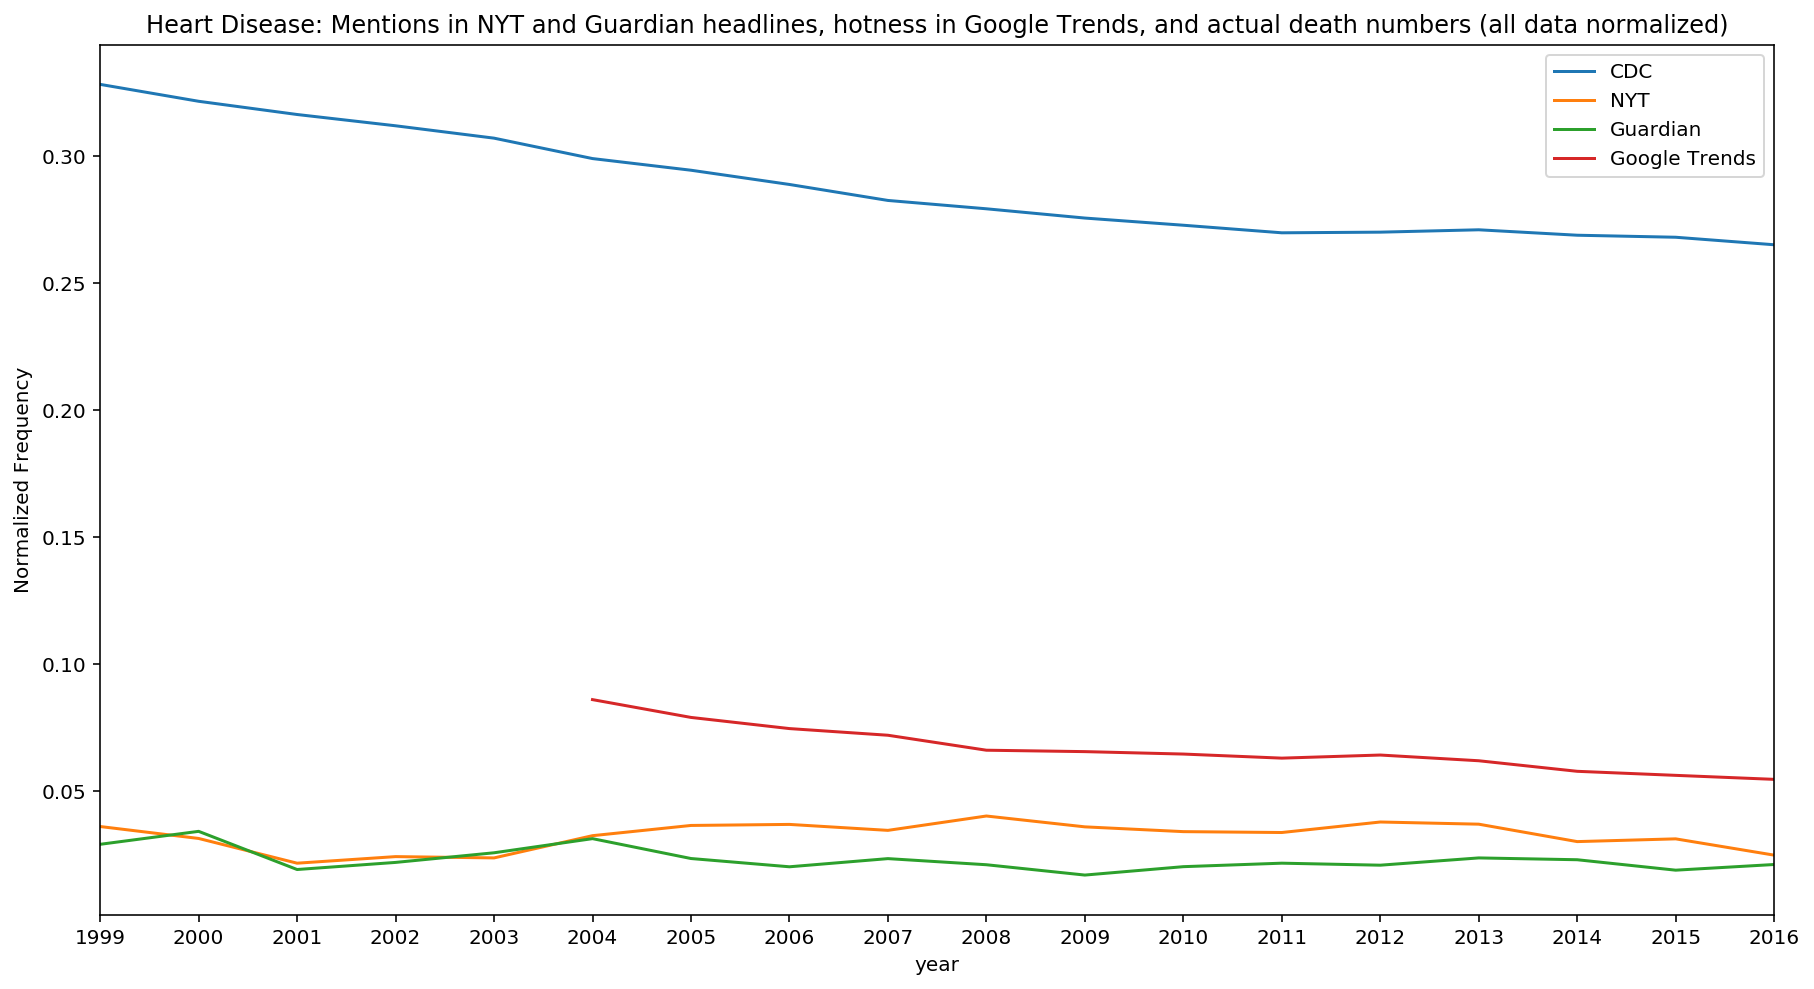

In [79]:
# Terrorism data
heart_data = pd.DataFrame(\
    [cdc_years_norm.loc['heart', :].tolist(),
     NYT_df.loc[NYT_df['Cause of Death'] == 'Heart Disease', :].drop('Cause of Death', axis=1).get_values().tolist()[0],
     Guardian_df_renamed2.loc['Heart Disease', :].tolist()[1:],
     pd.Series(np.repeat(np.nan, 5)).append(Google_df_renamed2.loc['Heart Disease', :][1:]).tolist()]).transpose()

heart_data.columns = ['CDC', 'NYT', 'Guardian', 'Google Trends']
heart_data.index = np.arange(1999, 2016+1)
heart_data.plot(xticks=np.arange(1999, 2016+1))
plt.title('Heart Disease: Mentions in NYT and Guardian headlines, hotness in Google Trends, and actual death numbers (all data normalized)')
plt.ylabel('Normalized Frequency')
plt.xlabel('year')

This example shows the opposite pattern. Heart diseases are under-represented in news coverage when compared to their actual normalized frequencies. The overall trend seems largely uniform and skewed; despite commanding a large proportion of deaths, news outlets (and people) seem to just focus a lot less on this cause of mortality.

Here again a plot with the overall normalized death/mentioning frequencies for all causes of death, summed over years:

Text(0,0.5,'Normalized frequency')

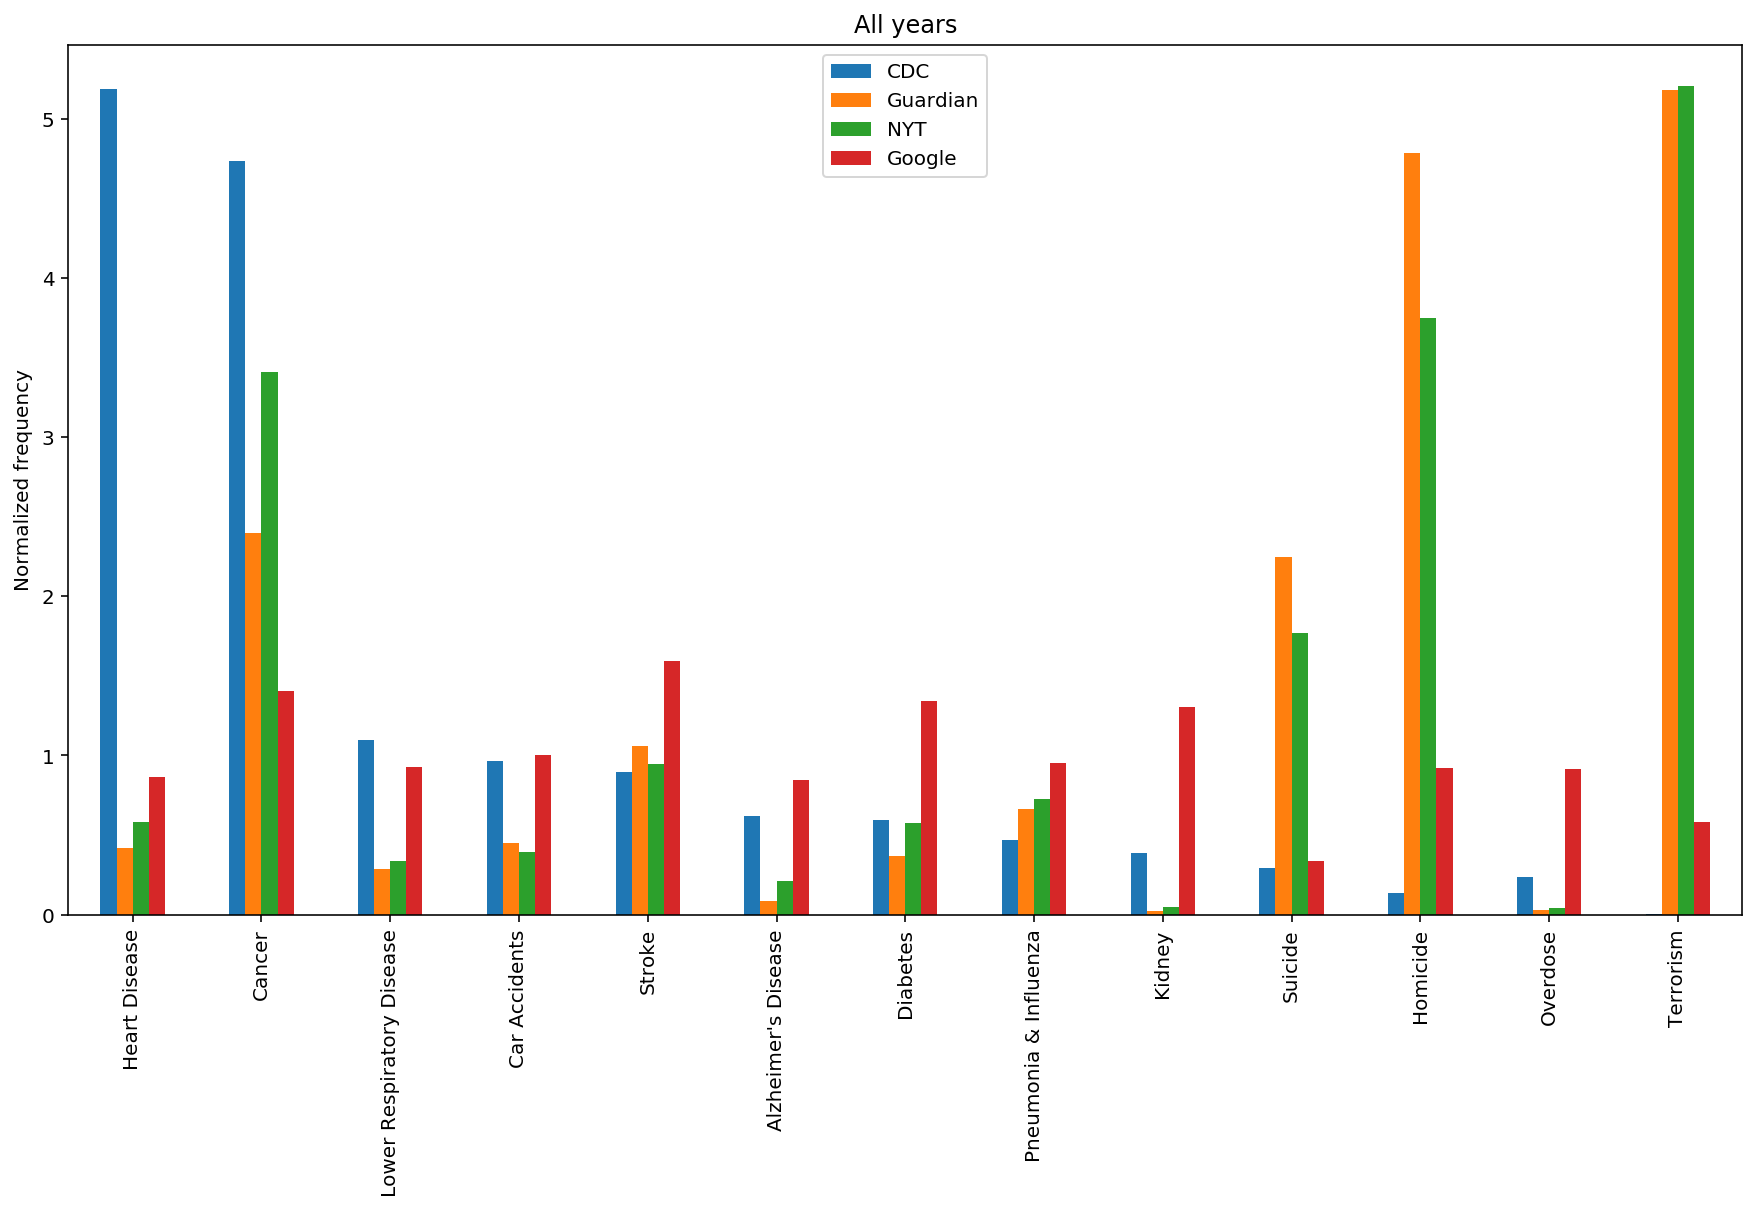

In [80]:
all_years_all_data.plot(kind = 'bar')
plt.title('All years')
plt.ylabel('Normalized frequency')

Judging from this distribution, it seems that the importance of diseases and accidents as death causes is overall exaggerated by the NYT and the Guardian, whereas suicides, homicides, and terrorism are largely over-represented. Note that _of all categories we took into consideration, the two causes of death with the largest media coverage are at the same time the two least frequent causes of death_!

Another interesting note is that the results from Google Trends indicate that people's searching behavior is actually not as biased towards specific causes of death as the news are. Actually, between 2004 and 2016, people displayed more interest in topics such as lower respiratory diseases or kidney diseases than in terrorism. Of all death causes we considered, terrorism ranked second-lowest in terms of people's interest expressed through their search behavior!

********
# Conclusions

Based on this analysis, it appears news coverage may be wildly disproportionate in its coverage of certain causes of death. This may be predicted by the common adage, "If it bleeds, it leads." However, as we mentioned in our introduction, attention is zero-sum in media coverage. There is certainly more coverage of terrorism, homicide, and suicide than there are proportional deaths in each category. Heart disease is one of the least covered causes of death, despite being the most likely killer in the United States. Thus, we propose it is important to use media coverage more fairly to warn people of the true threats to their life.

Moving forward, we would like to be able to control for natural vs. unnatural causes of death to see if there is a sort of surprise effect, or bump in coverage due to the unexpected nature of an event. Additionally, we would want to sample more news sources and consider more causes of death.

However, we argue these results are significant enough to take notice of this disparity now, with hopes of more thorough testing and analysis to follow.

********
## References
Please see our code and supplementary materials at https://github.com/COGS108/Pr_010